In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt 
from scipy import interpolate
import random
import math
import torch
import copy
import time

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.svm import SVC

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
import gc
import mads_dl

from PIL import Image
from IPython.display import Image
import matplotlib.cm as cm
import seaborn as sns
torch.manual_seed(1)
from classes import *
# set all columns to be displayed
pd.set_option('display.max_columns', None)

loaddata = LoadData()


2024-11-17 17:33:01.574878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731861181.588946  163675 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731861181.593278  163675 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-17 17:33:01.607397: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Classes

## Loading Data Classes

In [2]:
# 'FA_20231206_2H_yeast_Pyruvate-d3_1.ser.csv'
# 'FA_20240517_2H_yeast_Nicotinamide-d4 _9.csv'
# 'FA_20240213_2H_yeast_Fumarate-d2_9.csv
file = str(Path('FA_20231123_2H Yeast_Fumarate-d2_12 .csv'))
substrates = loaddata.get_substrate_list(file)
metabolites = loaddata.get_metabolite_list(file)
substrates = [float(i) for i in substrates]
metabolites = [float(i) for i in metabolites]
path_list = loaddata.load_data(file)

In [3]:
print(substrates, metabolites)

[6.653, 4.7] [4.368, 2.474]


# Step 1: Loading the data

In [4]:
# shapes of all the csv files
path_list2 = loaddata.load_data('.csv')

for path in path_list2:
    df = pd.read_csv(path)
    print(df.shape)

(632, 51)
(622, 236)
(806, 151)
(1063, 51)
(837, 238)
(654, 51)
(585, 236)
(960, 131)
(855, 131)
(577, 236)
(679, 151)
(1429, 131)
(1583, 131)
(1170, 236)
(966, 51)
(1527, 131)
(841, 41)
(2003, 131)
(843, 238)
(859, 236)
(706, 131)
(1226, 131)
(880, 131)
(779, 131)
(695, 131)
(778, 51)
(636, 237)
(653, 131)
(1045, 131)
(925, 71)
(793, 236)
(718, 238)
(782, 236)
(2122, 131)
(1279, 131)
(1632, 131)
(941, 238)
(537, 236)
(1796, 101)
(890, 237)
(823, 131)
(1503, 131)
(861, 151)
(681, 236)
(1147, 51)
(755, 131)
(608, 238)
(1480, 237)
(2268, 131)
(1045, 181)
(1023, 51)
(1418, 238)
(691, 236)
(735, 131)
(655, 236)
(1139, 181)
(921, 131)
(1675, 131)
(673, 236)
(645, 238)
(1074, 131)
(908, 51)
(957, 131)
(877, 40)
(1297, 131)
(951, 131)
(1594, 131)
(799, 131)
(776, 236)
(971, 237)
(1675, 131)
(1178, 237)
(2072, 131)
(898, 51)


In [5]:
for file in path_list:
    df = pd.read_csv(file)
    print(df.shape)

(2268, 131)


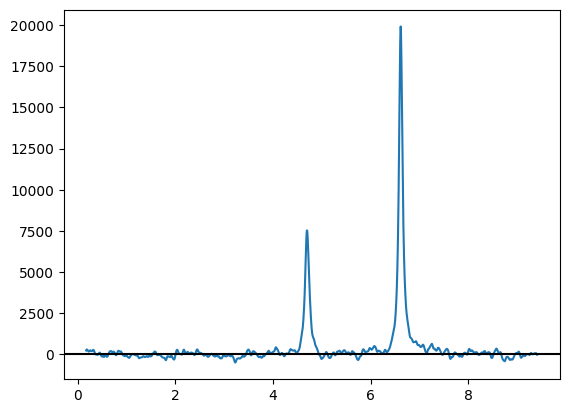

In [6]:
for i in range(len(path_list)):
    df = pd.read_csv(path_list[i])
    

    x = df.iloc[:,0]
    y = df.iloc[:, 1]

    #print(df.shape)

    plt.plot(x,y)

# show x  lines
plt.axhline(y=0, color='k')
plt.show()

# Step 2: Generating synthetic Data for - FA_20231113_2H_yeast_Pyruvate-d3_1.csv

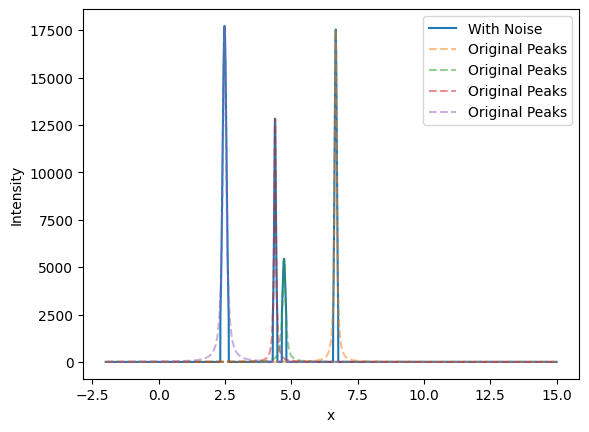

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Lorentzian function
def lorentzian(x, x0, gamma, height):
    return height * (gamma**2 / ((x - x0)**2 + gamma**2))

def gaussian_curve(x, mu=0, sigma=1, height=1):
    """
    Gaussian function with specified height at the peak.
    
    Parameters:
    - x: numpy array or scalar, the input values.
    - mu: float, the mean/center of the curve (default 0).
    - sigma: float, the standard deviation of the Gaussian curve (default 1).
    - height: float, the desired height of the peak of the Gaussian curve.
    
    Returns:
    - numpy array or scalar representing the Gaussian curve.
    """
    return height * np.exp(-0.5 * ((x - mu) / sigma)**2)

def pseudo_voigt(x, mu=0, sigma=1, gamma=1, eta=0.5, height=1):
    """
    Pseudo-Voigt function: a linear combination of Gaussian and Lorentzian curves.

    Parameters:
    - x: numpy array or scalar, the input values.
    - mu: float, the mean/center of the curve.
    - sigma: float, the standard deviation of the Gaussian component.
    - gamma: float, the half-width at half-maximum (HWHM) of the Lorentzian component.
    - eta: float, the mixing parameter (0 = pure Gaussian, 1 = pure Lorentzian).

    Returns:
    - numpy array or scalar representing the pseudo-Voigt profile.
    """
    if not (0 <= eta <= 1):
        raise ValueError("Eta must be between 0 and 1.")
    
    gaussian = gaussian_curve(x, mu, sigma, height=height)
    lorentzian_val = lorentzian(x, mu, gamma, height=height)
    return eta * lorentzian_val + (1 - eta) * gaussian




def generate_random_spectrum(peak_list, spectrum_length=3000):

    # Generate random spectrum with Lorentzian peaks
    x = np.linspace(-2, 15, spectrum_length)  # x range
    y = np.zeros_like(x)          # initialize y as zeros
    mask = np.zeros_like(x)       # mask to identify peak regions

    # Add random Lorentzian peaks
    x0_parms = []
    gamma_parms = []
    height_parms = []

    x0_substrate_parms = []
    gamma_substrate_parms = []
    height_substrate_parms = []

    # let peakist ranomd jump left and right

    peak_list = np.array(peak_list) + np.random.uniform(-0.1, 0.1)

    for peak_pos in peak_list:
        metabolism_x0 = peak_pos + np.random.uniform(-0.02, 0.02)
        
        metabolism_gamma = np.random.uniform(0.009, 0.08)  # Random width (gamma)
        metabolism_height = np.random.uniform(100, 20000)  # Random height
        # select random function:
        #peak_lorenz = gaussian_curve(x=x, mu=metabolism_x0, sigma=metabolism_gamma, height=metabolism_height)

        peak_lorenz = pseudo_voigt(x=x, mu=metabolism_x0, sigma=metabolism_gamma, gamma=metabolism_gamma, eta=np.random.uniform(0, 1), height=metabolism_height)

        #peak_lorenz = lorentzian(x, metabolism_x0, metabolism_gamma, metabolism_height)
        y = np.maximum(y, peak_lorenz)  # Use maximum to avoid summing peaks

        # Create a mask to identify regions near the peaks (exclude noise here)
        mask += peak_lorenz > (0.1 * metabolism_height)  # Masking regions where peak height is significant

        # Append the parameters for the peak
        x0_parms.append(metabolism_x0)
        gamma_parms.append(metabolism_gamma)
        height_parms.append(metabolism_height)



    # Add noise only outside the peak regions
    random_noise_level = np.random.uniform(0, df.max().max())
    gaussian_noise = np.random.normal(0, 500, 3000)
    laplace_noise = np.random.laplace(0, 500, 3000)

    # choose random between noise1 and noise2
    noise = gaussian_noise if np.random.rand() > 0.5 else laplace_noise

    #noise = np.random.normal(10, random_noise_level, spectrum_length)

    # smooth the noise with gaussian filter
    sigma = random_noise_level /1
    #noise = gaussian_filter1d(noise, sigma=sigma)
    # rollwing window mean
    noise = np.convolve(noise, np.ones(50)/50, mode='same')
    
    
        
    y_noisy = y + noise * (mask == 0)  # Add noise only where mask is 0 (outside peaks)

    # set everything below treshold to zero
    
    # Calculate the 80 percentile 
    percentile = np.percentile(y_noisy, 95)

    y_clean = np.where(y_noisy < percentile, 0, y_noisy)

    #print(y_noisy.shape, y_clean.shape)

    

    return x, y_clean, np.array(x0_parms), np.array(gamma_parms), np.array(height_parms)


# ----

#peak_list = [2.323, 4.7, 1.201]
substrates_list = substrates + metabolites
x, y_noisy, x0_parms, gamma_parms, height_parms = generate_random_spectrum(substrates_list)

# Plot the result
plt.plot(x, y_noisy, '-', label="With Noise")

for x0, gamma, height in zip(x0_parms, gamma_parms, height_parms):
    lorentz = lorentzian(x, x0, gamma, height)
    plt.plot(x, lorentz, '--', label="Original Peaks", alpha=0.5)  
plt.xlabel('x')
plt.ylabel('Intensity')
plt.legend()
plt.show()


# Step 3: Fill Up Original Data 

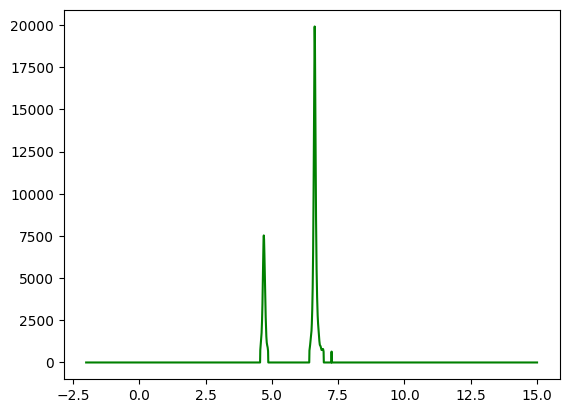

(4177, 2)


,x,y
0,-2.000000,0.0
1,-1.995927,0.0
2,-1.991855,0.0
3,-1.987782,0.0
4,-1.983710,0.0
...,...,...
4172,14.983135,0.0
4173,14.987208,0.0
4174,14.991280,0.0
4175,14.995353,0.0


In [8]:



def interpolate_to_shape(x_original, y_original, spectrum_lenth=3000):
    """_summary_

    # Originaldaten
    y_original = df.iloc[:, 1]
    x_original = df.iloc[:, 0]

    Args:
        df (_type_): _description_
    """


    # Neue x-Werte (stellen Sie sicher, dass diese innerhalb des Bereichs von x_original liegen)
    x_new = np.linspace(x_original.min(), x_original.max(), spectrum_lenth)

    # Interpolierte Daten
    interpolated_data = interpolate.interp1d(x_original, y_original, kind='linear')(x_new)
    
    df = pd.DataFrame({'x': x_new, 'y': interpolated_data})
    return df

def fill_df(df):
    """If Data is not ranging from -2 to 10, fill the data with noise
    
    """
    treshold = 95

    # renmame the columns
    df.columns = ['x', 'y']
    x = df.loc[:, 'x']
    y = df.loc[:, 'y']



    # Calculate the step size of the x values
    x_diff = np.diff(x)
    step = np.mean(x_diff)
    
    # Take sample range for the noise
    x_range_lower = 0
    x_range_upper = 100

    # get sample data of the noise
    x_sample = x[x_range_lower:x_range_upper]
    y_sample = y[x_range_lower:x_range_upper]

    # get the max and min values of the sample data
    y_min, y_max = (y_sample.min()), abs(y_sample.max())
    #print(y_min, y_max)

    # get the min max of the x values
    x_min, x_max = x.min(), x.min()

    if x_min > -2:


        # create values in n steps
        x_new = np.arange(-2, x.iloc[0], step)
        y_new = np.zeros_like(x_new)

        # set the noise level
        noise = np.random.normal(0, y_max, len(x_new))


        
        # smooth the noise with gaussian filter
        # Berechne die Standardabweichung der y-Daten
        sigma = len(y_new) / 100
        noise = gaussian_filter1d(input=noise, sigma=sigma)

        # replace y_new with noise
        y_new = noise

        #percentile = np.percentile(y_new, treshold)

        #y_new = np.where(y_new < percentile, 0, y_new)

        data = pd.DataFrame({'x': x_new, 'y': y_new})
        df = pd.concat([data, df], axis=0)
        df.reset_index(drop=True, inplace=True)

    if x_max < 15:
    
        # create values in n steps
        x_new = np.arange(x.iloc[-1], 15, step)
        #print(x_new)
        y_new = np.zeros_like(x_new)

        # set the noise level
        noise = np.random.normal(0, y_max, len(x_new))

        # smooth the noise with gaussian filter
        # Berechne die Standardabweichung der y-Daten
        sigma = len(y_new) / 100
        noise = gaussian_filter1d(input=noise, sigma=sigma)

        # replace y_new with noise
        y_new = noise

        #percentile = np.percentile(y_new, treshold)

        #y_new = np.where(y_new < percentile, 0, y_new)

        data = pd.DataFrame({'x': x_new, 'y': y_new})
        df = pd.concat([df, data], axis=0)
        df.reset_index(drop=True, inplace=True)

    percentile = df['y'].quantile(treshold/100)

    df.loc[df['y'] < percentile, 'y'] = 0

    #display(df)
                
    return df


df_fill = df.iloc[:, [0,1]]
#print(df_fill.head())
df_filled = fill_df(df_fill)
#print(df_filled.head())

# plot 
plt.plot(df_filled.iloc[:, 0], df_filled.iloc[:, 1], color='green')
#plt.plot(df_fill.iloc[:, 0], df_fill.iloc[:, 1], color='blue', alpha=0.2)
plt.show()
print(df_filled.shape)
display(df_filled)

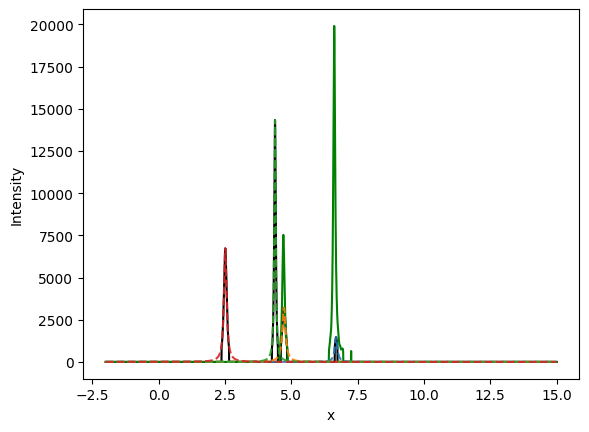

In [9]:
# visualize random spectra and real spectra


substrates_list = substrates + metabolites
x, y_noisy, x0_parms, gamma_parms, height_parms = generate_random_spectrum(substrates_list)

# Plot the result
plt.plot(x, y_noisy, '-', label="With Noise", color='black')
plt.plot(df_filled.iloc[:, 0], df_filled.iloc[:, 1], color='green')
for x0, gamma, height in zip(x0_parms, gamma_parms, height_parms):
    lorentz = lorentzian(x, x0, gamma, height)
    plt.plot(x, lorentz, '--', label="Original Peaks", alpha=0.9)  



#plt.plot(df_fill.iloc[:, 0], df_fill.iloc[:, 1], color='blue', alpha=0.2)
plt.xlabel('x')
plt.ylabel('Intensity')
plt.show()

# Step 3: Bring data to same shape

(3000, 2)


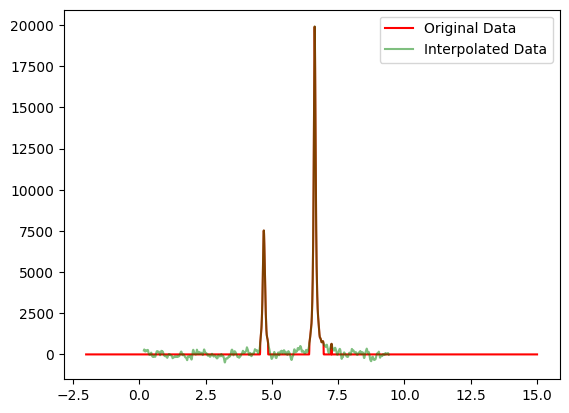

In [10]:

# Interpoliere die Werte, um die Größe des DataFrames zu erweitern
df_interpolated = interpolate_to_shape(df_filled.iloc[:, 0], df_filled.iloc[:, 1], spectrum_lenth=3000)

# Form des interpolierten DataFrames
print(df_interpolated.shape)

# Plot the interpolated data
#plt.plot(df_filled.iloc[:, 0], df_filled.iloc[:, 1])
plt.plot(df_interpolated.iloc[:, 0], df_interpolated.iloc[:, 1], color='red',)
plt.plot(df.iloc[:, 0], df.iloc[:, 1], color='green', alpha=0.5)
plt.legend(['Original Data', 'Interpolated Data', 'Sum'])
plt.show()

# Step 4: Bring Data to shape for Transformer

In [11]:
df_interpolated.shape

(3000, 2)

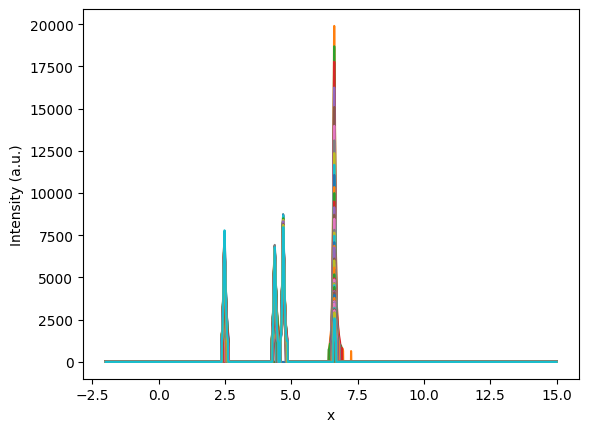

In [12]:
for i in range(df.shape[1]-1):

    df_filled = fill_df(df.iloc[:, [0, i]])
    df_interpolated = interpolate_to_shape(df_filled.loc[:,'x'], df_filled.loc[:,'y'], spectrum_lenth=3000)
    #plt.plot(df_filled.loc[:,'x'], df_filled.loc[:,'y'], '-', label='Original Data')
    plt.plot(df_interpolated.iloc[:, 0], df_interpolated.iloc[:, 1], '-', label='Interpolated Data')

# data_train_tensor & y_train
substrates_list = substrates + metabolites
x_synth, y_synth, x0_parms, gamma_parms, height_parms = generate_random_spectrum(substrates_list)


#plt.plot(x_synth, y_synth, label="With Noise")
plt.xlabel('x')
plt.ylabel('Intensity (a.u.)')

plt.show()

# Generate training Dataset 

In [13]:

num_samples = 20000

x_data = []
y_data = []
x0_parms_list = []
gamma_parms_list = []
height_parms_list = []
for i in range(num_samples):
    # data_train_tensor & y_train
    substrates_list = substrates + metabolites
    x, y_noisy, x0_parms, gamma_parms, height_parms = generate_random_spectrum(substrates_list)
    x_data.append(x)
    y_data.append(y_noisy)
    x0_parms_list.append(x0_parms)
    gamma_parms_list.append(gamma_parms)
    height_parms_list.append(height_parms)




# Umwandeln der lists in Tensoren
x_data = torch.tensor(x_data)
data = torch.tensor(y_data) # Data: Noisy Spectra which is input to the model
x_params_tensor = torch.tensor(x0_parms_list) # Target: 
gamma_params_tensor = torch.tensor(gamma_parms_list)
height_params_tensor = torch.tensor(height_parms_list)

target = torch.cat((x_params_tensor, gamma_params_tensor, height_params_tensor), dim=1)



# Überprüfen der Formen
print(f"x_data shape: {x_data.shape}")
print(f"data shape: {data.shape}")
print(f"x_params_tensor shape: {x_params_tensor.shape}")
print(f"gamma_params_tensor shape: {gamma_params_tensor.shape}")
print(f"height_params_tensor shape: {height_params_tensor.shape}")
print(f"target shape: {target.shape}")
print('\n')

/tmp/ipykernel_163675/2502958047.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  x_data = torch.tensor(x_data)


x_data shape: torch.Size([20000, 3000])
data shape: torch.Size([20000, 3000])
x_params_tensor shape: torch.Size([20000, 4])
gamma_params_tensor shape: torch.Size([20000, 4])
height_params_tensor shape: torch.Size([20000, 4])
target shape: torch.Size([20000, 12])




In [14]:

def scale_data(data, target):
    """Scale the data
    
    Args:
        x_data (_type_): _description_
        y_data (_type_): _description_
    """
    # Skalieren Sie die Daten
    data_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    print(f'Before Scaling: {data.shape}')
    print(f'Before Scaling: {target.shape}')

    # Reshape the data before scaling
    data = data.reshape(data.shape[0], -1)
    target = target.reshape(target.shape[0], -1)

    print(f'After Reshaping: {data.shape}')
    print(f'After Reshaping: {target.shape}')

    # Skalieren Sie die x-Daten
    data_scaled = data_scaler.fit_transform(data)
    target_scaled = target_scaler.fit_transform(target)
    
    print(f'After Scaling: {data_scaled.shape}')
    print(f'After Scaling: {target_scaled.shape}')


    return data_scaled, target_scaled, data_scaler, target_scaler
    

# Skalieren Sie die Daten
data_scaled, target_scaled, data_scaler, target_scaler = scale_data(data, target)

Before Scaling: torch.Size([20000, 3000])
Before Scaling: torch.Size([20000, 12])
After Reshaping: torch.Size([20000, 3000])
After Reshaping: torch.Size([20000, 12])
After Scaling: (20000, 3000)
After Scaling: (20000, 12)


In [15]:
from sklearn.model_selection import train_test_split
import torch
from sklearn.preprocessing import MinMaxScaler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Aufteilen der Daten in Trainings- und Testsets
data_train, data_tmp, target_train, target_tmp = train_test_split(data, target, 
                                                    test_size=0.4,
                                                    shuffle=True,
                                                    random_state=1)
data_val, data_test, target_val, target_test = train_test_split(data_tmp, target_tmp,
                                                    test_size=0.5,
                                                    shuffle=True,
                                                    random_state=1)

# import StandardScaler
from sklearn.preprocessing import StandardScaler

# Skalieren der Daten
data_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Skalieren von data train und test
data_train_sc = data_scaler.fit_transform(data_train)
data_val_sc = data_scaler.transform(data_val)
data_test_sc = data_scaler.transform(data_test)

# Skalieren von target train und test
target_train_sc = target_scaler.fit_transform(target_train)
target_val_sc = target_scaler.transform(target_val)
target_test_sc = target_scaler.transform(target_test)


# Konvertieren in Tensoren
data_train_tensor = torch.tensor(data_train_sc, dtype=torch.float32)
data_val_tensor = torch.tensor(data_val_sc, dtype=torch.float32)
data_test_tensor = torch.tensor(data_test_sc, dtype=torch.float32)
target_train_tensor = torch.tensor(target_train_sc, dtype=torch.float32)
target_val_tensor = torch.tensor(target_val_sc, dtype=torch.float32)
target_test_tensor = torch.tensor(target_test_sc, dtype=torch.float32)





# # Reshape the tensors for the model
# target_train_tensor = target_train_tensor.reshape(target_train_tensor.shape[0], -1)
# target_val_tensor = target_val_tensor.reshape(target_val_tensor.shape[0], -1)

# Überprüfen der Tensoren
print(f"Data Train Shape: {data_train_tensor.shape}")
print(f"Data Val Shape: {data_val_tensor.shape}")
print(f"Data Test Shape: {data_test_tensor.shape}")
print(f"Target Train Shape: {target_train_tensor.shape}")
print(f"Target Val Shape: {target_val_tensor.shape}")
print(f"Target Test Shape: {target_test_tensor.shape}")

Data Train Shape: torch.Size([12000, 3000])
Data Val Shape: torch.Size([4000, 3000])
Data Test Shape: torch.Size([4000, 3000])
Target Train Shape: torch.Size([12000, 12])
Target Val Shape: torch.Size([4000, 12])
Target Test Shape: torch.Size([4000, 12])


# LSTM 

In [16]:
# class NeuralNetwork(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, dropout_prob):
#         super(NeuralNetwork, self).__init__()

#         self.reduce = nn.Linear(3000, hidden_size)

#         # Define LSTM with correct hidden size
#         self.lstm = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=2, batch_first=True)

#         # Fully connected layers with corrected input sizes
#         self.fc1 = nn.Sequential(
#             nn.Linear(hidden_size, 128),  # Match hidden_size with the output of LSTM
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         self.fc2 = nn.Sequential(
#             nn.Linear(128, 32),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         self.fc3 = nn.Sequential(
#             nn.Linear(32, 16),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         # Output layer
#         self.output = nn.Linear(16, output_size)

#     def forward(self, x):
#         # Check shape before reducing
#         #print(f"Input shape before reduction: {x.shape}")  # For debugging
#         x = self.reduce(x)  # This should expect (batch_size, 3000)
        

#         # Reshape for LSTM input
#         x = x.reshape(x.shape[0], 1, -1)  # Reshape to (batch_size, seq_len, input_size)
#         #print(f"Shape after reduction: {x.shape}")

#         batch_size = x.shape[0]
        
#         # Initialize hidden and cell states with hidden_size instead of input_size
#         h_0 = torch.zeros(2, batch_size, hidden_size).to(x.device)
#         #c_0 = torch.zeros(2, batch_size, hidden_size).to(x.device)

#         # Pass data through LSTM
#         x, _ = self.lstm(x, (h_0))
#         x = x[:, -1, :]  # Take the output from the last time step

#         # Pass data through fully connected layers
#         x = self.fc1(x)
#         x = self.fc2(x)
#         x = self.fc3(x)

#         # Final output
#         output = self.output(x)
#         return output
    
#     def predict(self, X):
#         '''
#         Use the model to predict for the values in the test set.
#         Return the prediction
#         '''
#         model.eval()
#         with torch.no_grad():
#             return model(X)


In [17]:
print(data_train_tensor.shape, target_train_tensor.shape)

torch.Size([12000, 3000]) torch.Size([12000, 12])


# Conv1D

In [18]:
# import torch
# import torch.nn as nn

# class NeuralNetwork(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, dropout_prob):
#         super(NeuralNetwork, self).__init__()
        
#         self.firstpooling = nn.Sequential(
#             nn.AvgPool1d(kernel_size=2, stride=2, padding=0),
#             nn.Dropout(p=dropout_prob),
#             nn.LeakyReLU()
#         )
#         # Convolutional and pooling layers  
#         self.conv1 = nn.Sequential(
#             nn.Conv1d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob),
#             nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
#         )
        
        
#         self.conv2 = nn.Sequential(
#             nn.Conv1d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob),
#             nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
#         )
        

#         # Fully connected layers
#         self.fc1 = nn.Sequential(
#             nn.Linear(3000, 1000),  # Adjust for pooling effects
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         self.fc2 = nn.Sequential(
#             nn.Linear(1000, 128),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         self.fc3 = nn.Sequential(
#             nn.Linear(3000, 32),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         # Output layer
#         self.output = nn.Linear(32, output_size)

#     def forward(self, x):
#         # Apply convolutional layers with pooling
        
#         x = x.unsqueeze(1)
#         x = self.firstpooling(x)
#         x = self.conv1(x)      
#         x = self.conv2(x)  

#         #print(x.shape)
#         # Flatten the output for fully connected layers
#         x = x.reshape(x.shape[0], -1)        
#         # Pass through fully connected layers
#         # x = self.fc1(x)
#         # x = self.fc2(x)
#         x = self.fc3(x)

#         # Output layer
#         output = self.output(x)
#         return output

#     def predict(self, X):
#         self.eval()
#         with torch.no_grad():
#             return self(X)


In [19]:
# import torch
# import torch.nn as nn
# import math

# class NeuralNetwork(nn.Module):
#     def __init__(self, 
#                  input_size=3000, 
#                  hidden_size=128, 
#                  output_size=27, 
#                  dropout_prob=0.2,
#                  avgpool_kernel_size=2,
#                  avgpool_stride=2,
#                  avgpool_padding=0,

#                  conv1_in_channels=1,
#                  conv1_out_channels=8,
#                  conv1_kernel_size=3,
#                  conv1_stride=1,
#                  conv1_padding=1,

#                  conv2_in_channels=8,
#                  conv2_out_channels=12,
#                  conv2_kernel_size=3,
#                  conv2_stride=1,
#                  conv2_padding=1,
#                  fc1_out_features=128,
                
#                  fc3_out_features=32):
#         super(NeuralNetwork, self).__init__()
        
#         # Pooling and activation
#         self.firstpooling = nn.Sequential(
#             nn.AvgPool1d(kernel_size=avgpool_kernel_size, stride=avgpool_stride, padding=avgpool_padding),
#             nn.Dropout(p=dropout_prob),
#             nn.LeakyReLU()
#         )

#         # Convolutional and pooling layers  
#         self.conv1 = nn.Sequential(
#             nn.Conv1d(in_channels=conv1_in_channels, out_channels=conv1_out_channels, 
#                       kernel_size=conv1_kernel_size, stride=conv1_stride, padding=conv1_padding),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob),
#             nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
#         )

#         # self.conv2 = nn.Sequential(
#         #     nn.Conv1d(in_channels=conv1_out_channels, out_channels=conv2_out_channels, 
#         #               kernel_size=conv2_kernel_size, stride=conv2_stride, padding=conv2_padding),
#         #     nn.LeakyReLU(),
#         #     nn.Dropout(p=dropout_prob),
#         #     nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
#         # )

#         # Compute output size after convolution and pooling
#         def compute_output_size(input_len, kernel_size, stride, padding, layers=1):
#             for _ in range(layers):
#                 input_len = math.floor((input_len + 2 * padding - (kernel_size - 1) - 1) / stride + 1)
#             return input_len

#         pooled_size = compute_output_size(input_size, avgpool_kernel_size, avgpool_stride, avgpool_padding)
#         conv1_size = compute_output_size(pooled_size, conv1_kernel_size, conv1_stride, conv1_padding)
#         conv1_pooled = math.floor(conv1_size / 2)  # Max pooling halves the size
#         conv2_size = compute_output_size(conv1_pooled, conv2_kernel_size, conv2_stride, conv2_padding)
#         conv2_pooled = math.floor(conv2_size / 2)  # Max pooling halves the size again

#         flattened_size = conv1_out_channels * conv1_pooled

#         # # Fully connected layers
#         # self.fc1 = nn.Sequential(
#         #     nn.Linear(flattened_size, fc1_out_features),
#         #     nn.LeakyReLU(),
#         #     nn.Dropout(p=dropout_prob)
#         # )

#         self.fc2 = nn.Sequential(
#             nn.Linear(flattened_size, fc3_out_features),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         # Output layer
#         self.output = nn.Linear(fc3_out_features, output_size)

#     def forward(self, x):
#         x = x.unsqueeze(1)  # Add channel dimension
#         x = self.firstpooling(x)
#         x = self.conv1(x)
#         #x = self.conv2(x)
#         x = x.reshape(x.shape[0], -1)  # Flatten
#         #x = self.fc1(x)
#         x = self.fc2(x)
#         output = self.output(x)

#         return output

#     def predict(self, X):
#         self.eval()
#         with torch.no_grad():
#             return self(X)

# Linear Layer

In [20]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, 
                 input_size=3000, 
                 fc1_output=512,
                 #fc2_output = 512, 
                 output_size=len(substrates_list) * 3, 
                 dropout_prob=0.1,
                 kernel_size=2,
                 stride=1,
                 padding=1
                 ):
        

        super(NeuralNetwork, self).__init__()

        self.pooling = nn.Sequential(
            nn.MaxPool1d(kernel_size=kernel_size, stride=stride, padding=padding)
        )
        reduced_size = (input_size + 2 * padding - kernel_size) // stride + 1
        self.fc1 = nn.Sequential(
            nn.Linear(reduced_size, fc1_output),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_prob)
        )

        # self.fc2 = nn.Sequential(
        #     nn.Linear(fc1_output, fc2_output),
        #     nn.LeakyReLU(),
        #     nn.Dropout(p=dropout_prob)
        # )


        # Output layer
        self.output = nn.Linear(fc1_output, output_size)

    def forward(self, x):

        # Erweitern der Eingabe für MaxPool1d
        x = x.unsqueeze(1)  # Form: (batch_size, 1, sequence_length)
        x = self.pooling(x)
        x = x.squeeze(1)    # Zurück zu (batch_size, sequence_length)

        x = self.fc1(x)
        # x = self.fc2(x)
        output = self.output(x)
        return output


    def predict(self, X):
        self.eval()
        with torch.no_grad():
            return self(X)

# Training

In [21]:

def calculate_mse_of_real_data(df, model, random=True, i = 3, tensor=False):

    """
    e.g. df: df.iloc[:, [0, 1]]
    """

    if random:
        i = np.random.randint(1, df.shape[1])

    # fill the data
    df_fill = fill_df(df.iloc[:, [0, i]])

    # interpolate the data
    df_interpolated = interpolate_to_shape(df_fill.iloc[:, 0], df_fill.iloc[:, 1], spectrum_lenth=3000)
    #display(df_interpolated)
    x_real = df_interpolated.loc[:, 'x']
    y_real = df_interpolated.loc[:, 'y']

    # scale the data
    y_real_sc = data_scaler.transform(y_real.values.reshape(1, -1))


    # convert to tensor
    y_real_tensor = torch.tensor(y_real_sc, dtype=torch.float32).to(device)

    # predict the data
    target_real_pred = model.predict(y_real_tensor)

    if tensor == True:
        print(target_real_pred)

    # bring the data back to the cpu
    target_real_pred_cpu = target_real_pred.cpu().detach().numpy()

    # rescale the data
    target_real_pred_rescaled = target_scaler.inverse_transform(target_real_pred_cpu)

    # reshape the data
    target_real_pred = target_real_pred_rescaled.reshape(target_real_pred_rescaled.shape[0], -1)

    x0_parms_real, gamma_parms_real, height_parms_real = np.split(target_real_pred, 3, axis=1)

        

    # Put the Lorenz functions in a Dataframe
    lorentz_list = []
    lorentz_df = pd.DataFrame({'x': x_real})  # Initialize DataFrame with x_real

    for i, (x0, gamma, height) in enumerate(zip(x0_parms_real[0], gamma_parms_real[0], height_parms_real[0])):
        lorentz = lorentzian(x_real, x0, gamma, height)
        column_name = f'lorentz_{i}'  # Dynamically generate a unique column name
        lorentz_df = pd.concat([lorentz_df, pd.DataFrame({column_name: lorentz})], axis=1)

    # add another column which takes the np.maximum of the columns
    lorentz_df['max'] = lorentz_df.iloc[:, 1:].max(axis=1)
    #display(lorentz_df)

    # calculate the mse between the real data and lorentz_df
    mse = mean_squared_error(y_real, lorentz_df['max'])
    return mse

In [22]:
def my_loss(df, model, random=True, i=3, device='cpu', weight=0.01):
    """
    Calculate MSE of real data, ensuring it can be used for backpropagation.
    """
    if random:
        i = np.random.randint(1, df.shape[1])

    # Fill the data
    df_fill = fill_df(df.iloc[:, [0, i]])

    # Interpolate the data
    df_interpolated = interpolate_to_shape(df_fill.iloc[:, 0], df_fill.iloc[:, 1], spectrum_lenth=3000)
    x_real = torch.tensor(df_interpolated['x'].values, dtype=torch.float32, device=device, requires_grad=False)
    y_real = torch.tensor(df_interpolated['y'].values, dtype=torch.float32, device=device, requires_grad=False)

    # scale the data
    y_real_sc = data_scaler.transform(y_real.cpu().numpy().reshape(1, -1))
    


    # convert to tensor
    y_real_tensor = torch.tensor(y_real_sc, dtype=torch.float32, requires_grad=True).to(device)

    # Predict the data
    target_real_pred = model(y_real_tensor)

    # reshape the data
    target_real_pred = target_real_pred.reshape(target_real_pred.shape[0], -1)
    #print(target_real_pred.shape)


    # # Split the predictions
    x0_parms_real, gamma_parms_real, height_parms_real = torch.split(
        target_real_pred, target_real_pred.shape[1] // 3, dim=1
    )
    #print(x0_parms_real.shape)
    # Compute Lorentzian functions
    lorentz_list = []
    for x0, gamma, height in zip(x0_parms_real[0], gamma_parms_real[0], height_parms_real[0]):
        lorentz = lorentzian(x_real, x0, gamma, height)  # Assume lorentzian returns a PyTorch tensor
        lorentz_list.append(lorentz)

    lorentz_tensor = torch.stack(lorentz_list, dim=1)
    max_lorentz = torch.max(lorentz_tensor, dim=1).values

    max_lorentz = max_lorentz.clone().detach().requires_grad_(True).to(device)


    # del lorentz_tensor, x0_parms_real, gamma_parms_real, height_parms_real, target_real_pred, y_real_tensor
    # torch.cuda.empty_cache()

    # Squeeze from shape (1, 3000) to shape (3000,)
    y_real_tensor = y_real_tensor.squeeze(0)

    # Compute MSE using PyTorch
    mse_loss = torch.mean((max_lorentz - y_real_tensor)**2) + torch.mean(y_real_tensor * weight)
    #mse = torch.nn.functional.mse_loss(max_lorentz, y_real_tensor)
    #print(mse_loss, mse_loss.shape, mse_loss.dtype)
    # if True:
    #     # Convert to NumPy for plotting
    #     tensor_1d_np = max_lorentz.detach().cpu().numpy()

    #     # Plot
    #     plt.plot(x_real,tensor_1d_np)
    #     plt.title("1D Tensor Line Plot")
    #     plt.xlabel("Index")
    #     plt.ylabel("Value")
    #     plt.show()
    return mse_loss




In [23]:


# # ------------------------------------
# import torch

# def get_model_size(model):
#     total_params = sum(p.numel() for p in model.parameters())
#     size_in_bytes = total_params * 4  # Assuming 32-bit (4 bytes) floats
#     size_in_megabytes = size_in_bytes / (1024 ** 2)  # Convert to MB
#     return total_params, size_in_megabytes


# df = pd.read_csv(path_list[0]) 

# dropout_results = [] # storing the results of the dropout experiment
# optuna_results = [] # storing the results of the optuna experiment

# def training(model, X_train, y_train, X_val, y_val, criterion, optimizer, epochs, writer, batch_size=64, patience=20, dropout_prob=0.5, log_tensorboard=True, verbose=True, check_real_data=False):

#     # Set device to GPU if available
#     if torch.cuda.is_available():
#         device = torch.device('cuda')
#     else:
#         device = torch.device('cpu')

#    # device = torch.device('cpu')

#     # Move data and model to device
#     X_train, y_train, X_val, y_val = X_train.to(device), y_train.to(device), X_val.to(device), y_val.to(device)
#     model.to(device)

#     # Initialize best metrics and model
#     best_eval_metric_val = float('inf') # Initialize the best_eval_metric
#     best_val_loss = float('inf') # Initialize the best_val_loss
#     best_real_metric_val = float('inf')
#     best_train_loss = float('inf')
#     best_model = copy.deepcopy(model.state_dict()) # Initialize the best_model
#     patience_counter_loss = 0  # Early stopping counter
#     patience_counter_metric = 0  # Early stopping counter

#     # DataLoader for batching
#     train_dataset = TensorDataset(X_train, y_train)
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


#     # Scheduler for learning rate adjustment (if val_loss does not improve for 'patience' epochs)
#     scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
#     train_losses, val_losses = [], [] # to visualize the drop_out_prob
#     train_accuracies, val_accuracies = [], []
#     real_accuracies = []
#     # Training Loop
#     for epoch in range(epochs):
#         model.train()
#         epoch_loss = 0

#         # Training loop
#         for data, target in train_loader:
#             data, target = data.to(device), target.to(device)

            
            
#             #print(data.shape, target.shape)
#             optimizer.zero_grad()  # Clear gradients
#             outputs = model(data)  # Forward pass
#             #loss = criterion(outputs.squeeze(1), target)  # Calculate loss

#             # FOR LSTM
#             loss = criterion(outputs, target)  # Calculate loss # For LSTM
#             #print(loss)
#             loss_real = my_loss(df, model, random=True, device=device)
            
#             loss_real.backward()  # Backpropagation
#             optimizer.step()  # Update weights

#             epoch_loss += loss_real # Accumulate batch loss

#         # Validation
#         model.eval()
#         with torch.no_grad():
            
#             val_outputs = model(X_val)  # Forward pass
#             #loss_val = criterion(val_outputs.squeeze(1), y_val)
#             # FOR LSTM
#             loss_val = criterion(val_outputs, y_val)
#             #scheduler.step(loss_val)  # Adjust learning rate based on loss
            
#             # calculate the training mase
#             predictions_train = model.predict(X_train)
            
#             mse_train = mean_squared_error(y_train.cpu(), predictions_train.cpu().squeeze(1))

#             # Calculate validation mase
#             predictions_val = model.predict(X_val)
#             mse_val = mean_squared_error(y_val.cpu(), predictions_val.cpu().squeeze(1))

#             # Calculate the mse of real data
#             mse_real = calculate_mse_of_real_data(df, model, random=True)
#             loss_train = epoch_loss / len(train_loader)

#             # Log to TensorBoard
#             if log_tensorboard:
#                 writer.add_scalars("Loss", {"train": loss_train}, epoch)
#                 writer.add_scalars("MSE", {"train": mse_train, "val": mse_val}, epoch)
#                 writer.add_scalars("MSE/Real Data", {"MSE": mse_real}, epoch)
#                 for name, param in model.named_parameters():
#                     if param.grad is None:
#                         print(f"Gradient is None for {name}")

#                 try:
#                     for name, param in model.named_parameters():
#                         writer.add_histogram(f"{name}/grad", param.grad, epoch)
#                         writer.add_histogram(f"{name}/value", param, epoch)
#                 except:
#                     pass
#                 writer.flush()
            
            

#             if loss_train < best_train_loss:
#                 best_train_loss = loss_train
#                 patience_counter_loss = 0
#             else:
#                 patience_counter_loss += 1

#             # # Early stopping if loss_val is increasing
#             # if loss_val < best_val_loss:
#             #     best_val_loss = loss_val  # Update best val_loss
#             #     patience_counter_loss = 0  # Reset patience counter
#             # else:
#             #     patience_counter_loss += 1  # Increment if no improvement

#             # Early Stopping based on if val_mse is not increasing
#             if mse_val < best_eval_metric_val:
#                 best_eval_metric_val = mse_val
#                 #best_model = copy.deepcopy(model.state_dict()) # saves the best model where the rmse_val is highest
#                 patience_counter_metric_val = 0  # Reset patience counter if improved
#             else:
#                 patience_counter_metric_val += 1

#             # early stopping if real_mse is increasing
#             if mse_real < best_real_metric_val:
#                 best_real_metric_val = mse_real
#                 best_model = copy.deepcopy(model.state_dict()) # saves the best model where the rmse_val is highest
#             else:
#                 patience_counter_metric += 1

#             if check_real_data:
#                 train_losses.append(loss_train)
#                 val_losses.append(loss_val)
#                 train_accuracies.append(mse_train)
#                 val_accuracies.append(mse_val)
#                 real_accuracies.append(mse_real)



#             # Early stopping check
#             if (patience_counter_loss >= patience):
#                 print(f"Early stopping at epoch {epoch+1}, wit train loss: {loss_train}")
#                 break


#         # Print status
#         if verbose:
#           if epoch % 19 == 0:
#             print(f"| Epoch {epoch+1} | Train Loss: {loss_train:.4f}, Validation Loss: {loss_val:.4f} | Train MSE: {mse_train:.4f}, Val MSE: {mse_val:.4f} |")



        
#     optuna_results.append({'dropout_prob': dropout_prob,
#                             'train_loss': min(train_losses),
#                             'val_loss': min(val_losses),
#                             'training_MSE': min(train_accuracies),
#                             'validation_MSE': min(val_accuracies),
#                             'real_data_MSE': mse_real
#                             })

            


#     dropout_results.append({'dropout_prob': dropout_prob,
#                                     'train_loss': train_losses,
#                                     'val_loss': val_losses,
#                                     'training_MSE': train_accuracies,
#                                     'validation_MSE': val_accuracies
#                                     })
#     # Load the best model
#     model.load_state_dict(best_model)
#     print(f"Best validation MSE: {best_eval_metric_val:.4f}")
#     if check_real_data:
#         print(f'MSE Real Data: {mse_real}')

#     writer.close()
#     # del loss_real
#     # torch.cuda.empty_cache()
#     # gc.collect()
#     # torch.cuda.empty_cache()
#     return model, optuna_results




# #%tensorboard --logdir=runs


# # Data preparation: ensure data shapes are correct
# data_train_tensor = data_train_tensor.reshape(-1, 3000)  # Assuming original shape is (num_samples, 3000)
# data_val_tensor = data_val_tensor.reshape(-1, 3000)

# # Check shapes before training
# print("Train shape:", data_train_tensor.shape)
# print("Validation shape:", data_val_tensor.shape)

# #Define model with correct input size
# # input_size = 3000
# # hidden_size = 512
# # output_size = len(substrates_list) * 3
# # dropout_prob = 0.1
# # learning_rate = 0.01
# # epochs = 100

# # model = NeuralNetwork().to(device)
# # model_size, model_size_mb = get_model_size(model)
# # print(f'Total parameters: {model_size}')
# # print(f'Model size: {model_size_mb:.2f} MB')

# # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# # criterion = torch.nn.MSELoss()

# # writer = SummaryWriter()

# # trained_model, _ = training(model=model,
# #                          X_train=data_train_tensor,
# #                          y_train=target_train_tensor,
# #                          X_val=data_val_tensor,
# #                          y_val=target_val_tensor,
# #                          criterion=criterion,
# #                          optimizer=optimizer,
# #                          epochs=epochs,
# #                          writer=writer,
# #                          dropout_prob=dropout_prob,
# #                          log_tensorboard=True,
# #                          verbose=True,
# #                          check_real_data=True)


In [24]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy
import pandas as pd

# Define the Neural Network
class NeuralNetwork(nn.Module):
    def __init__(self, input_size=3000, fc1_output=512, output_size=27, dropout_prob=0.1, kernel_size=2, stride=1, padding=1):
        super(NeuralNetwork, self).__init__()
        self.pooling = nn.MaxPool1d(kernel_size=kernel_size, stride=stride, padding=padding)
        reduced_size = (input_size + 2 * padding - kernel_size) // stride + 1
        self.fc1 = nn.Sequential(
            nn.Linear(reduced_size, fc1_output),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_prob)
        )
        self.output = nn.Linear(fc1_output, output_size)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension for MaxPool1d
        x = self.pooling(x).squeeze(1)  # Remove channel dimension
        x = self.fc1(x)
        return self.output(x)

    def predict(self, X):
        self.eval()
        with torch.no_grad():
            return self(X)

# Custom loss function for real data
def calculate_mse_of_real_data(df, model, random=True, i=3, tensor=False):
    if random:
        i = np.random.randint(1, df.shape[1])
    df_fill = fill_df(df.iloc[:, [0, i]])
    df_interpolated = interpolate_to_shape(df_fill.iloc[:, 0], df_fill.iloc[:, 1], spectrum_lenth=3000)
    x_real = df_interpolated.loc[:, 'x']
    y_real = df_interpolated.loc[:, 'y']
    y_real_sc = data_scaler.transform(y_real.values.reshape(1, -1))
    y_real_tensor = torch.tensor(y_real_sc, dtype=torch.float32).to(device)
    target_real_pred = model.predict(y_real_tensor)
    target_real_pred_cpu = target_real_pred.cpu().detach().numpy()
    target_real_pred_rescaled = target_scaler.inverse_transform(target_real_pred_cpu)
    target_real_pred = target_real_pred_rescaled.reshape(target_real_pred_rescaled.shape[0], -1)
    x0, gamma, height = np.split(target_real_pred, 3, axis=1)

    lorentz_df = pd.DataFrame({'x': x_real})
    for i, (x0_val, gamma_val, height_val) in enumerate(zip(x0[0], gamma[0], height[0])):
        lorentz = lorentzian(x_real, x0_val, gamma_val, height_val)
        lorentz_df[f'lorentz_{i}'] = lorentz
    lorentz_df['max'] = lorentz_df.iloc[:, 1:].max(axis=1)
    return mean_squared_error(y_real, lorentz_df['max'])

# Training function
def train_model(model, X_train, y_train, X_val, y_val, criterion, optimizer, epochs, df, writer=None, batch_size=64, patience=20, log_tensorboard=True, verbose=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    X_train, y_train, X_val, y_val = X_train.to(device), y_train.to(device), X_val.to(device), y_val.to(device)
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True, drop_last=True)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    
    best_val_loss = float('inf')
    best_train_losss = float('inf')
    best_model_state = copy.deepcopy(model.state_dict())
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = my_loss(df, model, device=device)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            #val_loss = criterion(val_outputs, y_val)
            #scheduler.step(val_loss)
            #mse_real = calculate_mse_of_real_data(df, model)
        
        if log_tensorboard and writer:
            writer.add_scalars("Loss", {"Train": train_loss}, epoch)
            #writer.add_scalars("MSE", {"Real Data": mse_real}, epoch)

        if loss < best_train_losss:
            best_train_losss = loss
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}, with loss: {loss}")
            break

        if verbose and (epoch % 10 == 0 or epoch == epochs - 1):
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | | Real MSE: ")

    model.load_state_dict(best_model_state)
    return model, loss

# Utility to compute model size
def get_model_size(model):
    total_params = sum(p.numel() for p in model.parameters())
    size_in_mb = total_params * 4 / (1024 ** 2)  # Assuming 32-bit (4 bytes) floats
    return total_params, size_in_mb

# Example usage
data_train_tensor = data_train_tensor.reshape(-1, 3000)  # Ensure correct shape
data_val_tensor = data_val_tensor.reshape(-1, 3000)

model = NeuralNetwork(input_size=3000, fc1_output=512, output_size=27, dropout_prob=0.1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# model, _ = train_model(
#     model, 
#     data_train_tensor, 
#     target_train_tensor, 
#     data_val_tensor, 
#     target_val_tensor, 
#     criterion, 
#     optimizer, 
#     epochs=50, 
#     df=df, 
#     writer=None, 
#     verbose=True
# )

# model_size, model_size_mb = get_model_size(model)
# print(f"Model Parameters: {model_size}, Size: {model_size_mb:.2f} MB")


In [25]:
df = pd.read_csv(path_list[0]) 



# Optuna


In [26]:
data_train_tensor.shape

torch.Size([12000, 3000])

In [27]:
import optuna
import gc

def objective(trial):
    # Suggest hyperparameters
    dropout_prob = trial.suggest_float('dropout_prob', 0.1, 0.9, step=0.1)
    learning_rate = trial.suggest_float('learning_rate', 1e-7, 0.01, log=True)
    batch_size = trial.suggest_int('batch_size', 4, data_train_tensor.shape[1], step=4)
    fc1_output = trial.suggest_int('fc1_output', 10, 3000, step=10)
    #fc2_output = trial.suggest_int('fc2_output', 10, 3000, step=10)

    kernel_size = trial.suggest_int('kernel_size',6, 200, step=1)
    stride = trial.suggest_int('stride',1, 2, step=1)
    padding = trial.suggest_int('padding',1, 3, step=1)
    
    # Initialize model and optimizer
    model = NeuralNetwork(
        input_size=3000, 
        fc1_output=fc1_output, 
        #fc2_output=fc2_output,
        output_size=len(substrates_list) * 3, 
        dropout_prob=dropout_prob,
        kernel_size=kernel_size,
        stride=stride,
        padding = padding
    ).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    criterion = torch.nn.MSELoss()
    writer = SummaryWriter(log_dir=f"runs/trial_{trial.number}")
    
    try:
        # Train the model
        trained_model, loss = train_model(
            model=model,
            X_train=data_train_tensor,
            y_train=target_train_tensor,
            X_val=data_val_tensor,
            y_val=target_val_tensor,
            criterion=criterion,
            optimizer=optimizer,
            epochs=1000,
            writer=writer,
            #dropout_prob=dropout_prob,
            log_tensorboard=True,
            verbose=False,
            #check_real_data=True,
            batch_size=batch_size,
            df=df
        )
        
        



        
    finally:
        # Cleanup
        writer.close()
        del model, optimizer
        torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()  # Free unused memory
        #torch.cuda.synchronize()  # Ensure all computations are finished

    
    return loss


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)  # Run for 20 trials (adjust as needed)


/home/generalpegasus/Documents/VirtualEnvirnoments/.main/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-11-17 17:33:41,971] A new study created in memory with name: no-name-291ea64f-440f-4282-b28e-b191463c2f4f
[I 2024-11-17 17:33:44,953] Trial 0 finished with value: 0.00190008117351681 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.0001430718971586389, 'batch_size': 2612, 'fc1_output': 2790, 'kernel_size': 181, 'stride': 2, 'padding': 1}. Best is trial 0 with value: 0.00190008117351681.


Early stopping at epoch 21, with loss: 0.00190008117351681


[I 2024-11-17 17:34:04,925] Trial 1 finished with value: 0.0017540177796036005 and parameters: {'dropout_prob': 0.1, 'learning_rate': 7.908385561243884e-07, 'batch_size': 128, 'fc1_output': 1340, 'kernel_size': 74, 'stride': 2, 'padding': 3}. Best is trial 1 with value: 0.0017540177796036005.


Early stopping at epoch 42, with loss: 0.0017540177796036005


[I 2024-11-17 17:34:11,490] Trial 2 finished with value: 0.0020820284262299538 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.0026613307743553662, 'batch_size': 732, 'fc1_output': 400, 'kernel_size': 13, 'stride': 1, 'padding': 3}. Best is trial 1 with value: 0.0017540177796036005.


Early stopping at epoch 41, with loss: 0.0020820284262299538


[I 2024-11-17 17:34:15,106] Trial 3 finished with value: 0.005942632909864187 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.0006095754572253312, 'batch_size': 2104, 'fc1_output': 760, 'kernel_size': 65, 'stride': 2, 'padding': 2}. Best is trial 1 with value: 0.0017540177796036005.


Early stopping at epoch 33, with loss: 0.005942632909864187


[I 2024-11-17 17:34:27,563] Trial 4 finished with value: 0.001826181192882359 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.0797593953247285e-06, 'batch_size': 600, 'fc1_output': 300, 'kernel_size': 40, 'stride': 2, 'padding': 1}. Best is trial 1 with value: 0.0017540177796036005.


Early stopping at epoch 75, with loss: 0.001826181192882359


[I 2024-11-17 17:34:32,280] Trial 5 finished with value: 0.001879925956018269 and parameters: {'dropout_prob': 0.2, 'learning_rate': 9.815029739678094e-06, 'batch_size': 2780, 'fc1_output': 940, 'kernel_size': 47, 'stride': 1, 'padding': 2}. Best is trial 1 with value: 0.0017540177796036005.


Early stopping at epoch 31, with loss: 0.001879925956018269


[I 2024-11-17 17:34:38,081] Trial 6 finished with value: 0.00181234919000417 and parameters: {'dropout_prob': 0.6, 'learning_rate': 4.4995006996923545e-06, 'batch_size': 268, 'fc1_output': 1200, 'kernel_size': 29, 'stride': 1, 'padding': 2}. Best is trial 1 with value: 0.0017540177796036005.


Early stopping at epoch 21, with loss: 0.00181234919000417


[I 2024-11-17 17:34:41,267] Trial 7 finished with value: 0.001709928154014051 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.095008982601755e-05, 'batch_size': 1960, 'fc1_output': 400, 'kernel_size': 74, 'stride': 1, 'padding': 1}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 23, with loss: 0.001709928154014051


[I 2024-11-17 17:34:44,461] Trial 8 finished with value: 0.0023103863932192326 and parameters: {'dropout_prob': 0.2, 'learning_rate': 5.12610220979577e-07, 'batch_size': 1872, 'fc1_output': 450, 'kernel_size': 58, 'stride': 2, 'padding': 1}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 28, with loss: 0.0023103863932192326


[I 2024-11-17 17:34:50,632] Trial 9 finished with value: 0.0018862760625779629 and parameters: {'dropout_prob': 0.4, 'learning_rate': 5.999646932914887e-06, 'batch_size': 1100, 'fc1_output': 570, 'kernel_size': 116, 'stride': 1, 'padding': 3}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 46, with loss: 0.0018862760625779629


[I 2024-11-17 17:34:56,828] Trial 10 finished with value: 0.002013737801462412 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.013803786788303e-07, 'batch_size': 1532, 'fc1_output': 2010, 'kernel_size': 117, 'stride': 1, 'padding': 1}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 43, with loss: 0.002013737801462412


[I 2024-11-17 17:35:00,970] Trial 11 finished with value: 0.002056230790913105 and parameters: {'dropout_prob': 0.1, 'learning_rate': 5.198713421778069e-05, 'batch_size': 2112, 'fc1_output': 1750, 'kernel_size': 87, 'stride': 2, 'padding': 3}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 36, with loss: 0.002056230790913105


[I 2024-11-17 17:35:40,029] Trial 12 finished with value: 0.0019083385122939944 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 4.966521666114213e-07, 'batch_size': 100, 'fc1_output': 2300, 'kernel_size': 147, 'stride': 1, 'padding': 2}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 63, with loss: 0.0019083385122939944


[I 2024-11-17 17:35:44,230] Trial 13 finished with value: 0.0019358182325959206 and parameters: {'dropout_prob': 0.1, 'learning_rate': 0.007480590909854662, 'batch_size': 1332, 'fc1_output': 1400, 'kernel_size': 85, 'stride': 2, 'padding': 3}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 29, with loss: 0.0019358182325959206


[I 2024-11-17 17:35:50,128] Trial 14 finished with value: 0.0019100370118394494 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 5.295990308453772e-05, 'batch_size': 1644, 'fc1_output': 1080, 'kernel_size': 140, 'stride': 1, 'padding': 2}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 40, with loss: 0.0019100370118394494


[I 2024-11-17 17:35:55,431] Trial 15 finished with value: 0.0018209503032267094 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.0004488801910941327, 'batch_size': 972, 'fc1_output': 170, 'kernel_size': 88, 'stride': 2, 'padding': 3}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 37, with loss: 0.0018209503032267094


[I 2024-11-17 17:35:59,549] Trial 16 finished with value: 0.0019209646852687001 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 8.270386839124399e-07, 'batch_size': 2400, 'fc1_output': 1470, 'kernel_size': 71, 'stride': 1, 'padding': 1}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 26, with loss: 0.0019209646852687001


[I 2024-11-17 17:36:04,923] Trial 17 finished with value: 0.0017976656090468168 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.466065512555925e-07, 'batch_size': 2968, 'fc1_output': 2990, 'kernel_size': 8, 'stride': 2, 'padding': 2}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 37, with loss: 0.0017976656090468168


[I 2024-11-17 17:36:13,346] Trial 18 finished with value: 0.001924743177369237 and parameters: {'dropout_prob': 0.1, 'learning_rate': 1.7014471584431993e-05, 'batch_size': 452, 'fc1_output': 2390, 'kernel_size': 110, 'stride': 2, 'padding': 1}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 42, with loss: 0.001924743177369237


[I 2024-11-17 17:36:18,436] Trial 19 finished with value: 0.0019854577258229256 and parameters: {'dropout_prob': 0.2, 'learning_rate': 1.831834576439424e-06, 'batch_size': 1172, 'fc1_output': 10, 'kernel_size': 152, 'stride': 1, 'padding': 3}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 37, with loss: 0.0019854577258229256


[I 2024-11-17 17:36:22,633] Trial 20 finished with value: 0.0018991893157362938 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.0001825048671993184, 'batch_size': 1780, 'fc1_output': 1780, 'kernel_size': 200, 'stride': 2, 'padding': 2}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 32, with loss: 0.0018991893157362938


[I 2024-11-17 17:36:26,987] Trial 21 finished with value: 0.0018990690587088466 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.031699748278613e-07, 'batch_size': 2416, 'fc1_output': 2990, 'kernel_size': 11, 'stride': 2, 'padding': 2}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 37, with loss: 0.0018990690587088466


[I 2024-11-17 17:36:30,754] Trial 22 finished with value: 0.002312073949724436 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 2.1523747416071427e-07, 'batch_size': 3000, 'fc1_output': 2420, 'kernel_size': 29, 'stride': 2, 'padding': 1}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 27, with loss: 0.002312073949724436


[I 2024-11-17 17:36:36,167] Trial 23 finished with value: 0.001913718064315617 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.3879879038634154e-06, 'batch_size': 2216, 'fc1_output': 2040, 'kernel_size': 45, 'stride': 2, 'padding': 2}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 43, with loss: 0.001913718064315617


[I 2024-11-17 17:36:41,095] Trial 24 finished with value: 0.001717963838018477 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.3479116554738503e-07, 'batch_size': 852, 'fc1_output': 660, 'kernel_size': 97, 'stride': 2, 'padding': 3}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 33, with loss: 0.001717963838018477


[I 2024-11-17 17:37:11,953] Trial 25 finished with value: 0.0017488804878666997 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.444131591642576e-07, 'batch_size': 36, 'fc1_output': 740, 'kernel_size': 100, 'stride': 2, 'padding': 3}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 21, with loss: 0.0017488804878666997


[I 2024-11-17 17:37:17,508] Trial 26 finished with value: 0.001770899398252368 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.6342308836762155e-07, 'batch_size': 860, 'fc1_output': 710, 'kernel_size': 128, 'stride': 1, 'padding': 3}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 38, with loss: 0.001770899398252368


[I 2024-11-17 17:37:22,909] Trial 27 finished with value: 0.001876686466857791 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.3464372736550714e-06, 'batch_size': 420, 'fc1_output': 890, 'kernel_size': 96, 'stride': 2, 'padding': 3}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 26, with loss: 0.001876686466857791


[I 2024-11-17 17:37:26,148] Trial 28 finished with value: 0.002082359977066517 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.5061255270998616e-05, 'batch_size': 1284, 'fc1_output': 550, 'kernel_size': 100, 'stride': 1, 'padding': 3}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 23, with loss: 0.002082359977066517


[I 2024-11-17 17:37:30,878] Trial 29 finished with value: 0.002165220445021987 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.00013192694164499232, 'batch_size': 664, 'fc1_output': 50, 'kernel_size': 158, 'stride': 2, 'padding': 3}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 29, with loss: 0.002165220445021987


[I 2024-11-17 17:37:33,660] Trial 30 finished with value: 0.002186453901231289 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.0009242530727462681, 'batch_size': 1428, 'fc1_output': 250, 'kernel_size': 129, 'stride': 2, 'padding': 1}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 23, with loss: 0.002186453901231289


[I 2024-11-17 17:37:44,089] Trial 31 finished with value: 0.0019298100378364325 and parameters: {'dropout_prob': 0.4, 'learning_rate': 9.67123311706424e-07, 'batch_size': 152, 'fc1_output': 1210, 'kernel_size': 75, 'stride': 2, 'padding': 3}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 26, with loss: 0.0019298100378364325


[I 2024-11-17 17:38:43,706] Trial 32 finished with value: 0.0043575214222073555 and parameters: {'dropout_prob': 0.2, 'learning_rate': 3.02917092899305e-07, 'batch_size': 40, 'fc1_output': 720, 'kernel_size': 77, 'stride': 2, 'padding': 3}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 45, with loss: 0.0043575214222073555


[I 2024-11-17 17:38:51,314] Trial 33 finished with value: 0.0018495152471587062 and parameters: {'dropout_prob': 0.9, 'learning_rate': 5.883839722031716e-07, 'batch_size': 404, 'fc1_output': 920, 'kernel_size': 58, 'stride': 2, 'padding': 3}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 34, with loss: 0.0018495152471587062


[I 2024-11-17 17:40:07,988] Trial 34 finished with value: 0.0019762704614549875 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.67580441594934e-07, 'batch_size': 16, 'fc1_output': 420, 'kernel_size': 102, 'stride': 2, 'padding': 3}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 23, with loss: 0.0019762704614549875


[I 2024-11-17 17:40:11,386] Trial 35 finished with value: 0.0017949844477698207 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 3.009079633841922e-06, 'batch_size': 812, 'fc1_output': 1120, 'kernel_size': 57, 'stride': 2, 'padding': 3}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 22, with loss: 0.0017949844477698207


[I 2024-11-17 17:40:27,757] Trial 36 finished with value: 0.001978249056264758 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.2335488732378954e-06, 'batch_size': 304, 'fc1_output': 570, 'kernel_size': 90, 'stride': 2, 'padding': 3}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 64, with loss: 0.001978249056264758


[I 2024-11-17 17:40:34,762] Trial 37 finished with value: 0.0017475741915404797 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.8010697456846014e-07, 'batch_size': 616, 'fc1_output': 1340, 'kernel_size': 71, 'stride': 2, 'padding': 2}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 38, with loss: 0.0017475741915404797


[I 2024-11-17 17:40:40,295] Trial 38 finished with value: 0.0019371822709217668 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.8940966293936704e-07, 'batch_size': 1888, 'fc1_output': 800, 'kernel_size': 64, 'stride': 1, 'padding': 2}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 39, with loss: 0.0019371822709217668


[I 2024-11-17 17:40:45,405] Trial 39 finished with value: 0.0020228885114192963 and parameters: {'dropout_prob': 0.6, 'learning_rate': 7.5079652244257315e-06, 'batch_size': 636, 'fc1_output': 1590, 'kernel_size': 167, 'stride': 2, 'padding': 2}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 29, with loss: 0.0020228885114192963


[I 2024-11-17 17:40:48,513] Trial 40 finished with value: 0.0018876719987019897 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00340736681394074, 'batch_size': 984, 'fc1_output': 1020, 'kernel_size': 33, 'stride': 2, 'padding': 1}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 21, with loss: 0.0018876719987019897


[I 2024-11-17 17:41:00,041] Trial 41 finished with value: 0.0020096851512789726 and parameters: {'dropout_prob': 0.4, 'learning_rate': 6.684540277665808e-07, 'batch_size': 272, 'fc1_output': 1280, 'kernel_size': 72, 'stride': 2, 'padding': 3}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 40, with loss: 0.0020096851512789726


[I 2024-11-17 17:41:10,199] Trial 42 finished with value: 0.0019103626254945993 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.0370831975126447e-07, 'batch_size': 564, 'fc1_output': 1320, 'kernel_size': 51, 'stride': 2, 'padding': 3}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 56, with loss: 0.0019103626254945993


[I 2024-11-17 17:41:23,212] Trial 43 finished with value: 0.001992450561374426 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.177980125984078e-07, 'batch_size': 224, 'fc1_output': 290, 'kernel_size': 108, 'stride': 2, 'padding': 2}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 42, with loss: 0.001992450561374426


[I 2024-11-17 17:41:27,548] Trial 44 finished with value: 0.0017394263995811343 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 2.1075213528106225e-06, 'batch_size': 536, 'fc1_output': 680, 'kernel_size': 117, 'stride': 2, 'padding': 1}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 23, with loss: 0.0017394263995811343


[I 2024-11-17 17:41:32,114] Trial 45 finished with value: 0.001915707136504352 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 2.1249926539069287e-06, 'batch_size': 784, 'fc1_output': 680, 'kernel_size': 129, 'stride': 2, 'padding': 1}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 30, with loss: 0.001915707136504352


[I 2024-11-17 17:41:43,636] Trial 46 finished with value: 0.0019289562478661537 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 3.974402544977695e-05, 'batch_size': 524, 'fc1_output': 470, 'kernel_size': 118, 'stride': 1, 'padding': 1}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 59, with loss: 0.0019289562478661537


[I 2024-11-17 17:41:49,616] Trial 47 finished with value: 0.0019428201485425234 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.044872925322352e-05, 'batch_size': 928, 'fc1_output': 850, 'kernel_size': 82, 'stride': 2, 'padding': 1}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 42, with loss: 0.0019428201485425234


[I 2024-11-17 17:41:53,623] Trial 48 finished with value: 0.0017494981875643134 and parameters: {'dropout_prob': 0.4, 'learning_rate': 8.608161590233685e-05, 'batch_size': 676, 'fc1_output': 160, 'kernel_size': 92, 'stride': 1, 'padding': 1}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 25, with loss: 0.0017494981875643134


[I 2024-11-17 17:42:03,353] Trial 49 finished with value: 0.001931165810674429 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.420895576506175e-06, 'batch_size': 1064, 'fc1_output': 360, 'kernel_size': 121, 'stride': 2, 'padding': 1}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 75, with loss: 0.001931165810674429


[I 2024-11-17 17:42:06,522] Trial 50 finished with value: 0.003426777431741357 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 8.883308170466771e-07, 'batch_size': 2028, 'fc1_output': 600, 'kernel_size': 109, 'stride': 2, 'padding': 1}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 30, with loss: 0.003426777431741357


[I 2024-11-17 17:42:11,406] Trial 51 finished with value: 0.0017969920299947262 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.00017935939475528358, 'batch_size': 672, 'fc1_output': 100, 'kernel_size': 96, 'stride': 1, 'padding': 1}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 29, with loss: 0.0017969920299947262


[I 2024-11-17 17:42:15,274] Trial 52 finished with value: 0.0018303998513147235 and parameters: {'dropout_prob': 0.4, 'learning_rate': 8.127119467144802e-05, 'batch_size': 1604, 'fc1_output': 220, 'kernel_size': 95, 'stride': 1, 'padding': 1}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 31, with loss: 0.0018303998513147235


[I 2024-11-17 17:42:21,163] Trial 53 finished with value: 0.0018854117952287197 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.0006743304467456275, 'batch_size': 352, 'fc1_output': 470, 'kernel_size': 83, 'stride': 1, 'padding': 1}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 25, with loss: 0.0018854117952287197


[I 2024-11-17 17:42:30,089] Trial 54 finished with value: 0.003432429861277342 and parameters: {'dropout_prob': 0.6, 'learning_rate': 9.432530154365486e-05, 'batch_size': 164, 'fc1_output': 160, 'kernel_size': 68, 'stride': 1, 'padding': 1}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 23, with loss: 0.003432429861277342


[I 2024-11-17 17:42:34,184] Trial 55 finished with value: 0.0018245261162519455 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 1.137395503091392e-07, 'batch_size': 504, 'fc1_output': 970, 'kernel_size': 140, 'stride': 1, 'padding': 2}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 21, with loss: 0.0018245261162519455


[I 2024-11-17 17:42:38,678] Trial 56 finished with value: 0.0019198141526430845 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.0002805692821549036, 'batch_size': 1204, 'fc1_output': 340, 'kernel_size': 89, 'stride': 1, 'padding': 1}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 37, with loss: 0.0019198141526430845


[I 2024-11-17 17:42:42,900] Trial 57 finished with value: 0.0019454745342954993 and parameters: {'dropout_prob': 0.2, 'learning_rate': 2.930186214008957e-05, 'batch_size': 700, 'fc1_output': 640, 'kernel_size': 80, 'stride': 1, 'padding': 2}. Best is trial 7 with value: 0.001709928154014051.


Early stopping at epoch 27, with loss: 0.0019454745342954993


[I 2024-11-17 17:42:45,381] Trial 58 finished with value: 0.0017061252146959305 and parameters: {'dropout_prob': 0.5, 'learning_rate': 9.002294165326202e-06, 'batch_size': 2576, 'fc1_output': 1590, 'kernel_size': 105, 'stride': 2, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 22, with loss: 0.0017061252146959305


[I 2024-11-17 17:42:47,719] Trial 59 finished with value: 0.001957495231181383 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.0871177207566266e-05, 'batch_size': 2600, 'fc1_output': 1610, 'kernel_size': 112, 'stride': 2, 'padding': 2}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 21, with loss: 0.001957495231181383


[I 2024-11-17 17:42:51,227] Trial 60 finished with value: 0.001955199521034956 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 5.601691534092314e-06, 'batch_size': 2788, 'fc1_output': 1890, 'kernel_size': 123, 'stride': 2, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 26, with loss: 0.001955199521034956


[I 2024-11-17 17:42:54,348] Trial 61 finished with value: 0.0018978905864059925 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.0378385967675097e-05, 'batch_size': 2308, 'fc1_output': 1410, 'kernel_size': 107, 'stride': 2, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 25, with loss: 0.0018978905864059925


[I 2024-11-17 17:42:57,649] Trial 62 finished with value: 0.001860671560280025 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.5648706820748577e-05, 'batch_size': 2556, 'fc1_output': 2130, 'kernel_size': 95, 'stride': 2, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 28, with loss: 0.001860671560280025


[I 2024-11-17 17:43:00,053] Trial 63 finished with value: 0.006783030927181244 and parameters: {'dropout_prob': 0.4, 'learning_rate': 5.505411748800246e-05, 'batch_size': 1716, 'fc1_output': 1100, 'kernel_size': 101, 'stride': 2, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 23, with loss: 0.006783030927181244


[I 2024-11-17 17:43:05,812] Trial 64 finished with value: 0.0019188087899237871 and parameters: {'dropout_prob': 0.6, 'learning_rate': 2.8202052194762474e-07, 'batch_size': 1448, 'fc1_output': 1730, 'kernel_size': 64, 'stride': 2, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 45, with loss: 0.0019188087899237871


[I 2024-11-17 17:43:12,353] Trial 65 finished with value: 0.003441044595092535 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.054109361453162e-06, 'batch_size': 904, 'fc1_output': 790, 'kernel_size': 114, 'stride': 2, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 51, with loss: 0.003441044595092535


[I 2024-11-17 17:43:17,226] Trial 66 finished with value: 0.0017123535508289933 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.825200509419249e-07, 'batch_size': 2752, 'fc1_output': 470, 'kernel_size': 134, 'stride': 1, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 42, with loss: 0.0017123535508289933


[I 2024-11-17 17:43:22,102] Trial 67 finished with value: 0.0019321318250149488 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.6127421365906907e-07, 'batch_size': 2820, 'fc1_output': 540, 'kernel_size': 140, 'stride': 2, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 43, with loss: 0.0019321318250149488


[I 2024-11-17 17:43:30,650] Trial 68 finished with value: 0.002136560156941414 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.3071999619941369e-06, 'batch_size': 2496, 'fc1_output': 1530, 'kernel_size': 125, 'stride': 2, 'padding': 2}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 77, with loss: 0.002136560156941414


[I 2024-11-17 17:43:33,452] Trial 69 finished with value: 0.001937901135534048 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.5735697874097396e-07, 'batch_size': 2656, 'fc1_output': 1210, 'kernel_size': 139, 'stride': 2, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 24, with loss: 0.001937901135534048


[I 2024-11-17 17:43:37,063] Trial 70 finished with value: 0.0022426038049161434 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.3449667980385455e-07, 'batch_size': 2712, 'fc1_output': 2620, 'kernel_size': 133, 'stride': 1, 'padding': 3}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 22, with loss: 0.0022426038049161434


[I 2024-11-17 17:43:42,774] Trial 71 finished with value: 0.0019213270861655474 and parameters: {'dropout_prob': 0.4, 'learning_rate': 4.1302582572025957e-07, 'batch_size': 2940, 'fc1_output': 390, 'kernel_size': 104, 'stride': 1, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 44, with loss: 0.0019213270861655474


[I 2024-11-17 17:43:47,616] Trial 72 finished with value: 0.0018358308589085937 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 6.813131427908612e-07, 'batch_size': 2152, 'fc1_output': 160, 'kernel_size': 77, 'stride': 1, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 43, with loss: 0.0018358308589085937


[I 2024-11-17 17:43:51,042] Trial 73 finished with value: 0.002053618198260665 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.5201450206531518e-05, 'batch_size': 1964, 'fc1_output': 520, 'kernel_size': 91, 'stride': 1, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 25, with loss: 0.002053618198260665


[I 2024-11-17 17:43:58,753] Trial 74 finished with value: 0.0019233312923461199 and parameters: {'dropout_prob': 0.4, 'learning_rate': 4.602403018394424e-05, 'batch_size': 740, 'fc1_output': 270, 'kernel_size': 86, 'stride': 1, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 51, with loss: 0.0019233312923461199


[I 2024-11-17 17:44:03,645] Trial 75 finished with value: 0.002083486644551158 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.3601288464982914e-07, 'batch_size': 2872, 'fc1_output': 700, 'kernel_size': 150, 'stride': 1, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 33, with loss: 0.002083486644551158


[I 2024-11-17 17:44:06,329] Trial 76 finished with value: 0.00214064191095531 and parameters: {'dropout_prob': 0.2, 'learning_rate': 1.042220361093219e-06, 'batch_size': 2320, 'fc1_output': 490, 'kernel_size': 116, 'stride': 1, 'padding': 3}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 21, with loss: 0.00214064191095531


[I 2024-11-17 17:44:14,475] Trial 77 finished with value: 0.001731418538838625 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.346063659513368e-06, 'batch_size': 588, 'fc1_output': 60, 'kernel_size': 99, 'stride': 2, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 49, with loss: 0.001731418538838625


[I 2024-11-17 17:44:21,286] Trial 78 finished with value: 0.002081671031191945 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.517846379592933e-06, 'batch_size': 416, 'fc1_output': 20, 'kernel_size': 101, 'stride': 2, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 34, with loss: 0.002081671031191945


[I 2024-11-17 17:44:30,186] Trial 79 finished with value: 0.0022314777597784996 and parameters: {'dropout_prob': 0.4, 'learning_rate': 6.891116428123987e-06, 'batch_size': 580, 'fc1_output': 840, 'kernel_size': 135, 'stride': 2, 'padding': 3}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 53, with loss: 0.0022314777597784996


[I 2024-11-17 17:44:41,691] Trial 80 finished with value: 0.0019365500193089247 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 2.5743328201735055e-06, 'batch_size': 108, 'fc1_output': 610, 'kernel_size': 39, 'stride': 2, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 21, with loss: 0.0019365500193089247


[I 2024-11-17 17:44:52,835] Trial 81 finished with value: 0.006727735046297312 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.5182973293558801e-06, 'batch_size': 500, 'fc1_output': 100, 'kernel_size': 93, 'stride': 2, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 59, with loss: 0.006727735046297312


[I 2024-11-17 17:44:58,724] Trial 82 finished with value: 0.0018353534396737814 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.280236910235788e-07, 'batch_size': 360, 'fc1_output': 210, 'kernel_size': 104, 'stride': 2, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 26, with loss: 0.0018353534396737814


[I 2024-11-17 17:45:03,676] Trial 83 finished with value: 0.0019088373519480228 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.979106124916694e-07, 'batch_size': 1012, 'fc1_output': 320, 'kernel_size': 70, 'stride': 2, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 37, with loss: 0.0019088373519480228


[I 2024-11-17 17:45:08,954] Trial 84 finished with value: 0.0019270775374025106 and parameters: {'dropout_prob': 0.6, 'learning_rate': 5.381680313593893e-07, 'batch_size': 816, 'fc1_output': 760, 'kernel_size': 80, 'stride': 2, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 39, with loss: 0.0019270775374025106


[I 2024-11-17 17:45:12,592] Trial 85 finished with value: 0.00255358568392694 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 5.321466725022911e-06, 'batch_size': 1160, 'fc1_output': 410, 'kernel_size': 118, 'stride': 2, 'padding': 2}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 30, with loss: 0.00255358568392694


[I 2024-11-17 17:45:20,180] Trial 86 finished with value: 0.0018117709551006556 and parameters: {'dropout_prob': 0.4, 'learning_rate': 8.014563172231791e-07, 'batch_size': 620, 'fc1_output': 1030, 'kernel_size': 87, 'stride': 1, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 45, with loss: 0.0018117709551006556


[I 2024-11-17 17:45:26,438] Trial 87 finished with value: 0.0019079283811151981 and parameters: {'dropout_prob': 0.5, 'learning_rate': 9.696208919887212e-05, 'batch_size': 216, 'fc1_output': 70, 'kernel_size': 111, 'stride': 2, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 21, with loss: 0.0019079283811151981


[I 2024-11-17 17:45:31,132] Trial 88 finished with value: 0.0019459736067801714 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 4.354899811497992e-06, 'batch_size': 896, 'fc1_output': 150, 'kernel_size': 63, 'stride': 2, 'padding': 3}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 35, with loss: 0.0019459736067801714


[I 2024-11-17 17:45:43,221] Trial 89 finished with value: 0.0019000176107510924 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.3264425731135626e-05, 'batch_size': 480, 'fc1_output': 1810, 'kernel_size': 99, 'stride': 1, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 66, with loss: 0.0019000176107510924


[I 2024-11-17 17:45:48,478] Trial 90 finished with value: 0.0018821300473064184 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.1547636264038234e-05, 'batch_size': 720, 'fc1_output': 250, 'kernel_size': 106, 'stride': 2, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 38, with loss: 0.0018821300473064184


[I 2024-11-17 17:46:12,785] Trial 91 finished with value: 0.0018824042053893209 and parameters: {'dropout_prob': 0.2, 'learning_rate': 1.5695453441784122e-06, 'batch_size': 56, 'fc1_output': 1310, 'kernel_size': 73, 'stride': 2, 'padding': 3}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 26, with loss: 0.0018824042053893209


[I 2024-11-17 17:46:20,521] Trial 92 finished with value: 0.001817998243495822 and parameters: {'dropout_prob': 0.2, 'learning_rate': 6.296916831246546e-07, 'batch_size': 308, 'fc1_output': 1450, 'kernel_size': 55, 'stride': 2, 'padding': 3}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 32, with loss: 0.001817998243495822


[I 2024-11-17 17:46:40,453] Trial 93 finished with value: 0.0019848954398185015 and parameters: {'dropout_prob': 0.1, 'learning_rate': 6.694059545557213e-05, 'batch_size': 192, 'fc1_output': 1690, 'kernel_size': 82, 'stride': 2, 'padding': 3}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 60, with loss: 0.0019848954398185015


[I 2024-11-17 17:46:45,870] Trial 94 finished with value: 0.0019198750378564 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.0113567887881401e-06, 'batch_size': 1324, 'fc1_output': 1520, 'kernel_size': 98, 'stride': 2, 'padding': 3}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 42, with loss: 0.0019198750378564


[I 2024-11-17 17:46:52,099] Trial 95 finished with value: 0.0018813208444043994 and parameters: {'dropout_prob': 0.1, 'learning_rate': 3.413910681616688e-05, 'batch_size': 572, 'fc1_output': 1370, 'kernel_size': 77, 'stride': 2, 'padding': 3}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 40, with loss: 0.0018813208444043994


[I 2024-11-17 17:47:01,263] Trial 96 finished with value: 0.0019531685393303633 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.217246124049455e-07, 'batch_size': 356, 'fc1_output': 1170, 'kernel_size': 187, 'stride': 2, 'padding': 3}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 43, with loss: 0.0019531685393303633


[I 2024-11-17 17:47:36,855] Trial 97 finished with value: 0.001898884424008429 and parameters: {'dropout_prob': 0.1, 'learning_rate': 2.459779907058591e-07, 'batch_size': 84, 'fc1_output': 1640, 'kernel_size': 68, 'stride': 1, 'padding': 2}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 53, with loss: 0.001898884424008429


[I 2024-11-17 17:47:41,247] Trial 98 finished with value: 0.0019194378983229399 and parameters: {'dropout_prob': 0.4, 'learning_rate': 4.85046859685611e-07, 'batch_size': 2696, 'fc1_output': 930, 'kernel_size': 18, 'stride': 2, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 44, with loss: 0.0019194378983229399


[I 2024-11-17 17:47:52,085] Trial 99 finished with value: 0.0017339115729555488 and parameters: {'dropout_prob': 0.6, 'learning_rate': 8.389312033525863e-06, 'batch_size': 252, 'fc1_output': 450, 'kernel_size': 86, 'stride': 2, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 39, with loss: 0.0017339115729555488


[I 2024-11-17 17:47:59,741] Trial 100 finished with value: 0.0020107419695705175 and parameters: {'dropout_prob': 0.6, 'learning_rate': 7.266428689482782e-06, 'batch_size': 424, 'fc1_output': 640, 'kernel_size': 91, 'stride': 2, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 36, with loss: 0.0020107419695705175


[I 2024-11-17 17:48:12,474] Trial 101 finished with value: 0.0018329006852582097 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 8.816251663748414e-06, 'batch_size': 248, 'fc1_output': 400, 'kernel_size': 85, 'stride': 2, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 41, with loss: 0.0018329006852582097


[I 2024-11-17 17:48:25,434] Trial 102 finished with value: 0.0024050180800259113 and parameters: {'dropout_prob': 0.8, 'learning_rate': 3.8875524033979657e-07, 'batch_size': 104, 'fc1_output': 450, 'kernel_size': 93, 'stride': 2, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 24, with loss: 0.0024050180800259113


[I 2024-11-17 17:53:27,703] Trial 103 finished with value: 0.0019769358914345503 and parameters: {'dropout_prob': 0.6, 'learning_rate': 2.270282774372762e-06, 'batch_size': 4, 'fc1_output': 320, 'kernel_size': 121, 'stride': 2, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 25, with loss: 0.0019769358914345503


[I 2024-11-17 17:53:39,753] Trial 104 finished with value: 0.001921580289490521 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 3.5308524111488802e-06, 'batch_size': 152, 'fc1_output': 560, 'kernel_size': 157, 'stride': 2, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 31, with loss: 0.001921580289490521


[I 2024-11-17 17:53:49,220] Trial 105 finished with value: 0.0022354170214384794 and parameters: {'dropout_prob': 0.5, 'learning_rate': 7.978718131584261e-07, 'batch_size': 776, 'fc1_output': 690, 'kernel_size': 78, 'stride': 2, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 66, with loss: 0.0022354170214384794


[I 2024-11-17 17:54:02,599] Trial 106 finished with value: 0.0019335690885782242 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.00014463050047587515, 'batch_size': 284, 'fc1_output': 200, 'kernel_size': 61, 'stride': 1, 'padding': 3}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 51, with loss: 0.0019335690885782242


[I 2024-11-17 17:54:04,967] Trial 107 finished with value: 0.002569507574662566 and parameters: {'dropout_prob': 0.6, 'learning_rate': 2.604649184610597e-06, 'batch_size': 2500, 'fc1_output': 510, 'kernel_size': 89, 'stride': 2, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 21, with loss: 0.002569507574662566


[I 2024-11-17 17:54:12,432] Trial 108 finished with value: 0.004039830062538385 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00034031379802360555, 'batch_size': 628, 'fc1_output': 1250, 'kernel_size': 74, 'stride': 2, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 42, with loss: 0.004039830062538385


[I 2024-11-17 17:54:21,469] Trial 109 finished with value: 0.0018723509274423122 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.8491471879626094e-07, 'batch_size': 840, 'fc1_output': 360, 'kernel_size': 97, 'stride': 1, 'padding': 2}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 63, with loss: 0.0018723509274423122


[I 2024-11-17 17:54:25,928] Trial 110 finished with value: 0.0018554768757894635 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.8203651376279297e-06, 'batch_size': 536, 'fc1_output': 1880, 'kernel_size': 112, 'stride': 2, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 24, with loss: 0.0018554768757894635


[I 2024-11-17 17:54:32,410] Trial 111 finished with value: 0.0018601955380290747 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.2077481152164413e-07, 'batch_size': 1800, 'fc1_output': 840, 'kernel_size': 125, 'stride': 1, 'padding': 3}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 52, with loss: 0.0018601955380290747


[I 2024-11-17 17:54:36,981] Trial 112 finished with value: 0.0019482758361846209 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 4.021391338875144e-07, 'batch_size': 688, 'fc1_output': 740, 'kernel_size': 128, 'stride': 1, 'padding': 3}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 27, with loss: 0.0019482758361846209


[I 2024-11-17 17:54:42,414] Trial 113 finished with value: 0.0019935481250286102 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.6178353323773865e-07, 'batch_size': 1072, 'fc1_output': 650, 'kernel_size': 134, 'stride': 1, 'padding': 3}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 37, with loss: 0.0019935481250286102


[I 2024-11-17 17:54:49,049] Trial 114 finished with value: 0.0018860326381400228 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.17183035002022e-07, 'batch_size': 468, 'fc1_output': 600, 'kernel_size': 146, 'stride': 1, 'padding': 3}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 36, with loss: 0.0018860326381400228


[I 2024-11-17 17:54:52,332] Trial 115 finished with value: 0.004488565027713776 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.2321524429610422e-06, 'batch_size': 948, 'fc1_output': 130, 'kernel_size': 106, 'stride': 1, 'padding': 3}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 22, with loss: 0.004488565027713776


[I 2024-11-17 17:54:57,452] Trial 116 finished with value: 0.003443087451159954 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.4268473395123575e-07, 'batch_size': 748, 'fc1_output': 780, 'kernel_size': 102, 'stride': 1, 'padding': 3}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 31, with loss: 0.003443087451159954


[I 2024-11-17 17:55:07,762] Trial 117 finished with value: 0.00208295532502234 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 1.227386903983594e-05, 'batch_size': 1552, 'fc1_output': 970, 'kernel_size': 83, 'stride': 2, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 89, with loss: 0.00208295532502234


[I 2024-11-17 17:55:23,801] Trial 118 finished with value: 0.0019724841695278883 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.81924287221596e-06, 'batch_size': 148, 'fc1_output': 450, 'kernel_size': 116, 'stride': 1, 'padding': 3}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 37, with loss: 0.0019724841695278883


[I 2024-11-17 17:55:28,978] Trial 119 finished with value: 0.0018306976417079568 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.8120677786866176e-05, 'batch_size': 828, 'fc1_output': 300, 'kernel_size': 69, 'stride': 2, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 39, with loss: 0.0018306976417079568


[I 2024-11-17 17:55:34,066] Trial 120 finished with value: 0.0019015335710719228 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.0013131314364005745, 'batch_size': 2876, 'fc1_output': 890, 'kernel_size': 120, 'stride': 2, 'padding': 2}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 42, with loss: 0.0019015335710719228


[I 2024-11-17 17:55:40,456] Trial 121 finished with value: 0.0018481493461877108 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 3.0080388639735613e-06, 'batch_size': 652, 'fc1_output': 1370, 'kernel_size': 57, 'stride': 2, 'padding': 3}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 42, with loss: 0.0018481493461877108


[I 2024-11-17 17:55:43,526] Trial 122 finished with value: 0.0019478739704936743 and parameters: {'dropout_prob': 0.2, 'learning_rate': 8.759104688718735e-06, 'batch_size': 992, 'fc1_output': 1160, 'kernel_size': 47, 'stride': 2, 'padding': 3}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 23, with loss: 0.0019478739704936743


[I 2024-11-17 17:55:47,391] Trial 123 finished with value: 0.0019361887825652957 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 2.2148685145400923e-07, 'batch_size': 876, 'fc1_output': 1120, 'kernel_size': 66, 'stride': 2, 'padding': 3}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 28, with loss: 0.0019361887825652957


[I 2024-11-17 17:55:53,669] Trial 124 finished with value: 0.002053325530141592 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.4341737216961704e-07, 'batch_size': 588, 'fc1_output': 1560, 'kernel_size': 86, 'stride': 2, 'padding': 3}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 39, with loss: 0.002053325530141592


[I 2024-11-17 17:55:56,864] Trial 125 finished with value: 0.001748421462252736 and parameters: {'dropout_prob': 0.4, 'learning_rate': 5.30958195697603e-07, 'batch_size': 2052, 'fc1_output': 580, 'kernel_size': 52, 'stride': 2, 'padding': 3}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 33, with loss: 0.001748421462252736


[I 2024-11-17 17:56:01,310] Trial 126 finished with value: 0.0021409622859209776 and parameters: {'dropout_prob': 0.4, 'learning_rate': 5.316760908778052e-07, 'batch_size': 2244, 'fc1_output': 560, 'kernel_size': 96, 'stride': 2, 'padding': 3}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 40, with loss: 0.0021409622859209776


[I 2024-11-17 17:56:05,255] Trial 127 finished with value: 0.0017961467383429408 and parameters: {'dropout_prob': 0.4, 'learning_rate': 8.504035189290939e-07, 'batch_size': 2000, 'fc1_output': 700, 'kernel_size': 110, 'stride': 2, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 31, with loss: 0.0017961467383429408


[I 2024-11-17 17:56:11,594] Trial 128 finished with value: 0.0017953008646145463 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.1038159682703473e-07, 'batch_size': 1816, 'fc1_output': 500, 'kernel_size': 53, 'stride': 1, 'padding': 3}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 55, with loss: 0.0017953008646145463


[I 2024-11-17 17:56:15,109] Trial 129 finished with value: 0.0020108004100620747 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.473039484802282e-05, 'batch_size': 1636, 'fc1_output': 610, 'kernel_size': 41, 'stride': 2, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 32, with loss: 0.0020108004100620747


[I 2024-11-17 17:56:18,278] Trial 130 finished with value: 0.0024512726813554764 and parameters: {'dropout_prob': 0.4, 'learning_rate': 4.587368652248795e-07, 'batch_size': 2128, 'fc1_output': 20, 'kernel_size': 93, 'stride': 2, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 31, with loss: 0.0024512726813554764


[I 2024-11-17 17:56:26,135] Trial 131 finished with value: 0.0019307270413264632 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 4.268948821013802e-06, 'batch_size': 2392, 'fc1_output': 1460, 'kernel_size': 61, 'stride': 2, 'padding': 3}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 61, with loss: 0.0019307270413264632


[I 2024-11-17 17:56:32,740] Trial 132 finished with value: 0.0019404758932068944 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.008490269499424928, 'batch_size': 784, 'fc1_output': 1070, 'kernel_size': 129, 'stride': 2, 'padding': 3}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 46, with loss: 0.0019404758932068944


[I 2024-11-17 17:56:35,228] Trial 133 finished with value: 0.0019386267522349954 and parameters: {'dropout_prob': 0.4, 'learning_rate': 7.162654499392118e-07, 'batch_size': 2756, 'fc1_output': 410, 'kernel_size': 49, 'stride': 2, 'padding': 3}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 21, with loss: 0.0019386267522349954


[I 2024-11-17 17:56:38,034] Trial 134 finished with value: 0.0018440549029037356 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.8479124227992799e-06, 'batch_size': 1728, 'fc1_output': 840, 'kernel_size': 75, 'stride': 2, 'padding': 3}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 24, with loss: 0.0018440549029037356


[I 2024-11-17 17:56:43,692] Trial 135 finished with value: 0.001982087269425392 and parameters: {'dropout_prob': 0.1, 'learning_rate': 9.810911277614618e-07, 'batch_size': 2636, 'fc1_output': 1290, 'kernel_size': 101, 'stride': 2, 'padding': 3}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 51, with loss: 0.001982087269425392


[I 2024-11-17 17:56:48,229] Trial 136 finished with value: 0.0019081701757386327 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.3040279130330924e-06, 'batch_size': 1404, 'fc1_output': 720, 'kernel_size': 58, 'stride': 2, 'padding': 3}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 39, with loss: 0.0019081701757386327


[I 2024-11-17 17:56:52,329] Trial 137 finished with value: 0.0018997159786522388 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 2.398444688703751e-07, 'batch_size': 2072, 'fc1_output': 260, 'kernel_size': 80, 'stride': 1, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 35, with loss: 0.0018997159786522388


[I 2024-11-17 17:57:01,320] Trial 138 finished with value: 0.001869812374934554 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.77867295406953e-07, 'batch_size': 364, 'fc1_output': 510, 'kernel_size': 44, 'stride': 2, 'padding': 1}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 43, with loss: 0.001869812374934554


[I 2024-11-17 17:57:05,557] Trial 139 finished with value: 0.0017266357317566872 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.010299985530598e-06, 'batch_size': 1232, 'fc1_output': 2890, 'kernel_size': 89, 'stride': 2, 'padding': 2}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 33, with loss: 0.0017266357317566872


[I 2024-11-17 17:57:10,312] Trial 140 finished with value: 0.0019389879889786243 and parameters: {'dropout_prob': 0.5, 'learning_rate': 7.051413676335146e-06, 'batch_size': 1228, 'fc1_output': 2630, 'kernel_size': 91, 'stride': 2, 'padding': 2}. Best is trial 58 with value: 0.0017061252146959305.


Early stopping at epoch 36, with loss: 0.0019389879889786243


[I 2024-11-17 17:57:19,521] Trial 141 finished with value: 0.001703939982689917 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.389474294191014e-06, 'batch_size': 736, 'fc1_output': 2560, 'kernel_size': 84, 'stride': 2, 'padding': 2}. Best is trial 141 with value: 0.001703939982689917.


Early stopping at epoch 60, with loss: 0.001703939982689917


[I 2024-11-17 17:57:24,498] Trial 142 finished with value: 0.00202123518101871 and parameters: {'dropout_prob': 0.5, 'learning_rate': 9.09652707310892e-06, 'batch_size': 1124, 'fc1_output': 100, 'kernel_size': 88, 'stride': 2, 'padding': 2}. Best is trial 141 with value: 0.001703939982689917.


Early stopping at epoch 40, with loss: 0.00202123518101871


[I 2024-11-17 17:57:32,847] Trial 143 finished with value: 0.0019135382026433945 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.3933817249165505e-06, 'batch_size': 636, 'fc1_output': 2780, 'kernel_size': 72, 'stride': 2, 'padding': 2}. Best is trial 141 with value: 0.001703939982689917.


Early stopping at epoch 51, with loss: 0.0019135382026433945


[I 2024-11-17 17:57:38,251] Trial 144 finished with value: 0.0017498522065579891 and parameters: {'dropout_prob': 0.6, 'learning_rate': 5.723307126961577e-06, 'batch_size': 1036, 'fc1_output': 2280, 'kernel_size': 97, 'stride': 2, 'padding': 2}. Best is trial 141 with value: 0.001703939982689917.


Early stopping at epoch 38, with loss: 0.0017498522065579891


[I 2024-11-17 17:57:44,006] Trial 145 finished with value: 0.0018473835662007332 and parameters: {'dropout_prob': 0.6, 'learning_rate': 3.7707058126723566e-06, 'batch_size': 1888, 'fc1_output': 2300, 'kernel_size': 98, 'stride': 2, 'padding': 2}. Best is trial 141 with value: 0.001703939982689917.


Early stopping at epoch 42, with loss: 0.0018473835662007332


[I 2024-11-17 17:57:49,619] Trial 146 finished with value: 0.006881317589432001 and parameters: {'dropout_prob': 0.6, 'learning_rate': 5.385480992209781e-06, 'batch_size': 1040, 'fc1_output': 2790, 'kernel_size': 83, 'stride': 2, 'padding': 2}. Best is trial 141 with value: 0.001703939982689917.


Early stopping at epoch 40, with loss: 0.006881317589432001


[I 2024-11-17 17:57:55,992] Trial 147 finished with value: 0.0020662141032516956 and parameters: {'dropout_prob': 0.6, 'learning_rate': 2.990399628741461e-06, 'batch_size': 696, 'fc1_output': 2500, 'kernel_size': 106, 'stride': 2, 'padding': 2}. Best is trial 141 with value: 0.001703939982689917.


Early stopping at epoch 42, with loss: 0.0020662141032516956


[I 2024-11-17 17:57:58,920] Trial 148 finished with value: 0.002009539632126689 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.3940805199831978e-05, 'batch_size': 1248, 'fc1_output': 2190, 'kernel_size': 89, 'stride': 2, 'padding': 2}. Best is trial 141 with value: 0.001703939982689917.


Early stopping at epoch 22, with loss: 0.002009539632126689


[I 2024-11-17 17:59:27,950] Trial 149 finished with value: 0.001792504801414907 and parameters: {'dropout_prob': 0.6, 'learning_rate': 6.175412775881673e-06, 'batch_size': 52, 'fc1_output': 2910, 'kernel_size': 95, 'stride': 2, 'padding': 2}. Best is trial 141 with value: 0.001703939982689917.


Early stopping at epoch 85, with loss: 0.001792504801414907


[I 2024-11-17 17:59:33,409] Trial 150 finished with value: 0.0019035085570067167 and parameters: {'dropout_prob': 0.9, 'learning_rate': 1.0367322701043936e-05, 'batch_size': 892, 'fc1_output': 2030, 'kernel_size': 79, 'stride': 2, 'padding': 2}. Best is trial 141 with value: 0.001703939982689917.


Early stopping at epoch 37, with loss: 0.0019035085570067167


[I 2024-11-17 17:59:38,970] Trial 151 finished with value: 0.0019018709426745772 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.294480639197435e-06, 'batch_size': 976, 'fc1_output': 2450, 'kernel_size': 85, 'stride': 2, 'padding': 2}. Best is trial 141 with value: 0.001703939982689917.


Early stopping at epoch 37, with loss: 0.0019018709426745772


[I 2024-11-17 17:59:51,191] Trial 152 finished with value: 0.0018692956073209643 and parameters: {'dropout_prob': 0.5, 'learning_rate': 8.599904203489498e-06, 'batch_size': 748, 'fc1_output': 2640, 'kernel_size': 102, 'stride': 1, 'padding': 2}. Best is trial 141 with value: 0.001703939982689917.


Early stopping at epoch 67, with loss: 0.0018692956073209643


[I 2024-11-17 17:59:59,985] Trial 153 finished with value: 0.004358644597232342 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.7514382534569032e-07, 'batch_size': 844, 'fc1_output': 2880, 'kernel_size': 34, 'stride': 2, 'padding': 2}. Best is trial 141 with value: 0.001703939982689917.


Early stopping at epoch 61, with loss: 0.004358644597232342


[I 2024-11-17 18:00:07,333] Trial 154 finished with value: 0.0018738918006420135 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.751577791285576e-07, 'batch_size': 548, 'fc1_output': 2130, 'kernel_size': 145, 'stride': 2, 'padding': 2}. Best is trial 141 with value: 0.001703939982689917.


Early stopping at epoch 40, with loss: 0.0018738918006420135


[I 2024-11-17 18:00:12,899] Trial 155 finished with value: 0.0016685613663867116 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.31963959531276e-06, 'batch_size': 1116, 'fc1_output': 650, 'kernel_size': 94, 'stride': 1, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 40, with loss: 0.0016685613663867116


[I 2024-11-17 18:00:18,817] Trial 156 finished with value: 0.0017984142759814858 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.047867388327119e-06, 'batch_size': 1136, 'fc1_output': 1950, 'kernel_size': 92, 'stride': 1, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 38, with loss: 0.0017984142759814858


[I 2024-11-17 18:00:22,475] Trial 157 finished with value: 0.0018426839960739017 and parameters: {'dropout_prob': 0.6, 'learning_rate': 2.754574691025865e-06, 'batch_size': 1104, 'fc1_output': 2710, 'kernel_size': 99, 'stride': 2, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 26, with loss: 0.0018426839960739017


[I 2024-11-17 18:00:27,067] Trial 158 finished with value: 0.0018923267489299178 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.1380586145384704e-05, 'batch_size': 1184, 'fc1_output': 650, 'kernel_size': 109, 'stride': 2, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 32, with loss: 0.0018923267489299178


[I 2024-11-17 18:00:31,598] Trial 159 finished with value: 0.0019145297119393945 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.925421639699125e-06, 'batch_size': 1312, 'fc1_output': 2380, 'kernel_size': 104, 'stride': 2, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 31, with loss: 0.0019145297119393945


[I 2024-11-17 18:00:35,750] Trial 160 finished with value: 0.001882821787148714 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.6690603927100607e-05, 'batch_size': 1380, 'fc1_output': 2530, 'kernel_size': 95, 'stride': 1, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 25, with loss: 0.001882821787148714


[I 2024-11-17 18:00:39,556] Trial 161 finished with value: 0.0019103772938251495 and parameters: {'dropout_prob': 0.4, 'learning_rate': 7.590831788651656e-06, 'batch_size': 1520, 'fc1_output': 770, 'kernel_size': 87, 'stride': 1, 'padding': 1}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 29, with loss: 0.0019103772938251495


[I 2024-11-17 18:00:43,128] Trial 162 finished with value: 0.001996104372665286 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.5639246678564753e-06, 'batch_size': 732, 'fc1_output': 570, 'kernel_size': 136, 'stride': 1, 'padding': 1}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 21, with loss: 0.001996104372665286


[I 2024-11-17 18:00:47,966] Trial 163 finished with value: 0.001844489946961403 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.00021894548770348655, 'batch_size': 1040, 'fc1_output': 370, 'kernel_size': 130, 'stride': 1, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 32, with loss: 0.001844489946961403


[I 2024-11-17 18:00:51,248] Trial 164 finished with value: 0.004366579465568066 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.788335270466315e-05, 'batch_size': 928, 'fc1_output': 650, 'kernel_size': 82, 'stride': 1, 'padding': 1}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 23, with loss: 0.004366579465568066


[I 2024-11-17 18:01:01,691] Trial 165 finished with value: 0.001939543872140348 and parameters: {'dropout_prob': 0.4, 'learning_rate': 4.632062075185935e-07, 'batch_size': 184, 'fc1_output': 540, 'kernel_size': 75, 'stride': 1, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 28, with loss: 0.001939543872140348


[I 2024-11-17 18:01:10,717] Trial 166 finished with value: 0.0019114131573587656 and parameters: {'dropout_prob': 0.6, 'learning_rate': 0.00011226895717260885, 'batch_size': 504, 'fc1_output': 2960, 'kernel_size': 97, 'stride': 2, 'padding': 1}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 46, with loss: 0.0019114131573587656


[I 2024-11-17 18:01:14,985] Trial 167 finished with value: 0.001802943297661841 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.874745656850099e-05, 'batch_size': 2556, 'fc1_output': 2290, 'kernel_size': 123, 'stride': 2, 'padding': 1}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 33, with loss: 0.001802943297661841


[I 2024-11-17 18:01:26,473] Trial 168 finished with value: 0.0019590985029935837 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.7797295072230925e-07, 'batch_size': 668, 'fc1_output': 470, 'kernel_size': 91, 'stride': 1, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 70, with loss: 0.0019590985029935837


[I 2024-11-17 18:01:31,658] Trial 169 finished with value: 0.001975026447325945 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 2.291079268625956e-06, 'batch_size': 848, 'fc1_output': 720, 'kernel_size': 116, 'stride': 2, 'padding': 1}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 33, with loss: 0.001975026447325945


[I 2024-11-17 18:01:35,899] Trial 170 finished with value: 0.0019350264919921756 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.561069593825909e-07, 'batch_size': 2212, 'fc1_output': 210, 'kernel_size': 112, 'stride': 2, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 39, with loss: 0.0019350264919921756


[I 2024-11-17 18:01:53,619] Trial 171 finished with value: 0.0019175937632098794 and parameters: {'dropout_prob': 0.6, 'learning_rate': 5.92048534388375e-06, 'batch_size': 88, 'fc1_output': 2870, 'kernel_size': 100, 'stride': 2, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 28, with loss: 0.0019175937632098794


[I 2024-11-17 18:02:12,102] Trial 172 finished with value: 0.0019278778927400708 and parameters: {'dropout_prob': 0.6, 'learning_rate': 7.1930209349449435e-06, 'batch_size': 76, 'fc1_output': 2980, 'kernel_size': 94, 'stride': 2, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 25, with loss: 0.0019278778927400708


[I 2024-11-17 18:02:19,491] Trial 173 finished with value: 0.0018540862947702408 and parameters: {'dropout_prob': 0.6, 'learning_rate': 5.207468212400937e-06, 'batch_size': 240, 'fc1_output': 2810, 'kernel_size': 94, 'stride': 2, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 24, with loss: 0.0018540862947702408


[I 2024-11-17 18:02:54,251] Trial 174 finished with value: 0.001888751401565969 and parameters: {'dropout_prob': 0.6, 'learning_rate': 3.975766068302333e-06, 'batch_size': 32, 'fc1_output': 2900, 'kernel_size': 87, 'stride': 2, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 21, with loss: 0.001888751401565969


[I 2024-11-17 18:02:58,185] Trial 175 finished with value: 0.0019580924417823553 and parameters: {'dropout_prob': 0.4, 'learning_rate': 6.2685995638670625e-06, 'batch_size': 2932, 'fc1_output': 2740, 'kernel_size': 98, 'stride': 2, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 28, with loss: 0.0019580924417823553


[I 2024-11-17 18:05:32,597] Trial 176 finished with value: 0.0019856374710798264 and parameters: {'dropout_prob': 0.5, 'learning_rate': 9.074059049070023e-06, 'batch_size': 16, 'fc1_output': 640, 'kernel_size': 106, 'stride': 2, 'padding': 1}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 48, with loss: 0.0019856374710798264


[I 2024-11-17 18:05:42,789] Trial 177 finished with value: 0.0019087099935859442 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.7923236420732195e-07, 'batch_size': 152, 'fc1_output': 580, 'kernel_size': 79, 'stride': 1, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 25, with loss: 0.0019087099935859442


[I 2024-11-17 18:05:49,284] Trial 178 finished with value: 0.0018783212872222066 and parameters: {'dropout_prob': 0.6, 'learning_rate': 2.1153979098985107e-07, 'batch_size': 292, 'fc1_output': 440, 'kernel_size': 103, 'stride': 2, 'padding': 1}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 27, with loss: 0.0018783212872222066


[I 2024-11-17 18:05:53,986] Trial 179 finished with value: 0.002007210860028863 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.1120760514157416e-05, 'batch_size': 984, 'fc1_output': 2940, 'kernel_size': 83, 'stride': 2, 'padding': 3}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 32, with loss: 0.002007210860028863


[I 2024-11-17 18:05:58,103] Trial 180 finished with value: 0.0019386645872145891 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 3.2593512906841356e-06, 'batch_size': 596, 'fc1_output': 2680, 'kernel_size': 89, 'stride': 2, 'padding': 1}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 24, with loss: 0.0019386645872145891


[I 2024-11-17 18:06:02,081] Trial 181 finished with value: 0.0019258541287854314 and parameters: {'dropout_prob': 0.2, 'learning_rate': 4.508264467769168e-06, 'batch_size': 808, 'fc1_output': 1340, 'kernel_size': 66, 'stride': 2, 'padding': 3}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 29, with loss: 0.0019258541287854314


[I 2024-11-17 18:06:08,847] Trial 182 finished with value: 0.002013380406424403 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.8493197479675193e-06, 'batch_size': 780, 'fc1_output': 1250, 'kernel_size': 62, 'stride': 2, 'padding': 3}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 46, with loss: 0.002013380406424403


[I 2024-11-17 18:06:15,271] Trial 183 finished with value: 0.001809582463465631 and parameters: {'dropout_prob': 0.2, 'learning_rate': 1.8111326167736389e-06, 'batch_size': 696, 'fc1_output': 1400, 'kernel_size': 73, 'stride': 2, 'padding': 3}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 42, with loss: 0.001809582463465631


[I 2024-11-17 18:06:30,119] Trial 184 finished with value: 0.0019608326256275177 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.622013983513033e-07, 'batch_size': 108, 'fc1_output': 790, 'kernel_size': 93, 'stride': 2, 'padding': 3}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 27, with loss: 0.0019608326256275177


[I 2024-11-17 18:06:39,465] Trial 185 finished with value: 0.0017997069517150521 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 5.4300143544348895e-06, 'batch_size': 436, 'fc1_output': 2560, 'kernel_size': 51, 'stride': 2, 'padding': 3}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 45, with loss: 0.0017997069517150521


[I 2024-11-17 18:06:48,517] Trial 186 finished with value: 0.0017938371747732162 and parameters: {'dropout_prob': 0.6, 'learning_rate': 4.5202729836947513e-07, 'batch_size': 928, 'fc1_output': 700, 'kernel_size': 55, 'stride': 1, 'padding': 3}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 64, with loss: 0.0017938371747732162


[I 2024-11-17 18:06:57,544] Trial 187 finished with value: 0.0020779254846274853 and parameters: {'dropout_prob': 0.6, 'learning_rate': 4.312269437107068e-07, 'batch_size': 908, 'fc1_output': 890, 'kernel_size': 96, 'stride': 1, 'padding': 3}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 64, with loss: 0.0020779254846274853


[I 2024-11-17 18:07:05,674] Trial 188 finished with value: 0.001994829624891281 and parameters: {'dropout_prob': 0.6, 'learning_rate': 3.385664900750481e-07, 'batch_size': 1032, 'fc1_output': 690, 'kernel_size': 89, 'stride': 1, 'padding': 1}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 56, with loss: 0.001994829624891281


[I 2024-11-17 18:07:10,361] Trial 189 finished with value: 0.0017754270229488611 and parameters: {'dropout_prob': 0.6, 'learning_rate': 6.171312758535543e-07, 'batch_size': 944, 'fc1_output': 70, 'kernel_size': 102, 'stride': 1, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 33, with loss: 0.0017754270229488611


[I 2024-11-17 18:07:14,310] Trial 190 finished with value: 0.0019265750888735056 and parameters: {'dropout_prob': 0.6, 'learning_rate': 7.153749511214615e-07, 'batch_size': 1080, 'fc1_output': 40, 'kernel_size': 108, 'stride': 1, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 28, with loss: 0.0019265750888735056


[I 2024-11-17 18:07:19,324] Trial 191 finished with value: 0.0019924293737858534 and parameters: {'dropout_prob': 0.6, 'learning_rate': 6.05751769492303e-07, 'batch_size': 944, 'fc1_output': 100, 'kernel_size': 99, 'stride': 1, 'padding': 3}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 32, with loss: 0.0019924293737858534


[I 2024-11-17 18:07:22,456] Trial 192 finished with value: 0.007915498688817024 and parameters: {'dropout_prob': 0.6, 'learning_rate': 4.918110309550477e-07, 'batch_size': 864, 'fc1_output': 10, 'kernel_size': 101, 'stride': 1, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 21, with loss: 0.007915498688817024


[I 2024-11-17 18:07:25,463] Trial 193 finished with value: 0.0018973865080624819 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.0529295070328199e-06, 'batch_size': 2436, 'fc1_output': 600, 'kernel_size': 139, 'stride': 1, 'padding': 1}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 25, with loss: 0.0018973865080624819


[I 2024-11-17 18:07:27,928] Trial 194 finished with value: 0.0020521616097539663 and parameters: {'dropout_prob': 0.6, 'learning_rate': 2.857824037433949e-07, 'batch_size': 2820, 'fc1_output': 150, 'kernel_size': 85, 'stride': 1, 'padding': 3}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 21, with loss: 0.0020521616097539663


[I 2024-11-17 18:07:36,025] Trial 195 finished with value: 0.00186153594404459 and parameters: {'dropout_prob': 0.5, 'learning_rate': 7.569794476849466e-07, 'batch_size': 2704, 'fc1_output': 750, 'kernel_size': 103, 'stride': 1, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 68, with loss: 0.00186153594404459


[I 2024-11-17 18:07:39,738] Trial 196 finished with value: 0.0019787505734711885 and parameters: {'dropout_prob': 0.5, 'learning_rate': 7.288431229504134e-06, 'batch_size': 952, 'fc1_output': 520, 'kernel_size': 70, 'stride': 1, 'padding': 1}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 25, with loss: 0.0019787505734711885


[I 2024-11-17 18:12:51,222] Trial 197 finished with value: 0.0020494405180215836 and parameters: {'dropout_prob': 0.6, 'learning_rate': 4.330435647473042e-07, 'batch_size': 4, 'fc1_output': 1670, 'kernel_size': 95, 'stride': 1, 'padding': 3}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 24, with loss: 0.0020494405180215836


[I 2024-11-17 18:12:58,221] Trial 198 finished with value: 0.0018054685788229108 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.820251156854674e-07, 'batch_size': 776, 'fc1_output': 310, 'kernel_size': 91, 'stride': 1, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 45, with loss: 0.0018054685788229108


[I 2024-11-17 18:13:05,961] Trial 199 finished with value: 0.0018848541658371687 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.9041468956817306e-07, 'batch_size': 1928, 'fc1_output': 830, 'kernel_size': 78, 'stride': 1, 'padding': 1}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 49, with loss: 0.0018848541658371687


[I 2024-11-17 18:13:12,411] Trial 200 finished with value: 0.002321491250768304 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.3312413517876934e-05, 'batch_size': 1012, 'fc1_output': 660, 'kernel_size': 114, 'stride': 1, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 39, with loss: 0.002321491250768304


[I 2024-11-17 18:13:18,970] Trial 201 finished with value: 0.0019162821117788553 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.611600885408096e-06, 'batch_size': 896, 'fc1_output': 1470, 'kernel_size': 57, 'stride': 2, 'padding': 3}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 44, with loss: 0.0019162821117788553


[I 2024-11-17 18:13:22,033] Trial 202 finished with value: 0.0018476136028766632 and parameters: {'dropout_prob': 0.4, 'learning_rate': 6.045329031186613e-07, 'batch_size': 816, 'fc1_output': 720, 'kernel_size': 58, 'stride': 2, 'padding': 3}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 22, with loss: 0.0018476136028766632


[I 2024-11-17 18:13:29,609] Trial 203 finished with value: 0.0019416711293160915 and parameters: {'dropout_prob': 0.5, 'learning_rate': 7.647698160751032e-06, 'batch_size': 668, 'fc1_output': 960, 'kernel_size': 54, 'stride': 2, 'padding': 3}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 51, with loss: 0.0019416711293160915


[I 2024-11-17 18:13:36,195] Trial 204 finished with value: 0.0017422258388251066 and parameters: {'dropout_prob': 0.1, 'learning_rate': 3.831336833774999e-06, 'batch_size': 1140, 'fc1_output': 1030, 'kernel_size': 48, 'stride': 2, 'padding': 3}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 54, with loss: 0.0017422258388251066


[I 2024-11-17 18:13:39,048] Trial 205 finished with value: 0.0018874696688726544 and parameters: {'dropout_prob': 0.1, 'learning_rate': 4.27027781927e-06, 'batch_size': 1256, 'fc1_output': 560, 'kernel_size': 48, 'stride': 2, 'padding': 3}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 25, with loss: 0.0018874696688726544


[I 2024-11-17 18:13:42,497] Trial 206 finished with value: 0.0018086249474436045 and parameters: {'dropout_prob': 0.1, 'learning_rate': 3.6304177915267506e-06, 'batch_size': 1068, 'fc1_output': 1040, 'kernel_size': 43, 'stride': 2, 'padding': 3}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 27, with loss: 0.0018086249474436045


[I 2024-11-17 18:13:47,895] Trial 207 finished with value: 0.0019263639114797115 and parameters: {'dropout_prob': 0.1, 'learning_rate': 5.4608443421416674e-05, 'batch_size': 1164, 'fc1_output': 190, 'kernel_size': 131, 'stride': 2, 'padding': 1}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 44, with loss: 0.0019263639114797115


[I 2024-11-17 18:13:52,589] Trial 208 finished with value: 0.0019329494098201394 and parameters: {'dropout_prob': 0.1, 'learning_rate': 3.1807483139597805e-07, 'batch_size': 1216, 'fc1_output': 2830, 'kernel_size': 97, 'stride': 2, 'padding': 3}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 36, with loss: 0.0019329494098201394


[I 2024-11-17 18:13:57,787] Trial 209 finished with value: 0.0027409743051975965 and parameters: {'dropout_prob': 0.5, 'learning_rate': 9.406916304496778e-06, 'batch_size': 580, 'fc1_output': 470, 'kernel_size': 105, 'stride': 2, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 32, with loss: 0.0027409743051975965


[I 2024-11-17 18:14:21,739] Trial 210 finished with value: 0.0019754718523472548 and parameters: {'dropout_prob': 0.1, 'learning_rate': 2.3937898115713755e-07, 'batch_size': 140, 'fc1_output': 370, 'kernel_size': 91, 'stride': 1, 'padding': 1}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 59, with loss: 0.0019754718523472548


[I 2024-11-17 18:14:29,103] Trial 211 finished with value: 0.0019720050040632486 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.695875787226469e-06, 'batch_size': 740, 'fc1_output': 620, 'kernel_size': 99, 'stride': 2, 'padding': 3}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 52, with loss: 0.0019720050040632486


[I 2024-11-17 18:14:31,943] Trial 212 finished with value: 0.0019799715373665094 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 2.1451960649197735e-06, 'batch_size': 1128, 'fc1_output': 1150, 'kernel_size': 45, 'stride': 2, 'padding': 3}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 23, with loss: 0.0019799715373665094


[I 2024-11-17 18:14:35,290] Trial 213 finished with value: 0.0018636038294062018 and parameters: {'dropout_prob': 0.2, 'learning_rate': 4.8873643505176875e-06, 'batch_size': 868, 'fc1_output': 80, 'kernel_size': 64, 'stride': 2, 'padding': 3}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 25, with loss: 0.0018636038294062018


[I 2024-11-17 18:14:39,191] Trial 214 finished with value: 0.0018818414537236094 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.2333486380167607e-06, 'batch_size': 972, 'fc1_output': 680, 'kernel_size': 85, 'stride': 2, 'padding': 3}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 27, with loss: 0.0018818414537236094


[I 2024-11-17 18:14:43,170] Trial 215 finished with value: 0.0019962345249950886 and parameters: {'dropout_prob': 0.4, 'learning_rate': 4.031528049814671e-06, 'batch_size': 720, 'fc1_output': 1220, 'kernel_size': 54, 'stride': 2, 'padding': 3}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 25, with loss: 0.0019962345249950886


[I 2024-11-17 18:14:50,893] Trial 216 finished with value: 0.0019504897063598037 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 6.4892361598888036e-06, 'batch_size': 640, 'fc1_output': 810, 'kernel_size': 49, 'stride': 2, 'padding': 3}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 51, with loss: 0.0019504897063598037


[I 2024-11-17 18:14:55,694] Trial 217 finished with value: 0.006542289163917303 and parameters: {'dropout_prob': 0.6, 'learning_rate': 4.900720583868277e-07, 'batch_size': 2328, 'fc1_output': 1330, 'kernel_size': 59, 'stride': 2, 'padding': 1}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 37, with loss: 0.006542289163917303


[I 2024-11-17 18:16:09,726] Trial 218 finished with value: 0.0019187529105693102 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.76880153444709e-07, 'batch_size': 68, 'fc1_output': 760, 'kernel_size': 39, 'stride': 1, 'padding': 3}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 91, with loss: 0.0019187529105693102


[I 2024-11-17 18:16:15,570] Trial 219 finished with value: 0.0017491726903244853 and parameters: {'dropout_prob': 0.1, 'learning_rate': 4.955944219357719e-06, 'batch_size': 812, 'fc1_output': 530, 'kernel_size': 52, 'stride': 2, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 41, with loss: 0.0017491726903244853


[I 2024-11-17 18:16:27,524] Trial 220 finished with value: 0.0019391102250665426 and parameters: {'dropout_prob': 0.1, 'learning_rate': 6.026838933620567e-06, 'batch_size': 192, 'fc1_output': 510, 'kernel_size': 51, 'stride': 2, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 34, with loss: 0.0019391102250665426


[I 2024-11-17 18:16:34,108] Trial 221 finished with value: 0.001797445584088564 and parameters: {'dropout_prob': 0.1, 'learning_rate': 4.523564494065369e-06, 'batch_size': 800, 'fc1_output': 590, 'kernel_size': 55, 'stride': 2, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 44, with loss: 0.001797445584088564


[I 2024-11-17 18:16:39,530] Trial 222 finished with value: 0.0017340341582894325 and parameters: {'dropout_prob': 0.1, 'learning_rate': 3.3687726899502284e-06, 'batch_size': 924, 'fc1_output': 1110, 'kernel_size': 126, 'stride': 2, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 40, with loss: 0.0017340341582894325


[I 2024-11-17 18:16:45,452] Trial 223 finished with value: 0.001824043458327651 and parameters: {'dropout_prob': 0.1, 'learning_rate': 3.817506171184683e-06, 'batch_size': 944, 'fc1_output': 1010, 'kernel_size': 128, 'stride': 2, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 44, with loss: 0.001824043458327651


[I 2024-11-17 18:16:50,913] Trial 224 finished with value: 0.0019813200924545527 and parameters: {'dropout_prob': 0.1, 'learning_rate': 7.994182412366057e-06, 'batch_size': 912, 'fc1_output': 410, 'kernel_size': 124, 'stride': 2, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 40, with loss: 0.0019813200924545527


[I 2024-11-17 18:16:54,268] Trial 225 finished with value: 0.0018897111294791102 and parameters: {'dropout_prob': 0.1, 'learning_rate': 5.5636481105424626e-06, 'batch_size': 1100, 'fc1_output': 540, 'kernel_size': 135, 'stride': 2, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 27, with loss: 0.0018897111294791102


[I 2024-11-17 18:17:01,649] Trial 226 finished with value: 0.0018447245238348842 and parameters: {'dropout_prob': 0.1, 'learning_rate': 2.4785421506970207e-06, 'batch_size': 1024, 'fc1_output': 700, 'kernel_size': 121, 'stride': 2, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 54, with loss: 0.0018447245238348842


[I 2024-11-17 18:17:06,189] Trial 227 finished with value: 0.0019534684251993895 and parameters: {'dropout_prob': 0.1, 'learning_rate': 2.7243080064796593e-05, 'batch_size': 852, 'fc1_output': 630, 'kernel_size': 126, 'stride': 2, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 29, with loss: 0.0019534684251993895


[I 2024-11-17 18:17:13,639] Trial 228 finished with value: 0.002006818540394306 and parameters: {'dropout_prob': 0.1, 'learning_rate': 4.82485334418445e-06, 'batch_size': 532, 'fc1_output': 460, 'kernel_size': 93, 'stride': 1, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 39, with loss: 0.002006818540394306


[I 2024-11-17 18:17:18,806] Trial 229 finished with value: 0.001904975390061736 and parameters: {'dropout_prob': 0.1, 'learning_rate': 1.507561186491513e-06, 'batch_size': 2588, 'fc1_output': 3000, 'kernel_size': 102, 'stride': 2, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 46, with loss: 0.001904975390061736


[I 2024-11-17 18:17:22,804] Trial 230 finished with value: 0.0018980439053848386 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.0169490368235237e-05, 'batch_size': 1716, 'fc1_output': 1820, 'kernel_size': 39, 'stride': 2, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 35, with loss: 0.0018980439053848386


[I 2024-11-17 18:17:27,143] Trial 231 finished with value: 0.00194869888946414 and parameters: {'dropout_prob': 0.2, 'learning_rate': 2.9401706153402977e-06, 'batch_size': 804, 'fc1_output': 1100, 'kernel_size': 50, 'stride': 2, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 28, with loss: 0.00194869888946414


[I 2024-11-17 18:17:30,860] Trial 232 finished with value: 0.0019411619286984205 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.607497985846994e-06, 'batch_size': 900, 'fc1_output': 1190, 'kernel_size': 46, 'stride': 2, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 25, with loss: 0.0019411619286984205


[I 2024-11-17 18:17:37,034] Trial 233 finished with value: 0.0020097424276173115 and parameters: {'dropout_prob': 0.8, 'learning_rate': 6.0584406604609265e-06, 'batch_size': 744, 'fc1_output': 1070, 'kernel_size': 67, 'stride': 2, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 43, with loss: 0.0020097424276173115


[I 2024-11-17 18:17:43,703] Trial 234 finished with value: 0.0019427054794505239 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.0710351697474074e-06, 'batch_size': 616, 'fc1_output': 1280, 'kernel_size': 53, 'stride': 2, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 43, with loss: 0.0019427054794505239


[I 2024-11-17 18:17:48,030] Trial 235 finished with value: 0.0019394316477701068 and parameters: {'dropout_prob': 0.4, 'learning_rate': 8.181829639011739e-07, 'batch_size': 1024, 'fc1_output': 1600, 'kernel_size': 96, 'stride': 1, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 29, with loss: 0.0019394316477701068


[I 2024-11-17 18:17:52,316] Trial 236 finished with value: 0.0018561163451522589 and parameters: {'dropout_prob': 0.6, 'learning_rate': 5.291640110463434e-07, 'batch_size': 812, 'fc1_output': 990, 'kernel_size': 89, 'stride': 2, 'padding': 1}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 30, with loss: 0.0018561163451522589


[I 2024-11-17 18:17:56,285] Trial 237 finished with value: 0.001934153027832508 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.072409210269971e-06, 'batch_size': 980, 'fc1_output': 2330, 'kernel_size': 132, 'stride': 2, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 25, with loss: 0.001934153027832508


[I 2024-11-17 18:18:01,215] Trial 238 finished with value: 0.0019850495737046003 and parameters: {'dropout_prob': 0.2, 'learning_rate': 3.1486438588997405e-07, 'batch_size': 880, 'fc1_output': 2210, 'kernel_size': 142, 'stride': 2, 'padding': 3}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 28, with loss: 0.0019850495737046003


[I 2024-11-17 18:18:10,197] Trial 239 finished with value: 0.004371545277535915 and parameters: {'dropout_prob': 0.6, 'learning_rate': 0.00015322402212539191, 'batch_size': 680, 'fc1_output': 900, 'kernel_size': 76, 'stride': 1, 'padding': 1}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 55, with loss: 0.004371545277535915


[I 2024-11-17 18:18:16,066] Trial 240 finished with value: 0.001851618173532188 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.871638635323913e-06, 'batch_size': 1192, 'fc1_output': 2900, 'kernel_size': 60, 'stride': 2, 'padding': 2}. Best is trial 155 with value: 0.0016685613663867116.


Early stopping at epoch 36, with loss: 0.001851618173532188


[I 2024-11-17 18:18:20,367] Trial 241 finished with value: 0.0016127631533890963 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.9628564123651334e-07, 'batch_size': 1796, 'fc1_output': 540, 'kernel_size': 52, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 34, with loss: 0.0016127631533890963


[I 2024-11-17 18:18:23,054] Trial 242 finished with value: 0.0018602876225486398 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.747253442491811e-07, 'batch_size': 2028, 'fc1_output': 590, 'kernel_size': 55, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 23, with loss: 0.0018602876225486398


[I 2024-11-17 18:18:29,477] Trial 243 finished with value: 0.0018818816170096397 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.5881683658286518e-07, 'batch_size': 1796, 'fc1_output': 510, 'kernel_size': 48, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 58, with loss: 0.0018818816170096397


[I 2024-11-17 18:18:35,440] Trial 244 finished with value: 0.0018710269359871745 and parameters: {'dropout_prob': 0.4, 'learning_rate': 4.13496043257204e-07, 'batch_size': 2140, 'fc1_output': 630, 'kernel_size': 95, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 49, with loss: 0.0018710269359871745


[I 2024-11-17 18:18:40,936] Trial 245 finished with value: 0.0017407061532139778 and parameters: {'dropout_prob': 0.4, 'learning_rate': 7.2543860617838965e-06, 'batch_size': 1660, 'fc1_output': 690, 'kernel_size': 100, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 43, with loss: 0.0017407061532139778


[I 2024-11-17 18:18:44,781] Trial 246 finished with value: 0.0019365554908290505 and parameters: {'dropout_prob': 0.4, 'learning_rate': 7.593687452704275e-06, 'batch_size': 1960, 'fc1_output': 700, 'kernel_size': 22, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 31, with loss: 0.0019365554908290505


[I 2024-11-17 18:18:51,706] Trial 247 finished with value: 0.0018506901105865836 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.005813232066255416, 'batch_size': 1880, 'fc1_output': 790, 'kernel_size': 103, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 54, with loss: 0.0018506901105865836


[I 2024-11-17 18:18:55,438] Trial 248 finished with value: 0.0018945822957903147 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.519288894064492e-06, 'batch_size': 1720, 'fc1_output': 730, 'kernel_size': 98, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 32, with loss: 0.0018945822957903147


[I 2024-11-17 18:18:59,476] Trial 249 finished with value: 0.0019784788601100445 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.1555371887835944e-07, 'batch_size': 1828, 'fc1_output': 660, 'kernel_size': 108, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 32, with loss: 0.0019784788601100445


[I 2024-11-17 18:19:02,846] Trial 250 finished with value: 0.0019202939001843333 and parameters: {'dropout_prob': 0.5, 'learning_rate': 8.05986917942549e-06, 'batch_size': 1452, 'fc1_output': 560, 'kernel_size': 100, 'stride': 1, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 25, with loss: 0.0019202939001843333


[I 2024-11-17 18:19:21,507] Trial 251 finished with value: 0.0018076762789860368 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.0004827899270614544, 'batch_size': 60, 'fc1_output': 440, 'kernel_size': 82, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 22, with loss: 0.0018076762789860368


[I 2024-11-17 18:19:25,905] Trial 252 finished with value: 0.001761492807418108 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.821187010470162e-07, 'batch_size': 1600, 'fc1_output': 130, 'kernel_size': 88, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 38, with loss: 0.001761492807418108


[I 2024-11-17 18:19:30,035] Trial 253 finished with value: 0.0019326201872900128 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.891544907539079e-07, 'batch_size': 1624, 'fc1_output': 70, 'kernel_size': 87, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 36, with loss: 0.0019326201872900128


[I 2024-11-17 18:19:34,049] Trial 254 finished with value: 0.0020954287610948086 and parameters: {'dropout_prob': 0.4, 'learning_rate': 8.956313970286026e-07, 'batch_size': 1528, 'fc1_output': 140, 'kernel_size': 92, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 35, with loss: 0.0020954287610948086


[I 2024-11-17 18:19:36,759] Trial 255 finished with value: 0.0025268876925110817 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.164975574325464e-06, 'batch_size': 1556, 'fc1_output': 10, 'kernel_size': 94, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 24, with loss: 0.0025268876925110817


[I 2024-11-17 18:19:38,948] Trial 256 finished with value: 0.0019910475239157677 and parameters: {'dropout_prob': 0.4, 'learning_rate': 5.957699111792353e-07, 'batch_size': 2072, 'fc1_output': 90, 'kernel_size': 89, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 23, with loss: 0.0019910475239157677


[I 2024-11-17 18:19:41,412] Trial 257 finished with value: 0.0019298569532111287 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.4118660332831326e-07, 'batch_size': 1692, 'fc1_output': 210, 'kernel_size': 118, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 22, with loss: 0.0019298569532111287


[I 2024-11-17 18:19:44,216] Trial 258 finished with value: 0.0019779345020651817 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.118954694601494e-06, 'batch_size': 1636, 'fc1_output': 290, 'kernel_size': 84, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 23, with loss: 0.0019779345020651817


[I 2024-11-17 18:19:47,071] Trial 259 finished with value: 0.002057635225355625 and parameters: {'dropout_prob': 0.1, 'learning_rate': 1.0796569937461615e-05, 'batch_size': 1464, 'fc1_output': 380, 'kernel_size': 100, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 24, with loss: 0.002057635225355625


[I 2024-11-17 18:19:52,161] Trial 260 finished with value: 0.0018247381085529923 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.09743214672711e-06, 'batch_size': 1676, 'fc1_output': 1430, 'kernel_size': 110, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 40, with loss: 0.0018247381085529923


[I 2024-11-17 18:19:55,896] Trial 261 finished with value: 0.002540451241657138 and parameters: {'dropout_prob': 0.5, 'learning_rate': 7.663541323928491e-05, 'batch_size': 1600, 'fc1_output': 140, 'kernel_size': 104, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 30, with loss: 0.002540451241657138


[I 2024-11-17 18:20:00,571] Trial 262 finished with value: 0.0019207801669836044 and parameters: {'dropout_prob': 0.4, 'learning_rate': 5.866304143806804e-06, 'batch_size': 1784, 'fc1_output': 2590, 'kernel_size': 95, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 38, with loss: 0.0019207801669836044


[I 2024-11-17 18:20:12,090] Trial 263 finished with value: 0.001980657922104001 and parameters: {'dropout_prob': 0.1, 'learning_rate': 8.214799073592994e-06, 'batch_size': 100, 'fc1_output': 240, 'kernel_size': 91, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 22, with loss: 0.001980657922104001


[I 2024-11-17 18:20:16,552] Trial 264 finished with value: 0.001883664634078741 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.7262546324706908e-05, 'batch_size': 1108, 'fc1_output': 530, 'kernel_size': 80, 'stride': 1, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 35, with loss: 0.001883664634078741


[I 2024-11-17 18:20:22,746] Trial 265 finished with value: 0.0017311767442151904 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.3637854501037133e-07, 'batch_size': 1568, 'fc1_output': 590, 'kernel_size': 98, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 59, with loss: 0.0017311767442151904


[I 2024-11-17 18:20:28,926] Trial 266 finished with value: 0.001755333156324923 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.56628638507841e-07, 'batch_size': 1552, 'fc1_output': 600, 'kernel_size': 98, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 59, with loss: 0.001755333156324923


[I 2024-11-17 18:20:31,339] Trial 267 finished with value: 0.0018797811353579164 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.419152858152632e-07, 'batch_size': 1604, 'fc1_output': 600, 'kernel_size': 87, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 22, with loss: 0.0018797811353579164


[I 2024-11-17 18:20:35,848] Trial 268 finished with value: 0.0017889031441882253 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.4009598785840163e-07, 'batch_size': 1492, 'fc1_output': 490, 'kernel_size': 99, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 39, with loss: 0.0017889031441882253


[I 2024-11-17 18:20:40,274] Trial 269 finished with value: 0.0017675587441772223 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.1645470689673735e-07, 'batch_size': 1568, 'fc1_output': 590, 'kernel_size': 92, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 41, with loss: 0.0017675587441772223


[I 2024-11-17 18:20:42,537] Trial 270 finished with value: 0.0019939325284212828 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.312386919429981e-07, 'batch_size': 1556, 'fc1_output': 580, 'kernel_size': 91, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 21, with loss: 0.0019939325284212828


[I 2024-11-17 18:20:45,089] Trial 271 finished with value: 0.0019325150642544031 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.8620209942816965e-07, 'batch_size': 1576, 'fc1_output': 490, 'kernel_size': 97, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 24, with loss: 0.0019325150642544031


[I 2024-11-17 18:20:49,559] Trial 272 finished with value: 0.0017321265768259764 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.8396851401798744e-07, 'batch_size': 1336, 'fc1_output': 550, 'kernel_size': 85, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 42, with loss: 0.0017321265768259764


[I 2024-11-17 18:20:55,379] Trial 273 finished with value: 0.001917026354931295 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.708018575262389e-07, 'batch_size': 1344, 'fc1_output': 2470, 'kernel_size': 83, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 49, with loss: 0.001917026354931295


[I 2024-11-17 18:20:58,989] Trial 274 finished with value: 0.0018615727312862873 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 1.1292641355771553e-07, 'batch_size': 1500, 'fc1_output': 420, 'kernel_size': 72, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 31, with loss: 0.0018615727312862873


[I 2024-11-17 18:21:01,469] Trial 275 finished with value: 0.0017466240096837282 and parameters: {'dropout_prob': 0.4, 'learning_rate': 4.3657815268699886e-05, 'batch_size': 1204, 'fc1_output': 650, 'kernel_size': 77, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 21, with loss: 0.0017466240096837282


[I 2024-11-17 18:21:06,105] Trial 276 finished with value: 0.0018075894331559539 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.00010622442446954475, 'batch_size': 1212, 'fc1_output': 640, 'kernel_size': 76, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 42, with loss: 0.0018075894331559539


[I 2024-11-17 18:21:10,243] Trial 277 finished with value: 0.0020473808981478214 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.6554938504881234e-05, 'batch_size': 1332, 'fc1_output': 540, 'kernel_size': 70, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 34, with loss: 0.0020473808981478214


[I 2024-11-17 18:21:14,743] Trial 278 finished with value: 0.0018779529491439462 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.7684664655240334e-07, 'batch_size': 1388, 'fc1_output': 650, 'kernel_size': 74, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 40, with loss: 0.0018779529491439462


[I 2024-11-17 18:21:17,966] Trial 279 finished with value: 0.0018762247636914253 and parameters: {'dropout_prob': 0.4, 'learning_rate': 4.172618325182714e-05, 'batch_size': 1304, 'fc1_output': 470, 'kernel_size': 78, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 26, with loss: 0.0018762247636914253


[I 2024-11-17 18:21:22,477] Trial 280 finished with value: 0.0018140508327633142 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.8104668557684923e-07, 'batch_size': 1276, 'fc1_output': 1530, 'kernel_size': 81, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 37, with loss: 0.0018140508327633142


[I 2024-11-17 18:21:26,130] Trial 281 finished with value: 0.0017438523937016726 and parameters: {'dropout_prob': 0.4, 'learning_rate': 4.903237331696401e-05, 'batch_size': 1164, 'fc1_output': 560, 'kernel_size': 105, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 30, with loss: 0.0017438523937016726


[I 2024-11-17 18:21:29,225] Trial 282 finished with value: 0.0018536564894020557 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 5.7648491001316104e-05, 'batch_size': 1196, 'fc1_output': 550, 'kernel_size': 107, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 25, with loss: 0.0018536564894020557


[I 2024-11-17 18:21:34,953] Trial 283 finished with value: 0.0018454194068908691 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.005371182180805e-05, 'batch_size': 1192, 'fc1_output': 670, 'kernel_size': 113, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 47, with loss: 0.0018454194068908691


[I 2024-11-17 18:21:38,813] Trial 284 finished with value: 0.0018650019774213433 and parameters: {'dropout_prob': 0.4, 'learning_rate': 5.26683158418462e-05, 'batch_size': 1172, 'fc1_output': 510, 'kernel_size': 105, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 32, with loss: 0.0018650019774213433


[I 2024-11-17 18:21:41,737] Trial 285 finished with value: 0.0018309303559362888 and parameters: {'dropout_prob': 0.4, 'learning_rate': 6.718632464021452e-05, 'batch_size': 1116, 'fc1_output': 350, 'kernel_size': 79, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 25, with loss: 0.0018309303559362888


[I 2024-11-17 18:21:44,538] Trial 286 finished with value: 0.0020017633214592934 and parameters: {'dropout_prob': 0.1, 'learning_rate': 2.2929087397290302e-05, 'batch_size': 1148, 'fc1_output': 750, 'kernel_size': 86, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 23, with loss: 0.0020017633214592934


[I 2024-11-17 18:21:47,227] Trial 287 finished with value: 0.0019282075809314847 and parameters: {'dropout_prob': 0.4, 'learning_rate': 4.36206541630879e-05, 'batch_size': 1268, 'fc1_output': 420, 'kernel_size': 73, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 23, with loss: 0.0019282075809314847


[I 2024-11-17 18:21:57,705] Trial 288 finished with value: 0.00195935252122581 and parameters: {'dropout_prob': 0.4, 'learning_rate': 4.0994756701872726e-06, 'batch_size': 480, 'fc1_output': 570, 'kernel_size': 174, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 59, with loss: 0.00195935252122581


[I 2024-11-17 18:22:01,616] Trial 289 finished with value: 0.0019145815167576075 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 1.2850673454954989e-05, 'batch_size': 2868, 'fc1_output': 670, 'kernel_size': 33, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 35, with loss: 0.0019145815167576075


[I 2024-11-17 18:22:04,192] Trial 290 finished with value: 0.0017058050725609064 and parameters: {'dropout_prob': 0.1, 'learning_rate': 8.174781657183604e-05, 'batch_size': 1252, 'fc1_output': 480, 'kernel_size': 83, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 22, with loss: 0.0017058050725609064


[I 2024-11-17 18:22:08,333] Trial 291 finished with value: 0.0018206394743174314 and parameters: {'dropout_prob': 0.4, 'learning_rate': 9.389508518263121e-05, 'batch_size': 1084, 'fc1_output': 450, 'kernel_size': 84, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 32, with loss: 0.0018206394743174314


[I 2024-11-17 18:22:13,283] Trial 292 finished with value: 0.0017885477282106876 and parameters: {'dropout_prob': 0.1, 'learning_rate': 6.759867441184383e-05, 'batch_size': 1376, 'fc1_output': 500, 'kernel_size': 42, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 46, with loss: 0.0017885477282106876


[I 2024-11-17 18:22:16,556] Trial 293 finished with value: 0.002243574010208249 and parameters: {'dropout_prob': 0.4, 'learning_rate': 7.83550510978564e-05, 'batch_size': 1248, 'fc1_output': 540, 'kernel_size': 81, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 29, with loss: 0.002243574010208249


[I 2024-11-17 18:22:19,496] Trial 294 finished with value: 0.0019586822018027306 and parameters: {'dropout_prob': 0.1, 'learning_rate': 0.0001401925403332488, 'batch_size': 1296, 'fc1_output': 380, 'kernel_size': 109, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 23, with loss: 0.0019586822018027306


[I 2024-11-17 18:22:28,608] Trial 295 finished with value: 0.001894878107123077 and parameters: {'dropout_prob': 0.4, 'learning_rate': 5.805544446564535e-05, 'batch_size': 400, 'fc1_output': 620, 'kernel_size': 102, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 48, with loss: 0.001894878107123077


[I 2024-11-17 18:22:35,994] Trial 296 finished with value: 0.0018290027510374784 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 3.106634182516397e-05, 'batch_size': 3000, 'fc1_output': 740, 'kernel_size': 87, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 63, with loss: 0.0018290027510374784


[I 2024-11-17 18:22:43,424] Trial 297 finished with value: 0.00191494298633188 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.354388125740514e-06, 'batch_size': 576, 'fc1_output': 840, 'kernel_size': 95, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 48, with loss: 0.00191494298633188


[I 2024-11-17 18:22:48,411] Trial 298 finished with value: 0.0019135777838528156 and parameters: {'dropout_prob': 0.4, 'learning_rate': 4.810873564798715e-05, 'batch_size': 1228, 'fc1_output': 440, 'kernel_size': 105, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 45, with loss: 0.0019135777838528156


[I 2024-11-17 18:22:53,022] Trial 299 finished with value: 0.0019153357716277242 and parameters: {'dropout_prob': 0.5, 'learning_rate': 8.121610425585704e-05, 'batch_size': 1172, 'fc1_output': 610, 'kernel_size': 91, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 39, with loss: 0.0019153357716277242


[I 2024-11-17 18:22:56,804] Trial 300 finished with value: 0.0019369670189917088 and parameters: {'dropout_prob': 0.4, 'learning_rate': 6.860735400498743e-06, 'batch_size': 684, 'fc1_output': 2090, 'kernel_size': 84, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 25, with loss: 0.0019369670189917088


[I 2024-11-17 18:23:00,372] Trial 301 finished with value: 0.0019851052202284336 and parameters: {'dropout_prob': 0.1, 'learning_rate': 0.00012044491479456426, 'batch_size': 2744, 'fc1_output': 500, 'kernel_size': 137, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 34, with loss: 0.0019851052202284336


[I 2024-11-17 18:23:07,121] Trial 302 finished with value: 0.0019187824800610542 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.875233966098652e-06, 'batch_size': 1916, 'fc1_output': 1980, 'kernel_size': 101, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 53, with loss: 0.0019187824800610542


[I 2024-11-17 18:23:11,547] Trial 303 finished with value: 0.002391775604337454 and parameters: {'dropout_prob': 0.4, 'learning_rate': 8.932795323875501e-05, 'batch_size': 1756, 'fc1_output': 570, 'kernel_size': 94, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 44, with loss: 0.002391775604337454


[I 2024-11-17 18:23:16,382] Trial 304 finished with value: 0.0019402301404625177 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.0171185758686963e-05, 'batch_size': 1856, 'fc1_output': 2400, 'kernel_size': 89, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 40, with loss: 0.0019402301404625177


[I 2024-11-17 18:23:22,376] Trial 305 finished with value: 0.004036456812173128 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.646957615494931e-07, 'batch_size': 1056, 'fc1_output': 1750, 'kernel_size': 45, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 47, with loss: 0.004036456812173128


[I 2024-11-17 18:23:27,959] Trial 306 finished with value: 0.001990278484299779 and parameters: {'dropout_prob': 0.4, 'learning_rate': 8.598814057384795e-06, 'batch_size': 620, 'fc1_output': 690, 'kernel_size': 99, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 36, with loss: 0.001990278484299779


[I 2024-11-17 18:23:30,245] Trial 307 finished with value: 0.00190491764806211 and parameters: {'dropout_prob': 0.1, 'learning_rate': 2.458886299732615e-06, 'batch_size': 2640, 'fc1_output': 540, 'kernel_size': 51, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 24, with loss: 0.00190491764806211


[I 2024-11-17 18:23:35,511] Trial 308 finished with value: 0.001682866713963449 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.682878314989467e-05, 'batch_size': 2208, 'fc1_output': 630, 'kernel_size': 79, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 49, with loss: 0.001682866713963449


[I 2024-11-17 18:23:38,782] Trial 309 finished with value: 0.0019504023948684335 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.7730869499734535e-05, 'batch_size': 2108, 'fc1_output': 650, 'kernel_size': 80, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 30, with loss: 0.0019504023948684335


[I 2024-11-17 18:23:42,792] Trial 310 finished with value: 0.0017972936620935798 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.9470664352268176e-05, 'batch_size': 2000, 'fc1_output': 770, 'kernel_size': 83, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 34, with loss: 0.0017972936620935798


[I 2024-11-17 18:23:46,225] Trial 311 finished with value: 0.0018998419400304556 and parameters: {'dropout_prob': 0.4, 'learning_rate': 4.227804972369205e-05, 'batch_size': 2524, 'fc1_output': 480, 'kernel_size': 76, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 36, with loss: 0.0018998419400304556


[I 2024-11-17 18:23:49,076] Trial 312 finished with value: 0.0019361921586096287 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.870192156764763e-05, 'batch_size': 2260, 'fc1_output': 320, 'kernel_size': 78, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 28, with loss: 0.0019361921586096287


[I 2024-11-17 18:23:51,532] Trial 313 finished with value: 0.0019836004357784986 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.2894137299785316e-07, 'batch_size': 1968, 'fc1_output': 580, 'kernel_size': 68, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 21, with loss: 0.0019836004357784986


[I 2024-11-17 18:23:57,886] Trial 314 finished with value: 0.0019117746269330382 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.8492750609062586e-05, 'batch_size': 2380, 'fc1_output': 680, 'kernel_size': 86, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 56, with loss: 0.0019117746269330382


[I 2024-11-17 18:24:03,186] Trial 315 finished with value: 0.0019207012373954058 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.0792282999679675e-07, 'batch_size': 536, 'fc1_output': 620, 'kernel_size': 112, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 32, with loss: 0.0019207012373954058


[I 2024-11-17 18:24:06,710] Trial 316 finished with value: 0.0018854256486520171 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.8941739801011206e-05, 'batch_size': 2164, 'fc1_output': 880, 'kernel_size': 63, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 32, with loss: 0.0018854256486520171


[I 2024-11-17 18:24:10,404] Trial 317 finished with value: 0.0019480687333270907 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.175746321547112e-05, 'batch_size': 744, 'fc1_output': 710, 'kernel_size': 76, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 25, with loss: 0.0019480687333270907


[I 2024-11-17 18:24:12,860] Trial 318 finished with value: 0.0019435699796304107 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.273394125693514e-07, 'batch_size': 1440, 'fc1_output': 540, 'kernel_size': 81, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 21, with loss: 0.0019435699796304107


[I 2024-11-17 18:24:22,273] Trial 319 finished with value: 0.002001440152525902 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.00017339489214091532, 'batch_size': 324, 'fc1_output': 420, 'kernel_size': 115, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 42, with loss: 0.002001440152525902


[I 2024-11-17 18:24:26,056] Trial 320 finished with value: 0.0018438296392560005 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.27955201159985e-05, 'batch_size': 2192, 'fc1_output': 630, 'kernel_size': 190, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 31, with loss: 0.0018438296392560005


[I 2024-11-17 18:24:32,530] Trial 321 finished with value: 0.0019567678682506084 and parameters: {'dropout_prob': 0.2, 'learning_rate': 2.740614481929503e-07, 'batch_size': 1264, 'fc1_output': 480, 'kernel_size': 89, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 58, with loss: 0.0019567678682506084


[I 2024-11-17 18:24:36,559] Trial 322 finished with value: 0.0018309993902221322 and parameters: {'dropout_prob': 0.1, 'learning_rate': 3.4898895778140876e-06, 'batch_size': 2080, 'fc1_output': 780, 'kernel_size': 124, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 36, with loss: 0.0018309993902221322


[I 2024-11-17 18:24:42,038] Trial 323 finished with value: 0.0019849147647619247 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 3.9262498649343794e-07, 'batch_size': 640, 'fc1_output': 370, 'kernel_size': 71, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 35, with loss: 0.0019849147647619247


[I 2024-11-17 18:24:45,057] Trial 324 finished with value: 0.0019693144131451845 and parameters: {'dropout_prob': 0.4, 'learning_rate': 4.989015809872562e-06, 'batch_size': 1304, 'fc1_output': 580, 'kernel_size': 133, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 23, with loss: 0.0019693144131451845


[I 2024-11-17 18:24:52,347] Trial 325 finished with value: 0.0020847523119300604 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.7311681695799108e-06, 'batch_size': 708, 'fc1_output': 940, 'kernel_size': 93, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 52, with loss: 0.0020847523119300604


[I 2024-11-17 18:24:55,579] Trial 326 finished with value: 0.0018961086170747876 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.773356077288411e-06, 'batch_size': 1668, 'fc1_output': 720, 'kernel_size': 36, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 29, with loss: 0.0018961086170747876


[I 2024-11-17 18:25:03,213] Trial 327 finished with value: 0.0017287740483880043 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.3859482355238297e-05, 'batch_size': 496, 'fc1_output': 520, 'kernel_size': 85, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 46, with loss: 0.0017287740483880043


[I 2024-11-17 18:25:06,939] Trial 328 finished with value: 0.0019695854280143976 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.5858530201745145e-05, 'batch_size': 460, 'fc1_output': 510, 'kernel_size': 27, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 21, with loss: 0.0019695854280143976


[I 2024-11-17 18:25:12,986] Trial 329 finished with value: 0.0019641767721623182 and parameters: {'dropout_prob': 0.1, 'learning_rate': 1.0064709224517906e-05, 'batch_size': 532, 'fc1_output': 440, 'kernel_size': 84, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 37, with loss: 0.0019641767721623182


[I 2024-11-17 18:25:20,263] Trial 330 finished with value: 0.0019339624559506774 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.1147043948014575e-05, 'batch_size': 240, 'fc1_output': 630, 'kernel_size': 11, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 27, with loss: 0.0019339624559506774


[I 2024-11-17 18:25:25,286] Trial 331 finished with value: 0.002067175228148699 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 8.219612572650876e-06, 'batch_size': 384, 'fc1_output': 550, 'kernel_size': 79, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 25, with loss: 0.002067175228148699


[I 2024-11-17 18:25:28,802] Trial 332 finished with value: 0.003478736151009798 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.5703506717938538e-05, 'batch_size': 1368, 'fc1_output': 670, 'kernel_size': 120, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 30, with loss: 0.003478736151009798


[I 2024-11-17 18:25:33,685] Trial 333 finished with value: 0.0020106052979826927 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.2208808355470296e-05, 'batch_size': 1132, 'fc1_output': 480, 'kernel_size': 87, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 42, with loss: 0.0020106052979826927


[I 2024-11-17 18:25:40,151] Trial 334 finished with value: 0.0019435976864770055 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.291732501333399e-07, 'batch_size': 488, 'fc1_output': 590, 'kernel_size': 73, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 38, with loss: 0.0019435976864770055


[I 2024-11-17 18:25:42,970] Trial 335 finished with value: 0.0020316701848059893 and parameters: {'dropout_prob': 0.9, 'learning_rate': 3.689571998846911e-05, 'batch_size': 2032, 'fc1_output': 820, 'kernel_size': 82, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 27, with loss: 0.0020316701848059893


[I 2024-11-17 18:25:45,540] Trial 336 finished with value: 0.0019636463839560747 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.9555735879809083e-07, 'batch_size': 1256, 'fc1_output': 530, 'kernel_size': 47, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 22, with loss: 0.0019636463839560747


[I 2024-11-17 18:25:54,321] Trial 337 finished with value: 0.0018344654235988855 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.0405471331153256e-07, 'batch_size': 584, 'fc1_output': 400, 'kernel_size': 108, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 58, with loss: 0.0018344654235988855


[I 2024-11-17 18:25:57,219] Trial 338 finished with value: 0.0018600176554173231 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.4096106586252808e-05, 'batch_size': 1932, 'fc1_output': 630, 'kernel_size': 104, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 25, with loss: 0.0018600176554173231


[I 2024-11-17 18:26:01,704] Trial 339 finished with value: 0.001963617280125618 and parameters: {'dropout_prob': 0.1, 'learning_rate': 1.4713680377818638e-07, 'batch_size': 2776, 'fc1_output': 710, 'kernel_size': 76, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 39, with loss: 0.001963617280125618


[I 2024-11-17 18:26:04,961] Trial 340 finished with value: 0.0019231965998187661 and parameters: {'dropout_prob': 0.4, 'learning_rate': 6.974275350517219e-06, 'batch_size': 1164, 'fc1_output': 460, 'kernel_size': 85, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 27, with loss: 0.0019231965998187661


[I 2024-11-17 18:26:07,409] Trial 341 finished with value: 0.0027463037986308336 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.650076770775651e-06, 'batch_size': 1860, 'fc1_output': 580, 'kernel_size': 51, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 22, with loss: 0.0027463037986308336


[I 2024-11-17 18:26:10,619] Trial 342 finished with value: 0.0016316401306539774 and parameters: {'dropout_prob': 0.4, 'learning_rate': 4.006407066113124e-06, 'batch_size': 1752, 'fc1_output': 1120, 'kernel_size': 97, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 28, with loss: 0.0016316401306539774


[I 2024-11-17 18:26:13,504] Trial 343 finished with value: 0.0019145954865962267 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.4796275538010975e-06, 'batch_size': 1720, 'fc1_output': 1010, 'kernel_size': 97, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 27, with loss: 0.0019145954865962267


[I 2024-11-17 18:26:19,487] Trial 344 finished with value: 0.0034438741859048605 and parameters: {'dropout_prob': 0.4, 'learning_rate': 4.656811059920152e-05, 'batch_size': 1796, 'fc1_output': 1120, 'kernel_size': 101, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 53, with loss: 0.0034438741859048605


[I 2024-11-17 18:26:24,387] Trial 345 finished with value: 0.0018883025040850043 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.788420016956406e-06, 'batch_size': 1652, 'fc1_output': 1150, 'kernel_size': 91, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 41, with loss: 0.0018883025040850043


[I 2024-11-17 18:26:29,196] Trial 346 finished with value: 0.001958356238901615 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.9386615406225602e-07, 'batch_size': 1772, 'fc1_output': 1060, 'kernel_size': 96, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 44, with loss: 0.001958356238901615


[I 2024-11-17 18:26:31,945] Trial 347 finished with value: 0.001917053945362568 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.0910590037492204e-05, 'batch_size': 1736, 'fc1_output': 1210, 'kernel_size': 89, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 25, with loss: 0.001917053945362568


[I 2024-11-17 18:26:39,752] Trial 348 finished with value: 0.0019546207040548325 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.7511693784081667e-07, 'batch_size': 2480, 'fc1_output': 1280, 'kernel_size': 106, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 74, with loss: 0.0019546207040548325


[I 2024-11-17 18:26:44,483] Trial 349 finished with value: 0.0019387549255043268 and parameters: {'dropout_prob': 0.4, 'learning_rate': 4.003893135485133e-06, 'batch_size': 1224, 'fc1_output': 760, 'kernel_size': 93, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 44, with loss: 0.0019387549255043268


[I 2024-11-17 18:26:53,816] Trial 350 finished with value: 0.0017539708642289042 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.940453120101005e-06, 'batch_size': 2260, 'fc1_output': 1110, 'kernel_size': 127, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 78, with loss: 0.0017539708642289042


[I 2024-11-17 18:26:57,740] Trial 351 finished with value: 0.0018615516601130366 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.3000459590162486e-06, 'batch_size': 1344, 'fc1_output': 680, 'kernel_size': 101, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 36, with loss: 0.0018615516601130366


[I 2024-11-17 18:27:02,689] Trial 352 finished with value: 0.0019181420793756843 and parameters: {'dropout_prob': 0.5, 'learning_rate': 9.095352463981155e-06, 'batch_size': 444, 'fc1_output': 1210, 'kernel_size': 80, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 27, with loss: 0.0019181420793756843


[I 2024-11-17 18:27:06,905] Trial 353 finished with value: 0.0018084918847307563 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 2.6591944553006685e-07, 'batch_size': 1152, 'fc1_output': 930, 'kernel_size': 87, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 35, with loss: 0.0018084918847307563


[I 2024-11-17 18:27:10,190] Trial 354 finished with value: 0.0018982253968715668 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.0277313019120188e-06, 'batch_size': 1424, 'fc1_output': 350, 'kernel_size': 143, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 28, with loss: 0.0018982253968715668


[I 2024-11-17 18:27:14,608] Trial 355 finished with value: 0.0018385265721008182 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.0015140331569319322, 'batch_size': 532, 'fc1_output': 620, 'kernel_size': 99, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 26, with loss: 0.0018385265721008182


[I 2024-11-17 18:27:18,465] Trial 356 finished with value: 0.0019570200238376856 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.308694643037762e-07, 'batch_size': 1908, 'fc1_output': 820, 'kernel_size': 83, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 33, with loss: 0.0019570200238376856


[I 2024-11-17 18:27:23,405] Trial 357 finished with value: 0.0019411497050896287 and parameters: {'dropout_prob': 0.4, 'learning_rate': 7.391664744136809e-06, 'batch_size': 1844, 'fc1_output': 2740, 'kernel_size': 110, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 40, with loss: 0.0019411497050896287


[I 2024-11-17 18:27:26,160] Trial 358 finished with value: 0.0021469672210514545 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.8482164074817065e-06, 'batch_size': 1688, 'fc1_output': 1900, 'kernel_size': 151, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 21, with loss: 0.0021469672210514545


[I 2024-11-17 18:27:30,748] Trial 359 finished with value: 0.0017518014647066593 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.282512210945717e-05, 'batch_size': 1084, 'fc1_output': 730, 'kernel_size': 95, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 33, with loss: 0.0017518014647066593


[I 2024-11-17 18:27:34,256] Trial 360 finished with value: 0.001962655922397971 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 6.196797764754644e-06, 'batch_size': 1208, 'fc1_output': 540, 'kernel_size': 77, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 32, with loss: 0.001962655922397971


[I 2024-11-17 18:27:40,209] Trial 361 finished with value: 0.0017135150264948606 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.104615688122598e-07, 'batch_size': 308, 'fc1_output': 1330, 'kernel_size': 104, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 26, with loss: 0.0017135150264948606


[I 2024-11-17 18:27:48,240] Trial 362 finished with value: 0.0017635816475376487 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.2162424556003237e-07, 'batch_size': 364, 'fc1_output': 1330, 'kernel_size': 118, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 39, with loss: 0.0017635816475376487


[I 2024-11-17 18:27:56,953] Trial 363 finished with value: 0.0018296578200533986 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.6166335169195136e-07, 'batch_size': 320, 'fc1_output': 1270, 'kernel_size': 69, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 40, with loss: 0.0018296578200533986


[I 2024-11-17 18:28:14,397] Trial 364 finished with value: 0.004395050462335348 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.227372365840085e-07, 'batch_size': 276, 'fc1_output': 1140, 'kernel_size': 106, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 66, with loss: 0.004395050462335348


[I 2024-11-17 18:28:18,126] Trial 365 finished with value: 0.0019048871472477913 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.8008430908501013e-07, 'batch_size': 580, 'fc1_output': 1430, 'kernel_size': 114, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 22, with loss: 0.0019048871472477913


[I 2024-11-17 18:28:21,614] Trial 366 finished with value: 0.0017093807691708207 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.6015701109947258e-05, 'batch_size': 2696, 'fc1_output': 1340, 'kernel_size': 90, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 30, with loss: 0.0017093807691708207


[I 2024-11-17 18:28:25,765] Trial 367 finished with value: 0.0019339832942932844 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.6647227549571418e-05, 'batch_size': 2672, 'fc1_output': 1590, 'kernel_size': 89, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 38, with loss: 0.0019339832942932844


[I 2024-11-17 18:28:29,525] Trial 368 finished with value: 0.001862170291133225 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.2792136321621948e-05, 'batch_size': 2868, 'fc1_output': 1340, 'kernel_size': 91, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 30, with loss: 0.001862170291133225


[I 2024-11-17 18:28:34,411] Trial 369 finished with value: 0.0023103905841708183 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.906924797632943e-05, 'batch_size': 1312, 'fc1_output': 1370, 'kernel_size': 84, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 38, with loss: 0.0023103905841708183


[I 2024-11-17 18:28:38,108] Trial 370 finished with value: 0.0017012162134051323 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.585840655868765e-05, 'batch_size': 2596, 'fc1_output': 1470, 'kernel_size': 94, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 31, with loss: 0.0017012162134051323


[I 2024-11-17 18:28:42,736] Trial 371 finished with value: 0.001841908902861178 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.6654590525445007e-05, 'batch_size': 2692, 'fc1_output': 1530, 'kernel_size': 96, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 38, with loss: 0.001841908902861178


[I 2024-11-17 18:28:45,305] Trial 372 finished with value: 0.0020126188173890114 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.3056437915661376e-05, 'batch_size': 2624, 'fc1_output': 1380, 'kernel_size': 103, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 21, with loss: 0.0020126188173890114


[I 2024-11-17 18:28:49,464] Trial 373 finished with value: 0.00186929851770401 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.64460976303103e-05, 'batch_size': 2544, 'fc1_output': 1630, 'kernel_size': 93, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 33, with loss: 0.00186929851770401


[I 2024-11-17 18:28:53,098] Trial 374 finished with value: 0.0019345430191606283 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.489883251264454e-05, 'batch_size': 2772, 'fc1_output': 1460, 'kernel_size': 97, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 21, with loss: 0.0019345430191606283


[I 2024-11-17 18:28:59,181] Trial 375 finished with value: 0.0019371315138414502 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.9858384083134507e-05, 'batch_size': 2588, 'fc1_output': 1530, 'kernel_size': 86, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 54, with loss: 0.0019371315138414502


[I 2024-11-17 18:29:04,912] Trial 376 finished with value: 0.0018982428591698408 and parameters: {'dropout_prob': 0.2, 'learning_rate': 3.417289906455415e-05, 'batch_size': 2692, 'fc1_output': 1420, 'kernel_size': 91, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 48, with loss: 0.0018982428591698408


[I 2024-11-17 18:29:10,380] Trial 377 finished with value: 0.0018815795192494988 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.068106056433932e-05, 'batch_size': 2736, 'fc1_output': 1270, 'kernel_size': 100, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 47, with loss: 0.0018815795192494988


[I 2024-11-17 18:29:14,712] Trial 378 finished with value: 0.0019396536517888308 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.1433400069387778e-05, 'batch_size': 2424, 'fc1_output': 280, 'kernel_size': 89, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 41, with loss: 0.0019396536517888308


[I 2024-11-17 18:29:18,287] Trial 379 finished with value: 0.001899350667372346 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 9.863846292009804e-06, 'batch_size': 2624, 'fc1_output': 1490, 'kernel_size': 104, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 29, with loss: 0.001899350667372346


[I 2024-11-17 18:29:21,215] Trial 380 finished with value: 0.0018677501939237118 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.2225570982518836e-05, 'batch_size': 2664, 'fc1_output': 1070, 'kernel_size': 94, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 24, with loss: 0.0018677501939237118


[I 2024-11-17 18:29:25,476] Trial 381 finished with value: 0.0019810590893030167 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.209914550242667e-05, 'batch_size': 2532, 'fc1_output': 420, 'kernel_size': 110, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 42, with loss: 0.0019810590893030167


[I 2024-11-17 18:29:29,991] Trial 382 finished with value: 0.0016667037270963192 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.2887448951402046e-05, 'batch_size': 1272, 'fc1_output': 480, 'kernel_size': 98, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 35, with loss: 0.0016667037270963192


[I 2024-11-17 18:29:33,489] Trial 383 finished with value: 0.002243652008473873 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.3644403435831268e-05, 'batch_size': 1644, 'fc1_output': 470, 'kernel_size': 98, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 26, with loss: 0.002243652008473873


[I 2024-11-17 18:29:36,586] Trial 384 finished with value: 0.002542224247008562 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.5633998600361426e-05, 'batch_size': 1268, 'fc1_output': 380, 'kernel_size': 100, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 24, with loss: 0.002542224247008562


[I 2024-11-17 18:29:43,008] Trial 385 finished with value: 0.002107273554429412 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 9.14186279933763e-06, 'batch_size': 2816, 'fc1_output': 1170, 'kernel_size': 93, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 46, with loss: 0.002107273554429412


[I 2024-11-17 18:29:46,377] Trial 386 finished with value: 0.0019422376062721014 and parameters: {'dropout_prob': 0.8, 'learning_rate': 1.6468256380871867e-05, 'batch_size': 1496, 'fc1_output': 330, 'kernel_size': 130, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 25, with loss: 0.0019422376062721014


[I 2024-11-17 18:29:51,335] Trial 387 finished with value: 0.001997268758714199 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.0586123451244905e-05, 'batch_size': 2348, 'fc1_output': 470, 'kernel_size': 104, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 38, with loss: 0.001997268758714199


[I 2024-11-17 18:29:58,023] Trial 388 finished with value: 0.0019653732888400555 and parameters: {'dropout_prob': 0.5, 'learning_rate': 7.837260420428336e-06, 'batch_size': 2464, 'fc1_output': 1700, 'kernel_size': 108, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 46, with loss: 0.0019653732888400555


[I 2024-11-17 18:30:01,305] Trial 389 finished with value: 0.0018489042995497584 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.3919705347698108e-05, 'batch_size': 2804, 'fc1_output': 990, 'kernel_size': 97, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 24, with loss: 0.0018489042995497584


[I 2024-11-17 18:30:08,491] Trial 390 finished with value: 0.0018392732599750161 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.0703831525662446e-06, 'batch_size': 416, 'fc1_output': 490, 'kernel_size': 88, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 36, with loss: 0.0018392732599750161


[I 2024-11-17 18:30:11,475] Trial 391 finished with value: 0.0019357616547495127 and parameters: {'dropout_prob': 0.2, 'learning_rate': 1.809223890027766e-05, 'batch_size': 1372, 'fc1_output': 420, 'kernel_size': 102, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 23, with loss: 0.0019357616547495127


[I 2024-11-17 18:30:23,343] Trial 392 finished with value: 0.0018494907999411225 and parameters: {'dropout_prob': 0.4, 'learning_rate': 5.968821574202096e-06, 'batch_size': 232, 'fc1_output': 540, 'kernel_size': 94, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 41, with loss: 0.0018494907999411225


[I 2024-11-17 18:30:26,492] Trial 393 finished with value: 0.0019322289153933525 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.1197805095535555e-05, 'batch_size': 2572, 'fc1_output': 500, 'kernel_size': 7, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 34, with loss: 0.0019322289153933525


[I 2024-11-17 18:30:32,611] Trial 394 finished with value: 0.0019938747864216566 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.7150621736490748e-05, 'batch_size': 2924, 'fc1_output': 410, 'kernel_size': 98, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 54, with loss: 0.0019938747864216566


[I 2024-11-17 18:30:38,720] Trial 395 finished with value: 0.0019096985924988985 and parameters: {'dropout_prob': 0.5, 'learning_rate': 7.961380279463681e-06, 'batch_size': 1304, 'fc1_output': 1480, 'kernel_size': 91, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 48, with loss: 0.0019096985924988985


[I 2024-11-17 18:30:42,295] Trial 396 finished with value: 0.0019674482755362988 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.8591450672902028e-06, 'batch_size': 1236, 'fc1_output': 1220, 'kernel_size': 86, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 27, with loss: 0.0019674482755362988


[I 2024-11-17 18:30:47,527] Trial 397 finished with value: 0.0018851939821615815 and parameters: {'dropout_prob': 0.4, 'learning_rate': 4.26565331026407e-06, 'batch_size': 320, 'fc1_output': 1320, 'kernel_size': 102, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 23, with loss: 0.0018851939821615815


[I 2024-11-17 18:30:51,473] Trial 398 finished with value: 0.0018700042273849249 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.2283994276141245e-05, 'batch_size': 2728, 'fc1_output': 570, 'kernel_size': 137, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 37, with loss: 0.0018700042273849249


[I 2024-11-17 18:30:57,122] Trial 399 finished with value: 0.0020795417949557304 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.184005760868431e-06, 'batch_size': 1764, 'fc1_output': 520, 'kernel_size': 107, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 54, with loss: 0.0020795417949557304


[I 2024-11-17 18:31:00,731] Trial 400 finished with value: 0.0018460770370438695 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.4397971638275674e-07, 'batch_size': 1440, 'fc1_output': 1410, 'kernel_size': 122, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 24, with loss: 0.0018460770370438695


[I 2024-11-17 18:31:06,264] Trial 401 finished with value: 0.0019107952248305082 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 6.719360356689824e-06, 'batch_size': 1080, 'fc1_output': 2660, 'kernel_size': 95, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 41, with loss: 0.0019107952248305082


[I 2024-11-17 18:31:09,193] Trial 402 finished with value: 0.0018182034837082028 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.682939984993688e-06, 'batch_size': 1152, 'fc1_output': 290, 'kernel_size': 82, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 24, with loss: 0.0018182034837082028


[I 2024-11-17 18:31:14,995] Trial 403 finished with value: 0.0019183907425031066 and parameters: {'dropout_prob': 0.5, 'learning_rate': 8.863284137971858e-06, 'batch_size': 1672, 'fc1_output': 1030, 'kernel_size': 113, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 46, with loss: 0.0019183907425031066


[I 2024-11-17 18:31:19,503] Trial 404 finished with value: 0.001904799952171743 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.3907176505228516e-05, 'batch_size': 1400, 'fc1_output': 590, 'kernel_size': 89, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 33, with loss: 0.001904799952171743


[I 2024-11-17 18:31:21,796] Trial 405 finished with value: 0.0019421186298131943 and parameters: {'dropout_prob': 0.1, 'learning_rate': 4.4622244740434095e-06, 'batch_size': 2644, 'fc1_output': 440, 'kernel_size': 99, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 23, with loss: 0.0019421186298131943


[I 2024-11-17 18:31:25,584] Trial 406 finished with value: 0.0019721027929335833 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.2172328237539583e-05, 'batch_size': 1608, 'fc1_output': 630, 'kernel_size': 93, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 34, with loss: 0.0019721027929335833


[I 2024-11-17 18:31:30,418] Trial 407 finished with value: 0.0019832204561680555 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 1.4638638467091186e-06, 'batch_size': 452, 'fc1_output': 360, 'kernel_size': 85, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 27, with loss: 0.0019832204561680555


[I 2024-11-17 18:31:34,907] Trial 408 finished with value: 0.0019222882110625505 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.2873685416426e-06, 'batch_size': 1320, 'fc1_output': 520, 'kernel_size': 102, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 33, with loss: 0.0019222882110625505


[I 2024-11-17 18:31:38,386] Trial 409 finished with value: 0.00197602529078722 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.474243893766588e-05, 'batch_size': 1172, 'fc1_output': 1090, 'kernel_size': 90, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 28, with loss: 0.00197602529078722


[I 2024-11-17 18:31:41,911] Trial 410 finished with value: 0.0018988857045769691 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.2119783600475606e-06, 'batch_size': 2732, 'fc1_output': 1250, 'kernel_size': 97, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 31, with loss: 0.0018988857045769691


[I 2024-11-17 18:31:45,389] Trial 411 finished with value: 0.0019189973827451468 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.9091088599631535e-07, 'batch_size': 1828, 'fc1_output': 450, 'kernel_size': 117, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 32, with loss: 0.0019189973827451468


[I 2024-11-17 18:31:48,983] Trial 412 finished with value: 0.0017037823563441634 and parameters: {'dropout_prob': 0.1, 'learning_rate': 3.051075565927393e-06, 'batch_size': 1004, 'fc1_output': 660, 'kernel_size': 107, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 27, with loss: 0.0017037823563441634


[I 2024-11-17 18:31:54,070] Trial 413 finished with value: 0.0019257497042417526 and parameters: {'dropout_prob': 0.1, 'learning_rate': 2.5281773614826755e-06, 'batch_size': 984, 'fc1_output': 680, 'kernel_size': 107, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 35, with loss: 0.0019257497042417526


[I 2024-11-17 18:32:03,357] Trial 414 finished with value: 0.001991522265598178 and parameters: {'dropout_prob': 0.1, 'learning_rate': 2.0505978080690006e-06, 'batch_size': 964, 'fc1_output': 870, 'kernel_size': 111, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 67, with loss: 0.001991522265598178


[I 2024-11-17 18:32:06,357] Trial 415 finished with value: 0.001703321817331016 and parameters: {'dropout_prob': 0.1, 'learning_rate': 3.38826482606878e-06, 'batch_size': 1736, 'fc1_output': 790, 'kernel_size': 82, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 25, with loss: 0.001703321817331016


[I 2024-11-17 18:32:12,697] Trial 416 finished with value: 0.0018340254900977015 and parameters: {'dropout_prob': 0.1, 'learning_rate': 3.1465629944560653e-06, 'batch_size': 1780, 'fc1_output': 770, 'kernel_size': 82, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 52, with loss: 0.0018340254900977015


[I 2024-11-17 18:32:15,539] Trial 417 finished with value: 0.0019241574918851256 and parameters: {'dropout_prob': 0.1, 'learning_rate': 0.00031576831627522337, 'batch_size': 1728, 'fc1_output': 740, 'kernel_size': 87, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 24, with loss: 0.0019241574918851256


[I 2024-11-17 18:32:22,383] Trial 418 finished with value: 0.002014237456023693 and parameters: {'dropout_prob': 0.1, 'learning_rate': 3.048911659011374e-06, 'batch_size': 1704, 'fc1_output': 680, 'kernel_size': 82, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 52, with loss: 0.002014237456023693


[I 2024-11-17 18:32:27,881] Trial 419 finished with value: 0.0019891527481377125 and parameters: {'dropout_prob': 0.1, 'learning_rate': 2.4305024851065426e-06, 'batch_size': 1672, 'fc1_output': 2530, 'kernel_size': 80, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 35, with loss: 0.0019891527481377125


[I 2024-11-17 18:32:32,763] Trial 420 finished with value: 0.0017413342138752341 and parameters: {'dropout_prob': 0.1, 'learning_rate': 1.760295236310239e-06, 'batch_size': 1540, 'fc1_output': 640, 'kernel_size': 86, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 41, with loss: 0.0017413342138752341


[I 2024-11-17 18:32:36,191] Trial 421 finished with value: 0.001903605181723833 and parameters: {'dropout_prob': 0.2, 'learning_rate': 3.801185423879028e-06, 'batch_size': 888, 'fc1_output': 710, 'kernel_size': 92, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 23, with loss: 0.001903605181723833


[I 2024-11-17 18:32:39,561] Trial 422 finished with value: 0.002001528861001134 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00021158190553550497, 'batch_size': 1836, 'fc1_output': 810, 'kernel_size': 95, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 25, with loss: 0.002001528861001134


[I 2024-11-17 18:32:45,400] Trial 423 finished with value: 0.0018517929129302502 and parameters: {'dropout_prob': 0.5, 'learning_rate': 9.400496161720462e-06, 'batch_size': 1620, 'fc1_output': 620, 'kernel_size': 84, 'stride': 1, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 46, with loss: 0.0018517929129302502


[I 2024-11-17 18:32:51,246] Trial 424 finished with value: 0.0027436695527285337 and parameters: {'dropout_prob': 0.1, 'learning_rate': 1.804712147491153e-05, 'batch_size': 376, 'fc1_output': 610, 'kernel_size': 89, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 27, with loss: 0.0027436695527285337


[I 2024-11-17 18:32:54,488] Trial 425 finished with value: 0.0020500861573964357 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.538235827810586e-06, 'batch_size': 1756, 'fc1_output': 680, 'kernel_size': 133, 'stride': 1, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 25, with loss: 0.0020500861573964357


[I 2024-11-17 18:33:03,344] Trial 426 finished with value: 0.001882572891190648 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.2056884544738809e-05, 'batch_size': 272, 'fc1_output': 1370, 'kernel_size': 98, 'stride': 1, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 33, with loss: 0.001882572891190648


[I 2024-11-17 18:33:11,909] Trial 427 finished with value: 0.001820473000407219 and parameters: {'dropout_prob': 0.1, 'learning_rate': 7.528880519128112e-06, 'batch_size': 1008, 'fc1_output': 1570, 'kernel_size': 126, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 59, with loss: 0.001820473000407219


[I 2024-11-17 18:33:16,332] Trial 428 finished with value: 0.002036137506365776 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.164885782881856e-06, 'batch_size': 2608, 'fc1_output': 570, 'kernel_size': 101, 'stride': 1, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 42, with loss: 0.002036137506365776


[I 2024-11-17 18:33:26,261] Trial 429 finished with value: 0.001866182778030634 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.433584607885339e-06, 'batch_size': 840, 'fc1_output': 740, 'kernel_size': 78, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 69, with loss: 0.001866182778030634


[I 2024-11-17 18:33:32,217] Trial 430 finished with value: 0.0017512142658233643 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.2338600426049987e-07, 'batch_size': 2864, 'fc1_output': 490, 'kernel_size': 92, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 45, with loss: 0.0017512142658233643


[I 2024-11-17 18:33:35,758] Trial 431 finished with value: 0.0019434615969657898 and parameters: {'dropout_prob': 0.1, 'learning_rate': 1.5178439047619717e-07, 'batch_size': 1724, 'fc1_output': 2190, 'kernel_size': 104, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 25, with loss: 0.0019434615969657898


[I 2024-11-17 18:33:42,725] Trial 432 finished with value: 0.004035897087305784 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 9.661266378828373e-06, 'batch_size': 196, 'fc1_output': 810, 'kernel_size': 15, 'stride': 1, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 21, with loss: 0.004035897087305784


[I 2024-11-17 18:33:48,553] Trial 433 finished with value: 0.0019225667929276824 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.484786867041682e-06, 'batch_size': 484, 'fc1_output': 570, 'kernel_size': 86, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 32, with loss: 0.0019225667929276824


[I 2024-11-17 18:33:52,817] Trial 434 finished with value: 0.0022423502523452044 and parameters: {'dropout_prob': 0.4, 'learning_rate': 6.865416803756366e-06, 'batch_size': 2792, 'fc1_output': 390, 'kernel_size': 96, 'stride': 1, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 31, with loss: 0.0022423502523452044


[I 2024-11-17 18:33:57,464] Trial 435 finished with value: 0.0019328808411955833 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.563884734404405e-06, 'batch_size': 2512, 'fc1_output': 880, 'kernel_size': 110, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 38, with loss: 0.0019328808411955833


[I 2024-11-17 18:34:02,916] Trial 436 finished with value: 0.0020590005442500114 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.4322081550186098e-05, 'batch_size': 1044, 'fc1_output': 670, 'kernel_size': 79, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 41, with loss: 0.0020590005442500114


[I 2024-11-17 18:34:06,134] Trial 437 finished with value: 0.0018883091397583485 and parameters: {'dropout_prob': 0.8, 'learning_rate': 3.1773501598258753e-06, 'batch_size': 1800, 'fc1_output': 510, 'kernel_size': 120, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 25, with loss: 0.0018883091397583485


[I 2024-11-17 18:34:10,430] Trial 438 finished with value: 0.001898811198771 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 5.834613754448068e-06, 'batch_size': 1640, 'fc1_output': 630, 'kernel_size': 89, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 34, with loss: 0.001898811198771


[I 2024-11-17 18:34:14,349] Trial 439 finished with value: 0.0019054929725825787 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.540385020814739e-07, 'batch_size': 1500, 'fc1_output': 1470, 'kernel_size': 100, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 30, with loss: 0.0019054929725825787


[I 2024-11-17 18:34:18,219] Trial 440 finished with value: 0.0019158050417900085 and parameters: {'dropout_prob': 0.2, 'learning_rate': 1.9667703127088264e-05, 'batch_size': 2708, 'fc1_output': 320, 'kernel_size': 93, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 32, with loss: 0.0019158050417900085


[I 2024-11-17 18:34:22,693] Trial 441 finished with value: 0.0020555865485221148 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.210013338094866e-05, 'batch_size': 1868, 'fc1_output': 740, 'kernel_size': 84, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 39, with loss: 0.0020555865485221148


[I 2024-11-17 18:34:25,631] Trial 442 finished with value: 0.0017672874964773655 and parameters: {'dropout_prob': 0.5, 'learning_rate': 7.611088310204383e-06, 'batch_size': 916, 'fc1_output': 240, 'kernel_size': 104, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 22, with loss: 0.0017672874964773655


[I 2024-11-17 18:34:31,490] Trial 443 finished with value: 0.0019936547614634037 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.944010098395278e-06, 'batch_size': 512, 'fc1_output': 440, 'kernel_size': 140, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 33, with loss: 0.0019936547614634037


[I 2024-11-17 18:34:39,885] Trial 444 finished with value: 0.0019403784535825253 and parameters: {'dropout_prob': 0.1, 'learning_rate': 1.9645061156058944e-07, 'batch_size': 2272, 'fc1_output': 540, 'kernel_size': 159, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 70, with loss: 0.0019403784535825253


[I 2024-11-17 18:34:43,418] Trial 445 finished with value: 0.0023850766010582447 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.2856786548318063e-07, 'batch_size': 604, 'fc1_output': 1400, 'kernel_size': 97, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 21, with loss: 0.0023850766010582447


[I 2024-11-17 18:34:47,488] Trial 446 finished with value: 0.0018699605716392398 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.5925462947682868e-05, 'batch_size': 752, 'fc1_output': 590, 'kernel_size': 116, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 28, with loss: 0.0018699605716392398


[I 2024-11-17 18:34:51,889] Trial 447 finished with value: 0.0018980950117111206 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.0018657010641978e-05, 'batch_size': 404, 'fc1_output': 670, 'kernel_size': 90, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 22, with loss: 0.0018980950117111206


[I 2024-11-17 18:34:57,705] Trial 448 finished with value: 0.0017896610079333186 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.316284190391381e-06, 'batch_size': 2580, 'fc1_output': 1300, 'kernel_size': 74, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 58, with loss: 0.0017896610079333186


[I 2024-11-17 18:35:01,370] Trial 449 finished with value: 0.001917010871693492 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.5549596281846493e-05, 'batch_size': 1572, 'fc1_output': 460, 'kernel_size': 106, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 29, with loss: 0.001917010871693492


[I 2024-11-17 18:35:10,816] Trial 450 finished with value: 0.0019479880575090647 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.438402480634123e-06, 'batch_size': 1948, 'fc1_output': 2850, 'kernel_size': 81, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 70, with loss: 0.0019479880575090647


[I 2024-11-17 18:35:18,672] Trial 451 finished with value: 0.0019312758231535554 and parameters: {'dropout_prob': 0.1, 'learning_rate': 1.8240009310008613e-06, 'batch_size': 648, 'fc1_output': 930, 'kernel_size': 93, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 50, with loss: 0.0019312758231535554


[I 2024-11-17 18:35:25,803] Trial 452 finished with value: 0.0023104024585336447 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.7208280535757554e-07, 'batch_size': 1688, 'fc1_output': 610, 'kernel_size': 87, 'stride': 1, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 54, with loss: 0.0023104024585336447


[I 2024-11-17 18:35:31,930] Trial 453 finished with value: 0.0019596668425947428 and parameters: {'dropout_prob': 0.5, 'learning_rate': 8.590996101690382e-06, 'batch_size': 328, 'fc1_output': 1660, 'kernel_size': 96, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 27, with loss: 0.0019596668425947428


[I 2024-11-17 18:35:34,744] Trial 454 finished with value: 0.0019231177866458893 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.4701151873908765e-06, 'batch_size': 2656, 'fc1_output': 770, 'kernel_size': 101, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 26, with loss: 0.0019231177866458893


[I 2024-11-17 18:35:42,751] Trial 455 finished with value: 0.001930120401084423 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.8369292642421734e-07, 'batch_size': 960, 'fc1_output': 1800, 'kernel_size': 83, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 53, with loss: 0.001930120401084423


[I 2024-11-17 18:35:47,928] Trial 456 finished with value: 0.001953377155587077 and parameters: {'dropout_prob': 0.2, 'learning_rate': 5.772938271319456e-06, 'batch_size': 1040, 'fc1_output': 550, 'kernel_size': 128, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 42, with loss: 0.001953377155587077


[I 2024-11-17 18:35:52,157] Trial 457 finished with value: 0.001874285051599145 and parameters: {'dropout_prob': 0.1, 'learning_rate': 1.1945591417475035e-05, 'batch_size': 1368, 'fc1_output': 710, 'kernel_size': 199, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 34, with loss: 0.001874285051599145


[I 2024-11-17 18:35:57,632] Trial 458 finished with value: 0.001972994999960065 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.456198938502813e-06, 'batch_size': 852, 'fc1_output': 2750, 'kernel_size': 108, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 29, with loss: 0.001972994999960065


[I 2024-11-17 18:36:02,656] Trial 459 finished with value: 0.001686503877863288 and parameters: {'dropout_prob': 0.4, 'learning_rate': 6.749571435484881e-06, 'batch_size': 1752, 'fc1_output': 2590, 'kernel_size': 90, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 42, with loss: 0.001686503877863288


[I 2024-11-17 18:36:05,371] Trial 460 finished with value: 0.0018761652754619718 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.028688524510688e-07, 'batch_size': 1780, 'fc1_output': 490, 'kernel_size': 28, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 25, with loss: 0.0018761652754619718


[I 2024-11-17 18:36:09,013] Trial 461 finished with value: 0.001935365959070623 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.1302972142857757e-05, 'batch_size': 1880, 'fc1_output': 2450, 'kernel_size': 86, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 28, with loss: 0.001935365959070623


[I 2024-11-17 18:36:12,337] Trial 462 finished with value: 0.0020110912155359983 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.3576536080924661e-06, 'batch_size': 2020, 'fc1_output': 2630, 'kernel_size': 90, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 28, with loss: 0.0020110912155359983


[I 2024-11-17 18:36:15,534] Trial 463 finished with value: 0.0018959076842293143 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.32373441318264e-06, 'batch_size': 1816, 'fc1_output': 2390, 'kernel_size': 78, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 25, with loss: 0.0018959076842293143


[I 2024-11-17 18:36:19,877] Trial 464 finished with value: 0.001957495929673314 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.174345126993713e-06, 'batch_size': 1244, 'fc1_output': 2260, 'kernel_size': 87, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 33, with loss: 0.001957495929673314


[I 2024-11-17 18:36:24,401] Trial 465 finished with value: 0.001880656462162733 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.627552340744769e-06, 'batch_size': 1908, 'fc1_output': 2700, 'kernel_size': 83, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 32, with loss: 0.001880656462162733


[I 2024-11-17 18:36:27,885] Trial 466 finished with value: 0.0018844541627913713 and parameters: {'dropout_prob': 0.1, 'learning_rate': 2.1873203659316677e-07, 'batch_size': 2412, 'fc1_output': 2560, 'kernel_size': 93, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 29, with loss: 0.0018844541627913713


[I 2024-11-17 18:36:32,284] Trial 467 finished with value: 0.0019413403933867812 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.1038833036802e-07, 'batch_size': 548, 'fc1_output': 2960, 'kernel_size': 123, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 24, with loss: 0.0019413403933867812


[I 2024-11-17 18:36:41,972] Trial 468 finished with value: 0.0019806786440312862 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 1.5650924720408746e-07, 'batch_size': 172, 'fc1_output': 2780, 'kernel_size': 92, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 27, with loss: 0.0019806786440312862


[I 2024-11-17 18:36:45,796] Trial 469 finished with value: 0.0019233040511608124 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.720433808757287e-05, 'batch_size': 2756, 'fc1_output': 2060, 'kernel_size': 75, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 32, with loss: 0.0019233040511608124


[I 2024-11-17 18:36:53,470] Trial 470 finished with value: 0.0019105718238279223 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.7720839776622073e-06, 'batch_size': 784, 'fc1_output': 390, 'kernel_size': 80, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 57, with loss: 0.0019105718238279223


[I 2024-11-17 18:36:58,591] Trial 471 finished with value: 0.001883240300230682 and parameters: {'dropout_prob': 0.1, 'learning_rate': 8.149659790803406e-06, 'batch_size': 1100, 'fc1_output': 1520, 'kernel_size': 88, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 41, with loss: 0.001883240300230682


[I 2024-11-17 18:37:03,262] Trial 472 finished with value: 0.0019125491380691528 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 1.9868911075637542e-06, 'batch_size': 1980, 'fc1_output': 340, 'kernel_size': 96, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 40, with loss: 0.0019125491380691528


[I 2024-11-17 18:37:08,290] Trial 473 finished with value: 0.0068064420484006405 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.8523405148589283e-05, 'batch_size': 1284, 'fc1_output': 1190, 'kernel_size': 83, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 42, with loss: 0.0068064420484006405


[I 2024-11-17 18:37:13,629] Trial 474 finished with value: 0.0019459202885627747 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 5.096073505206412e-06, 'batch_size': 708, 'fc1_output': 2360, 'kernel_size': 91, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 35, with loss: 0.0019459202885627747


[I 2024-11-17 18:37:17,178] Trial 475 finished with value: 0.0019275769591331482 and parameters: {'dropout_prob': 0.5, 'learning_rate': 9.845240490632902e-06, 'batch_size': 2128, 'fc1_output': 1330, 'kernel_size': 112, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 28, with loss: 0.0019275769591331482


[I 2024-11-17 18:37:22,650] Trial 476 finished with value: 0.0019283352885395288 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.665835548389026e-06, 'batch_size': 1748, 'fc1_output': 520, 'kernel_size': 86, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 54, with loss: 0.0019283352885395288


[I 2024-11-17 18:37:31,165] Trial 477 finished with value: 0.0018165452638641 and parameters: {'dropout_prob': 0.4, 'learning_rate': 6.229448600506045e-06, 'batch_size': 240, 'fc1_output': 440, 'kernel_size': 99, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 31, with loss: 0.0018165452638641


[I 2024-11-17 18:37:36,293] Trial 478 finished with value: 0.001889498671516776 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.315104060829039e-05, 'batch_size': 1408, 'fc1_output': 2840, 'kernel_size': 95, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 37, with loss: 0.001889498671516776


[I 2024-11-17 18:37:40,659] Trial 479 finished with value: 0.001915810746140778 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.043819088255332e-06, 'batch_size': 2828, 'fc1_output': 2910, 'kernel_size': 89, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 33, with loss: 0.001915810746140778


[I 2024-11-17 18:37:44,818] Trial 480 finished with value: 0.0019487552344799042 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.2918736767727407e-05, 'batch_size': 432, 'fc1_output': 610, 'kernel_size': 130, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 21, with loss: 0.0019487552344799042


[I 2024-11-17 18:37:48,320] Trial 481 finished with value: 0.0018992435652762651 and parameters: {'dropout_prob': 0.1, 'learning_rate': 2.7204062325610746e-06, 'batch_size': 920, 'fc1_output': 390, 'kernel_size': 135, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 26, with loss: 0.0018992435652762651


[I 2024-11-17 18:37:52,790] Trial 482 finished with value: 0.003119418863207102 and parameters: {'dropout_prob': 0.4, 'learning_rate': 7.753542101783517e-06, 'batch_size': 1836, 'fc1_output': 550, 'kernel_size': 82, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 42, with loss: 0.003119418863207102


[I 2024-11-17 18:37:56,792] Trial 483 finished with value: 0.0021754612680524588 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.003744823102044299, 'batch_size': 2684, 'fc1_output': 480, 'kernel_size': 102, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 37, with loss: 0.0021754612680524588


[I 2024-11-17 18:38:01,470] Trial 484 finished with value: 0.0018457804108038545 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.274296373126712e-07, 'batch_size': 1304, 'fc1_output': 2590, 'kernel_size': 94, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 34, with loss: 0.0018457804108038545


[I 2024-11-17 18:38:04,135] Trial 485 finished with value: 0.0016830733511596918 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.68964111333008e-05, 'batch_size': 2600, 'fc1_output': 1570, 'kernel_size': 76, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 24, with loss: 0.0016830733511596918


[I 2024-11-17 18:38:08,423] Trial 486 finished with value: 0.0018781409598886967 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.7059514227678e-05, 'batch_size': 2600, 'fc1_output': 1480, 'kernel_size': 69, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 40, with loss: 0.0018781409598886967


[I 2024-11-17 18:38:12,720] Trial 487 finished with value: 0.0018889021594077349 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.9694860434094378e-05, 'batch_size': 2664, 'fc1_output': 1690, 'kernel_size': 75, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 38, with loss: 0.0018889021594077349


[I 2024-11-17 18:38:15,773] Trial 488 finished with value: 0.0019090736750513315 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.344453754682391e-05, 'batch_size': 2508, 'fc1_output': 1630, 'kernel_size': 78, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 26, with loss: 0.0019090736750513315


[I 2024-11-17 18:38:20,948] Trial 489 finished with value: 0.0017073983326554298 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.601106294414327e-05, 'batch_size': 2468, 'fc1_output': 1540, 'kernel_size': 71, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 46, with loss: 0.0017073983326554298


[I 2024-11-17 18:38:24,535] Trial 490 finished with value: 0.001748410752043128 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.1615651811396735e-05, 'batch_size': 2468, 'fc1_output': 1610, 'kernel_size': 76, 'stride': 1, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 29, with loss: 0.001748410752043128


[I 2024-11-17 18:38:27,310] Trial 491 finished with value: 0.001788554829545319 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.466955008196021e-05, 'batch_size': 2600, 'fc1_output': 1590, 'kernel_size': 64, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 27, with loss: 0.001788554829545319


[I 2024-11-17 18:38:29,804] Trial 492 finished with value: 0.001858112053014338 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.2979107589365963e-05, 'batch_size': 2616, 'fc1_output': 1530, 'kernel_size': 72, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 21, with loss: 0.001858112053014338


[I 2024-11-17 18:38:35,954] Trial 493 finished with value: 0.001977731939405203 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.3791985608136043e-05, 'batch_size': 2464, 'fc1_output': 1530, 'kernel_size': 175, 'stride': 1, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 48, with loss: 0.001977731939405203


[I 2024-11-17 18:38:38,804] Trial 494 finished with value: 0.0019549059215933084 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.7381913227505277e-05, 'batch_size': 2568, 'fc1_output': 1560, 'kernel_size': 69, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 29, with loss: 0.0019549059215933084


[I 2024-11-17 18:38:42,611] Trial 495 finished with value: 0.0018523669568821788 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 2.504777611947193e-05, 'batch_size': 2516, 'fc1_output': 1490, 'kernel_size': 156, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 33, with loss: 0.0018523669568821788


[I 2024-11-17 18:38:46,014] Trial 496 finished with value: 0.0019510271959006786 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.5000999209233414e-05, 'batch_size': 2528, 'fc1_output': 1400, 'kernel_size': 66, 'stride': 1, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 29, with loss: 0.0019510271959006786


[I 2024-11-17 18:38:49,630] Trial 497 finished with value: 0.002281290479004383 and parameters: {'dropout_prob': 0.8, 'learning_rate': 2.0337533041818488e-05, 'batch_size': 2584, 'fc1_output': 1730, 'kernel_size': 165, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 35, with loss: 0.002281290479004383


[I 2024-11-17 18:38:53,304] Trial 498 finished with value: 0.0018863403238356113 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.8588033862785034e-05, 'batch_size': 2384, 'fc1_output': 1440, 'kernel_size': 74, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 29, with loss: 0.0018863403238356113


[I 2024-11-17 18:39:00,837] Trial 499 finished with value: 0.0017446971032768488 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.0402513234682751e-05, 'batch_size': 2296, 'fc1_output': 1590, 'kernel_size': 79, 'stride': 1, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 56, with loss: 0.0017446971032768488


[I 2024-11-17 18:39:03,948] Trial 500 finished with value: 0.0019066616659983993 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.352985544213239e-05, 'batch_size': 2672, 'fc1_output': 1580, 'kernel_size': 73, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 29, with loss: 0.0019066616659983993


[I 2024-11-17 18:39:07,251] Trial 501 finished with value: 0.0018111896933987737 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.6279892172256623e-05, 'batch_size': 2544, 'fc1_output': 1670, 'kernel_size': 81, 'stride': 1, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 22, with loss: 0.0018111896933987737


[I 2024-11-17 18:39:10,413] Trial 502 finished with value: 0.0019458767492324114 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.960286389074819e-05, 'batch_size': 2200, 'fc1_output': 1440, 'kernel_size': 78, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 27, with loss: 0.0019458767492324114


[I 2024-11-17 18:39:17,426] Trial 503 finished with value: 0.007822294719517231 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.932696312482409e-05, 'batch_size': 2768, 'fc1_output': 2480, 'kernel_size': 71, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 49, with loss: 0.007822294719517231


[I 2024-11-17 18:39:22,730] Trial 504 finished with value: 0.0018484864849597216 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.1147366842049656e-05, 'batch_size': 2664, 'fc1_output': 1490, 'kernel_size': 85, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 45, with loss: 0.0018484864849597216


[I 2024-11-17 18:39:25,368] Trial 505 finished with value: 0.0018766341963782907 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.8143080249744863e-05, 'batch_size': 1244, 'fc1_output': 1360, 'kernel_size': 84, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 21, with loss: 0.0018766341963782907


[I 2024-11-17 18:39:29,648] Trial 506 finished with value: 0.0017981019336730242 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.4063261612833806e-07, 'batch_size': 2436, 'fc1_output': 1870, 'kernel_size': 79, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 38, with loss: 0.0017981019336730242


[I 2024-11-17 18:39:35,778] Trial 507 finished with value: 0.0019281782442703843 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.140665259053471e-07, 'batch_size': 2720, 'fc1_output': 450, 'kernel_size': 148, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 53, with loss: 0.0019281782442703843


[I 2024-11-17 18:39:38,393] Trial 508 finished with value: 0.001961297355592251 and parameters: {'dropout_prob': 0.9, 'learning_rate': 8.729094679976528e-06, 'batch_size': 1336, 'fc1_output': 290, 'kernel_size': 89, 'stride': 2, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 22, with loss: 0.001961297355592251


[I 2024-11-17 18:39:41,494] Trial 509 finished with value: 0.0017481299582868814 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.1782681658683431e-05, 'batch_size': 2644, 'fc1_output': 530, 'kernel_size': 72, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 32, with loss: 0.0017481299582868814


[I 2024-11-17 18:39:45,684] Trial 510 finished with value: 0.0017925780266523361 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.7202609709522976e-07, 'batch_size': 1452, 'fc1_output': 3000, 'kernel_size': 82, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 30, with loss: 0.0017925780266523361


[I 2024-11-17 18:39:50,972] Trial 511 finished with value: 0.001994382357224822 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.0001133680377705795, 'batch_size': 1212, 'fc1_output': 2150, 'kernel_size': 87, 'stride': 1, 'padding': 1}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 37, with loss: 0.001994382357224822


[I 2024-11-17 18:39:54,984] Trial 512 finished with value: 0.0016187404980883002 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.4792671491093044e-05, 'batch_size': 2728, 'fc1_output': 190, 'kernel_size': 75, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 41, with loss: 0.0016187404980883002


[I 2024-11-17 18:39:57,846] Trial 513 finished with value: 0.0019507696852087975 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.6436620844449765e-05, 'batch_size': 2740, 'fc1_output': 1440, 'kernel_size': 75, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 22, with loss: 0.0019507696852087975


[I 2024-11-17 18:40:01,495] Trial 514 finished with value: 0.0017654201947152615 and parameters: {'dropout_prob': 0.4, 'learning_rate': 4.253689304724671e-05, 'batch_size': 2708, 'fc1_output': 170, 'kernel_size': 67, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 32, with loss: 0.0017654201947152615


[I 2024-11-17 18:40:04,139] Trial 515 finished with value: 0.0021023463923484087 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.1371537542082774e-05, 'batch_size': 2904, 'fc1_output': 30, 'kernel_size': 75, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 22, with loss: 0.0021023463923484087


[I 2024-11-17 18:40:07,205] Trial 516 finished with value: 0.0018338661175221205 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.6422227171754632e-05, 'batch_size': 2572, 'fc1_output': 90, 'kernel_size': 62, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 35, with loss: 0.0018338661175221205


[I 2024-11-17 18:40:11,142] Trial 517 finished with value: 0.001896614907309413 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.442449348502131e-05, 'batch_size': 2752, 'fc1_output': 240, 'kernel_size': 70, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 36, with loss: 0.001896614907309413


[I 2024-11-17 18:40:13,410] Trial 518 finished with value: 0.0022635471541434526 and parameters: {'dropout_prob': 0.4, 'learning_rate': 4.7712131000108466e-05, 'batch_size': 2644, 'fc1_output': 30, 'kernel_size': 78, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 24, with loss: 0.0022635471541434526


[I 2024-11-17 18:40:16,264] Trial 519 finished with value: 0.0019042325438931584 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.4205682777910778e-05, 'batch_size': 2712, 'fc1_output': 180, 'kernel_size': 72, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 29, with loss: 0.0019042325438931584


[I 2024-11-17 18:40:21,223] Trial 520 finished with value: 0.0018400480039417744 and parameters: {'dropout_prob': 0.4, 'learning_rate': 6.962454747842999e-05, 'batch_size': 2796, 'fc1_output': 1550, 'kernel_size': 81, 'stride': 1, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 36, with loss: 0.0018400480039417744


[I 2024-11-17 18:40:24,929] Trial 521 finished with value: 0.0019189175218343735 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.0002565173383325674, 'batch_size': 2620, 'fc1_output': 590, 'kernel_size': 98, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 40, with loss: 0.0019189175218343735


[I 2024-11-17 18:40:28,737] Trial 522 finished with value: 0.0019858910236507654 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.2371903005374248e-05, 'batch_size': 2856, 'fc1_output': 350, 'kernel_size': 23, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 37, with loss: 0.0019858910236507654


[I 2024-11-17 18:40:31,837] Trial 523 finished with value: 0.0018871144857257605 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.6651900527339934e-07, 'batch_size': 2320, 'fc1_output': 210, 'kernel_size': 93, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 29, with loss: 0.0018871144857257605


[I 2024-11-17 18:40:35,432] Trial 524 finished with value: 0.0025682710111141205 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.00041625484959179087, 'batch_size': 2536, 'fc1_output': 10, 'kernel_size': 77, 'stride': 1, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 34, with loss: 0.0025682710111141205


[I 2024-11-17 18:40:40,216] Trial 525 finished with value: 0.001936007640324533 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.6917093226570683e-07, 'batch_size': 1104, 'fc1_output': 1640, 'kernel_size': 90, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 37, with loss: 0.001936007640324533


[I 2024-11-17 18:40:44,171] Trial 526 finished with value: 0.0019376534037292004 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.867764562438878e-05, 'batch_size': 1748, 'fc1_output': 2650, 'kernel_size': 100, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 32, with loss: 0.0019376534037292004


[I 2024-11-17 18:40:48,506] Trial 527 finished with value: 0.0019913811702281237 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.299432392364588e-05, 'batch_size': 2808, 'fc1_output': 110, 'kernel_size': 97, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 36, with loss: 0.0019913811702281237


[I 2024-11-17 18:40:53,309] Trial 528 finished with value: 0.0018194398144260049 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.0342579319454203e-05, 'batch_size': 1912, 'fc1_output': 1380, 'kernel_size': 86, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 38, with loss: 0.0018194398144260049


[I 2024-11-17 18:40:58,993] Trial 529 finished with value: 0.0019291065400466323 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.228417283460443e-07, 'batch_size': 2368, 'fc1_output': 1770, 'kernel_size': 68, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 42, with loss: 0.0019291065400466323


[I 2024-11-17 18:41:02,824] Trial 530 finished with value: 0.001803285558708012 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.5266334666501898e-05, 'batch_size': 1792, 'fc1_output': 2790, 'kernel_size': 80, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 24, with loss: 0.001803285558708012


[I 2024-11-17 18:41:06,227] Trial 531 finished with value: 0.0017506845761090517 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.6605363868101306e-05, 'batch_size': 2596, 'fc1_output': 1530, 'kernel_size': 92, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 34, with loss: 0.0017506845761090517


[I 2024-11-17 18:41:08,659] Trial 532 finished with value: 0.0018885268364101648 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.115252963591384e-05, 'batch_size': 2484, 'fc1_output': 500, 'kernel_size': 105, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 23, with loss: 0.0018885268364101648


[I 2024-11-17 18:41:13,776] Trial 533 finished with value: 0.0017890286399051547 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.826958168439665e-07, 'batch_size': 1700, 'fc1_output': 1280, 'kernel_size': 83, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 36, with loss: 0.0017890286399051547


[I 2024-11-17 18:41:18,432] Trial 534 finished with value: 0.0017121521523222327 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.891920939614349e-05, 'batch_size': 2700, 'fc1_output': 2000, 'kernel_size': 96, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 39, with loss: 0.0017121521523222327


[I 2024-11-17 18:41:22,708] Trial 535 finished with value: 0.002016907325014472 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.9418108846309694e-05, 'batch_size': 2712, 'fc1_output': 2020, 'kernel_size': 102, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 35, with loss: 0.002016907325014472


[I 2024-11-17 18:41:27,188] Trial 536 finished with value: 0.0018765890272334218 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.2889603863038302e-05, 'batch_size': 2692, 'fc1_output': 1720, 'kernel_size': 99, 'stride': 1, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 31, with loss: 0.0018765890272334218


[I 2024-11-17 18:41:32,386] Trial 537 finished with value: 0.001875386107712984 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 1.597476209095276e-05, 'batch_size': 2796, 'fc1_output': 2520, 'kernel_size': 96, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 41, with loss: 0.001875386107712984


[I 2024-11-17 18:41:36,854] Trial 538 finished with value: 0.0018816356314346194 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.0008704735987493063, 'batch_size': 2656, 'fc1_output': 1640, 'kernel_size': 95, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 43, with loss: 0.0018816356314346194


[I 2024-11-17 18:41:43,972] Trial 539 finished with value: 0.001897777314297855 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.006960470232751e-05, 'batch_size': 2752, 'fc1_output': 1480, 'kernel_size': 102, 'stride': 1, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 58, with loss: 0.001897777314297855


[I 2024-11-17 18:41:48,340] Trial 540 finished with value: 0.0016849174862727523 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.8444698960828166e-05, 'batch_size': 2628, 'fc1_output': 1820, 'kernel_size': 93, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 42, with loss: 0.0016849174862727523


[I 2024-11-17 18:41:52,509] Trial 541 finished with value: 0.00276307319290936 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.8759316844270328e-05, 'batch_size': 2632, 'fc1_output': 1670, 'kernel_size': 93, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 38, with loss: 0.00276307319290936


[I 2024-11-17 18:41:57,492] Trial 542 finished with value: 0.0019297818653285503 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.4000464650692634e-05, 'batch_size': 2628, 'fc1_output': 1600, 'kernel_size': 90, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 45, with loss: 0.0019297818653285503


[I 2024-11-17 18:42:02,261] Trial 543 finished with value: 0.0018579019233584404 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.423483546841722e-05, 'batch_size': 2556, 'fc1_output': 1960, 'kernel_size': 91, 'stride': 1, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 34, with loss: 0.0018579019233584404


[I 2024-11-17 18:42:09,906] Trial 544 finished with value: 0.0019281632266938686 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.9754038131171253e-05, 'batch_size': 2688, 'fc1_output': 1890, 'kernel_size': 74, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 71, with loss: 0.0019281632266938686


[I 2024-11-17 18:42:14,599] Trial 545 finished with value: 0.0019255474908277392 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.3712078035175839e-05, 'batch_size': 2580, 'fc1_output': 1710, 'kernel_size': 95, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 43, with loss: 0.0019255474908277392


[I 2024-11-17 18:42:22,959] Trial 546 finished with value: 0.0018533739494159818 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.5408302909895865e-05, 'batch_size': 2496, 'fc1_output': 2310, 'kernel_size': 88, 'stride': 1, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 61, with loss: 0.0018533739494159818


[I 2024-11-17 18:42:27,358] Trial 547 finished with value: 0.0019102836959064007 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.856205858769869e-05, 'batch_size': 2756, 'fc1_output': 1810, 'kernel_size': 99, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 38, with loss: 0.0019102836959064007


[I 2024-11-17 18:42:30,086] Trial 548 finished with value: 0.001977707026526332 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.039790173491506e-05, 'batch_size': 2668, 'fc1_output': 2690, 'kernel_size': 94, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 22, with loss: 0.001977707026526332


[I 2024-11-17 18:42:35,692] Trial 549 finished with value: 0.0018896046094596386 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.2095167309659847e-05, 'batch_size': 2568, 'fc1_output': 1930, 'kernel_size': 65, 'stride': 1, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 47, with loss: 0.0018896046094596386


[I 2024-11-17 18:42:42,551] Trial 550 finished with value: 0.002016345737501979 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.4963523575727016e-05, 'batch_size': 2848, 'fc1_output': 2080, 'kernel_size': 86, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 54, with loss: 0.002016345737501979


[I 2024-11-17 18:42:45,230] Trial 551 finished with value: 0.001830780878663063 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.729896570269416e-05, 'batch_size': 2700, 'fc1_output': 2130, 'kernel_size': 90, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 21, with loss: 0.001830780878663063


[I 2024-11-17 18:42:48,548] Trial 552 finished with value: 0.0019766695331782103 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.028356541290637e-05, 'batch_size': 2452, 'fc1_output': 1440, 'kernel_size': 78, 'stride': 1, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 25, with loss: 0.0019766695331782103


[I 2024-11-17 18:42:55,491] Trial 553 finished with value: 0.001684715272858739 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.830850148143162e-05, 'batch_size': 2768, 'fc1_output': 2420, 'kernel_size': 71, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 51, with loss: 0.001684715272858739


[I 2024-11-17 18:42:59,447] Trial 554 finished with value: 0.0019459365867078304 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.6779300398043605e-05, 'batch_size': 2768, 'fc1_output': 1760, 'kernel_size': 70, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 29, with loss: 0.0019459365867078304


[I 2024-11-17 18:43:04,188] Trial 555 finished with value: 0.0018556780414655805 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.933234565914604e-05, 'batch_size': 2844, 'fc1_output': 2450, 'kernel_size': 62, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 36, with loss: 0.0018556780414655805


[I 2024-11-17 18:43:09,395] Trial 556 finished with value: 0.0018348128069192171 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.21373086179627e-05, 'batch_size': 2796, 'fc1_output': 2530, 'kernel_size': 72, 'stride': 1, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 33, with loss: 0.0018348128069192171


[I 2024-11-17 18:43:14,293] Trial 557 finished with value: 0.0019423121120780706 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.008808217435348e-05, 'batch_size': 2972, 'fc1_output': 2250, 'kernel_size': 75, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 36, with loss: 0.0019423121120780706


[I 2024-11-17 18:43:17,453] Trial 558 finished with value: 0.002010960830375552 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.6788332232514603e-05, 'batch_size': 2712, 'fc1_output': 1840, 'kernel_size': 65, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 23, with loss: 0.002010960830375552


[I 2024-11-17 18:43:24,889] Trial 559 finished with value: 0.0019396598218008876 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.842850830513141e-05, 'batch_size': 2896, 'fc1_output': 2350, 'kernel_size': 71, 'stride': 1, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 36, with loss: 0.0019396598218008876


[I 2024-11-17 18:43:31,987] Trial 560 finished with value: 0.00205166544765234 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.0000724004493963e-05, 'batch_size': 2616, 'fc1_output': 2630, 'kernel_size': 75, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 63, with loss: 0.00205166544765234


[I 2024-11-17 18:43:37,825] Trial 561 finished with value: 0.0019379541045054793 and parameters: {'dropout_prob': 0.5, 'learning_rate': 8.675533618309794e-05, 'batch_size': 2104, 'fc1_output': 2200, 'kernel_size': 80, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 48, with loss: 0.0019379541045054793


[I 2024-11-17 18:43:45,218] Trial 562 finished with value: 0.0018825141014531255 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.384219839966714e-05, 'batch_size': 2200, 'fc1_output': 1550, 'kernel_size': 84, 'stride': 1, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 54, with loss: 0.0018825141014531255


[I 2024-11-17 18:43:55,849] Trial 563 finished with value: 0.0018800686812028289 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 2.499967981295244e-05, 'batch_size': 2760, 'fc1_output': 2430, 'kernel_size': 59, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 77, with loss: 0.0018800686812028289


[I 2024-11-17 18:43:58,716] Trial 564 finished with value: 0.001985257724300027 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.1730030735935522e-05, 'batch_size': 2632, 'fc1_output': 2530, 'kernel_size': 69, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 24, with loss: 0.001985257724300027


[I 2024-11-17 18:44:05,006] Trial 565 finished with value: 0.002014761557802558 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.853501734594997e-05, 'batch_size': 2700, 'fc1_output': 2600, 'kernel_size': 77, 'stride': 1, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 44, with loss: 0.002014761557802558


[I 2024-11-17 18:44:08,455] Trial 566 finished with value: 0.0019084925297647715 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.5330168920074028e-05, 'batch_size': 2532, 'fc1_output': 2010, 'kernel_size': 82, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 30, with loss: 0.0019084925297647715


[I 2024-11-17 18:44:12,287] Trial 567 finished with value: 0.0019059872720390558 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.5998259091108455e-05, 'batch_size': 2744, 'fc1_output': 1580, 'kernel_size': 73, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 30, with loss: 0.0019059872720390558


[I 2024-11-17 18:44:15,837] Trial 568 finished with value: 0.001940523274242878 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.2305334194204941e-05, 'batch_size': 2060, 'fc1_output': 1340, 'kernel_size': 87, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 28, with loss: 0.001940523274242878


[I 2024-11-17 18:44:22,970] Trial 569 finished with value: 0.0019345037871971726 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.8418279614655968e-05, 'batch_size': 1984, 'fc1_output': 2580, 'kernel_size': 79, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 53, with loss: 0.0019345037871971726


[I 2024-11-17 18:44:27,188] Trial 570 finished with value: 0.0018553734989836812 and parameters: {'dropout_prob': 0.5, 'learning_rate': 7.04975592090322e-06, 'batch_size': 2656, 'fc1_output': 2400, 'kernel_size': 84, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 37, with loss: 0.0018553734989836812


[I 2024-11-17 18:44:30,990] Trial 571 finished with value: 0.0018143071793019772 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.9297323832225248e-05, 'batch_size': 2828, 'fc1_output': 2720, 'kernel_size': 66, 'stride': 1, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 21, with loss: 0.0018143071793019772


[I 2024-11-17 18:44:35,681] Trial 572 finished with value: 0.001837158459238708 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.9848994444594395e-05, 'batch_size': 1860, 'fc1_output': 1380, 'kernel_size': 91, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 40, with loss: 0.001837158459238708


[I 2024-11-17 18:44:39,171] Trial 573 finished with value: 0.0019016850274056196 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.0765481664604365e-05, 'batch_size': 2528, 'fc1_output': 1520, 'kernel_size': 165, 'stride': 2, 'padding': 3}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 29, with loss: 0.0019016850274056196


[I 2024-11-17 18:44:46,333] Trial 574 finished with value: 0.00208175927400589 and parameters: {'dropout_prob': 0.2, 'learning_rate': 7.385723893207639e-05, 'batch_size': 1020, 'fc1_output': 2670, 'kernel_size': 76, 'stride': 1, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 45, with loss: 0.00208175927400589


[I 2024-11-17 18:44:49,992] Trial 575 finished with value: 0.0019693730864673853 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.533297361193459e-05, 'batch_size': 2624, 'fc1_output': 1650, 'kernel_size': 95, 'stride': 2, 'padding': 2}. Best is trial 241 with value: 0.0016127631533890963.


Early stopping at epoch 34, with loss: 0.0019693730864673853


[I 2024-11-17 18:44:54,611] Trial 576 finished with value: 0.0015864179003983736 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00013788951248519874, 'batch_size': 2696, 'fc1_output': 1480, 'kernel_size': 89, 'stride': 2, 'padding': 3}. Best is trial 576 with value: 0.0015864179003983736.


Early stopping at epoch 40, with loss: 0.0015864179003983736


[I 2024-11-17 18:44:58,440] Trial 577 finished with value: 0.00342944310978055 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.0001433975386452912, 'batch_size': 2712, 'fc1_output': 1480, 'kernel_size': 91, 'stride': 2, 'padding': 3}. Best is trial 576 with value: 0.0015864179003983736.


Early stopping at epoch 32, with loss: 0.00342944310978055


[I 2024-11-17 18:45:07,823] Trial 578 finished with value: 0.001955677755177021 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.0002150611286207481, 'batch_size': 2912, 'fc1_output': 1440, 'kernel_size': 98, 'stride': 1, 'padding': 3}. Best is trial 576 with value: 0.0015864179003983736.


Early stopping at epoch 65, with loss: 0.001955677755177021


[I 2024-11-17 18:45:11,185] Trial 579 finished with value: 0.0019079772755503654 and parameters: {'dropout_prob': 0.5, 'learning_rate': 8.655209018229393e-05, 'batch_size': 2808, 'fc1_output': 1420, 'kernel_size': 93, 'stride': 2, 'padding': 3}. Best is trial 576 with value: 0.0015864179003983736.


Early stopping at epoch 28, with loss: 0.0019079772755503654


[I 2024-11-17 18:45:14,228] Trial 580 finished with value: 0.0019152569584548473 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.0972911308371056e-05, 'batch_size': 2668, 'fc1_output': 1600, 'kernel_size': 107, 'stride': 2, 'padding': 3}. Best is trial 576 with value: 0.0015864179003983736.


Early stopping at epoch 26, with loss: 0.0019152569584548473


[I 2024-11-17 18:45:21,376] Trial 581 finished with value: 0.0016882868949323893 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00010604777506268546, 'batch_size': 2604, 'fc1_output': 1460, 'kernel_size': 88, 'stride': 1, 'padding': 3}. Best is trial 576 with value: 0.0015864179003983736.


Early stopping at epoch 61, with loss: 0.0016882868949323893


[I 2024-11-17 18:45:24,102] Trial 582 finished with value: 0.0019201335962861776 and parameters: {'dropout_prob': 0.5, 'learning_rate': 7.908061572347516e-05, 'batch_size': 2600, 'fc1_output': 1510, 'kernel_size': 68, 'stride': 1, 'padding': 3}. Best is trial 576 with value: 0.0015864179003983736.


Early stopping at epoch 22, with loss: 0.0019201335962861776


[I 2024-11-17 18:45:27,246] Trial 583 finished with value: 0.00242215720936656 and parameters: {'dropout_prob': 0.5, 'learning_rate': 9.382205686740175e-05, 'batch_size': 2544, 'fc1_output': 1510, 'kernel_size': 88, 'stride': 1, 'padding': 3}. Best is trial 576 with value: 0.0015864179003983736.


Early stopping at epoch 24, with loss: 0.00242215720936656


[I 2024-11-17 18:45:30,367] Trial 584 finished with value: 0.0019494631560519338 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00017513867633876633, 'batch_size': 2588, 'fc1_output': 1410, 'kernel_size': 103, 'stride': 1, 'padding': 3}. Best is trial 576 with value: 0.0015864179003983736.


Early stopping at epoch 24, with loss: 0.0019494631560519338


[I 2024-11-17 18:45:34,890] Trial 585 finished with value: 0.0017971114721149206 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00011510039814748494, 'batch_size': 2680, 'fc1_output': 1310, 'kernel_size': 97, 'stride': 1, 'padding': 3}. Best is trial 576 with value: 0.0015864179003983736.


Early stopping at epoch 36, with loss: 0.0017971114721149206


[I 2024-11-17 18:45:39,342] Trial 586 finished with value: 0.0018483243184164166 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00011983559366830086, 'batch_size': 2704, 'fc1_output': 1460, 'kernel_size': 32, 'stride': 1, 'padding': 3}. Best is trial 576 with value: 0.0015864179003983736.


Early stopping at epoch 37, with loss: 0.0018483243184164166


[I 2024-11-17 18:45:42,514] Trial 587 finished with value: 0.001959696412086487 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.0001276067043764215, 'batch_size': 2440, 'fc1_output': 1560, 'kernel_size': 154, 'stride': 1, 'padding': 3}. Best is trial 576 with value: 0.0015864179003983736.


Early stopping at epoch 22, with loss: 0.001959696412086487


[I 2024-11-17 18:45:45,926] Trial 588 finished with value: 0.0017201753798872232 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00010039362268426485, 'batch_size': 2492, 'fc1_output': 1480, 'kernel_size': 82, 'stride': 1, 'padding': 3}. Best is trial 576 with value: 0.0015864179003983736.


Early stopping at epoch 27, with loss: 0.0017201753798872232


[I 2024-11-17 18:45:49,690] Trial 589 finished with value: 0.001989407232031226 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00019066548030511184, 'batch_size': 2760, 'fc1_output': 1380, 'kernel_size': 88, 'stride': 1, 'padding': 3}. Best is trial 576 with value: 0.0015864179003983736.


Early stopping at epoch 26, with loss: 0.001989407232031226


[I 2024-11-17 18:45:54,650] Trial 590 finished with value: 0.0018998094601556659 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00012825681672666136, 'batch_size': 2632, 'fc1_output': 1310, 'kernel_size': 73, 'stride': 1, 'padding': 3}. Best is trial 576 with value: 0.0015864179003983736.


Early stopping at epoch 41, with loss: 0.0018998094601556659


[I 2024-11-17 18:45:58,582] Trial 591 finished with value: 0.001940676011145115 and parameters: {'dropout_prob': 0.6, 'learning_rate': 3.0086281378016383e-05, 'batch_size': 2564, 'fc1_output': 1550, 'kernel_size': 94, 'stride': 1, 'padding': 3}. Best is trial 576 with value: 0.0015864179003983736.


Early stopping at epoch 30, with loss: 0.001940676011145115


[I 2024-11-17 18:46:07,010] Trial 592 finished with value: 0.0019654787611216307 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00015265956438191482, 'batch_size': 2744, 'fc1_output': 1240, 'kernel_size': 79, 'stride': 1, 'padding': 3}. Best is trial 576 with value: 0.0015864179003983736.


Early stopping at epoch 68, with loss: 0.0019654787611216307


[I 2024-11-17 18:46:12,091] Trial 593 finished with value: 0.0015754146734252572 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00014772282016746913, 'batch_size': 2672, 'fc1_output': 1420, 'kernel_size': 105, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 39, with loss: 0.0015754146734252572


[I 2024-11-17 18:46:21,259] Trial 594 finished with value: 0.0018964646151289344 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00025761585103945125, 'batch_size': 2664, 'fc1_output': 1420, 'kernel_size': 110, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 70, with loss: 0.0018964646151289344


[I 2024-11-17 18:46:24,442] Trial 595 finished with value: 0.0019384956685826182 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.0001508953492498839, 'batch_size': 2600, 'fc1_output': 1350, 'kernel_size': 107, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 24, with loss: 0.0019384956685826182


[I 2024-11-17 18:46:29,166] Trial 596 finished with value: 0.0026198176201432943 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00021221094497862476, 'batch_size': 2844, 'fc1_output': 1470, 'kernel_size': 105, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 32, with loss: 0.0026198176201432943


[I 2024-11-17 18:46:33,968] Trial 597 finished with value: 0.0018823932623490691 and parameters: {'dropout_prob': 0.1, 'learning_rate': 0.0001210077713351347, 'batch_size': 2772, 'fc1_output': 1410, 'kernel_size': 114, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 25, with loss: 0.0018823932623490691


[I 2024-11-17 18:46:38,022] Trial 598 finished with value: 0.0018964456394314766 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.00010621101323729847, 'batch_size': 2712, 'fc1_output': 1350, 'kernel_size': 84, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 31, with loss: 0.0018964456394314766


[I 2024-11-17 18:46:47,078] Trial 599 finished with value: 0.0018611201085150242 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.000179294831561665, 'batch_size': 2628, 'fc1_output': 1430, 'kernel_size': 100, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 71, with loss: 0.0018611201085150242


[I 2024-11-17 18:46:56,029] Trial 600 finished with value: 0.0018833435606211424 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.00013336273491372389, 'batch_size': 2804, 'fc1_output': 1510, 'kernel_size': 110, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 61, with loss: 0.0018833435606211424


[I 2024-11-17 18:47:02,602] Trial 601 finished with value: 0.001887680497020483 and parameters: {'dropout_prob': 0.5, 'learning_rate': 9.646487612422093e-05, 'batch_size': 2672, 'fc1_output': 1630, 'kernel_size': 104, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 50, with loss: 0.001887680497020483


[I 2024-11-17 18:47:06,699] Trial 602 finished with value: 0.0019228417659178376 and parameters: {'dropout_prob': 0.4, 'learning_rate': 6.950673438701655e-05, 'batch_size': 2572, 'fc1_output': 1280, 'kernel_size': 76, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 34, with loss: 0.0019228417659178376


[I 2024-11-17 18:47:10,321] Trial 603 finished with value: 0.0018969664815813303 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.0001796532880081061, 'batch_size': 2488, 'fc1_output': 1500, 'kernel_size': 70, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 29, with loss: 0.0018969664815813303


[I 2024-11-17 18:47:14,127] Trial 604 finished with value: 0.0022417197469621897 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00013152267581510054, 'batch_size': 2748, 'fc1_output': 2480, 'kernel_size': 80, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 22, with loss: 0.0022417197469621897


[I 2024-11-17 18:47:20,261] Trial 605 finished with value: 0.0018611567793413997 and parameters: {'dropout_prob': 0.1, 'learning_rate': 0.00015779312307763428, 'batch_size': 2656, 'fc1_output': 1580, 'kernel_size': 86, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 48, with loss: 0.0018611567793413997


[I 2024-11-17 18:47:26,181] Trial 606 finished with value: 0.001913118758238852 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.343280777623856e-05, 'batch_size': 2568, 'fc1_output': 1750, 'kernel_size': 60, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 43, with loss: 0.001913118758238852


[I 2024-11-17 18:47:30,503] Trial 607 finished with value: 0.0017528150929138064 and parameters: {'dropout_prob': 0.5, 'learning_rate': 9.04239225348913e-05, 'batch_size': 2724, 'fc1_output': 1370, 'kernel_size': 90, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 33, with loss: 0.0017528150929138064


[I 2024-11-17 18:47:35,143] Trial 608 finished with value: 0.0020786928944289684 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.00024031309180493678, 'batch_size': 2620, 'fc1_output': 1450, 'kernel_size': 101, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 36, with loss: 0.0020786928944289684


[I 2024-11-17 18:47:41,233] Trial 609 finished with value: 0.0020503411069512367 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 5.1290996260681765e-05, 'batch_size': 2828, 'fc1_output': 2570, 'kernel_size': 81, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 35, with loss: 0.0020503411069512367


[I 2024-11-17 18:47:44,377] Trial 610 finished with value: 0.0019777154084295034 and parameters: {'dropout_prob': 0.9, 'learning_rate': 2.4242450222473285e-05, 'batch_size': 2540, 'fc1_output': 1550, 'kernel_size': 97, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 22, with loss: 0.0019777154084295034


[I 2024-11-17 18:47:50,459] Trial 611 finished with value: 0.0016966474941000342 and parameters: {'dropout_prob': 0.6, 'learning_rate': 6.39577183356388e-05, 'batch_size': 2416, 'fc1_output': 1620, 'kernel_size': 92, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 45, with loss: 0.0016966474941000342


[I 2024-11-17 18:47:56,440] Trial 612 finished with value: 0.0018042995361611247 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.889756222535818e-05, 'batch_size': 2396, 'fc1_output': 1670, 'kernel_size': 91, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 36, with loss: 0.0018042995361611247


[I 2024-11-17 18:47:59,333] Trial 613 finished with value: 0.00201997859403491 and parameters: {'dropout_prob': 0.6, 'learning_rate': 8.875202358764733e-05, 'batch_size': 2440, 'fc1_output': 1630, 'kernel_size': 87, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 22, with loss: 0.00201997859403491


[I 2024-11-17 18:48:05,759] Trial 614 finished with value: 0.0018845854792743921 and parameters: {'dropout_prob': 0.6, 'learning_rate': 6.0410221498000455e-05, 'batch_size': 2268, 'fc1_output': 1860, 'kernel_size': 91, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 42, with loss: 0.0018845854792743921


[I 2024-11-17 18:48:08,753] Trial 615 finished with value: 0.001982386689633131 and parameters: {'dropout_prob': 0.6, 'learning_rate': 4.708934415472714e-05, 'batch_size': 2416, 'fc1_output': 1610, 'kernel_size': 94, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 22, with loss: 0.001982386689633131


[I 2024-11-17 18:48:14,224] Trial 616 finished with value: 0.0019236045191064477 and parameters: {'dropout_prob': 0.6, 'learning_rate': 3.868221670853044e-05, 'batch_size': 2332, 'fc1_output': 1680, 'kernel_size': 65, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 33, with loss: 0.0019236045191064477


[I 2024-11-17 18:48:19,045] Trial 617 finished with value: 0.001933922991156578 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 6.883592207250667e-05, 'batch_size': 2472, 'fc1_output': 1550, 'kernel_size': 87, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 36, with loss: 0.001933922991156578


[I 2024-11-17 18:48:22,586] Trial 618 finished with value: 0.001978377578780055 and parameters: {'dropout_prob': 0.6, 'learning_rate': 0.0001044591674658331, 'batch_size': 2540, 'fc1_output': 1780, 'kernel_size': 84, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 25, with loss: 0.001978377578780055


[I 2024-11-17 18:48:27,833] Trial 619 finished with value: 0.0019431847613304853 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 7.814225471000359e-05, 'batch_size': 2352, 'fc1_output': 1700, 'kernel_size': 161, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 27, with loss: 0.0019431847613304853


[I 2024-11-17 18:48:34,602] Trial 620 finished with value: 0.0018933870596811175 and parameters: {'dropout_prob': 0.6, 'learning_rate': 4.35889353708936e-05, 'batch_size': 2528, 'fc1_output': 1950, 'kernel_size': 76, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 48, with loss: 0.0018933870596811175


[I 2024-11-17 18:48:39,794] Trial 621 finished with value: 0.0019041121704503894 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.829023228871924e-05, 'batch_size': 2488, 'fc1_output': 1510, 'kernel_size': 95, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 39, with loss: 0.0019041121704503894


[I 2024-11-17 18:48:44,739] Trial 622 finished with value: 0.002135779242962599 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.0407810380338692e-05, 'batch_size': 2704, 'fc1_output': 1560, 'kernel_size': 73, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 35, with loss: 0.002135779242962599


[I 2024-11-17 18:48:50,983] Trial 623 finished with value: 0.001897432841360569 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00011585623566895418, 'batch_size': 2604, 'fc1_output': 1610, 'kernel_size': 90, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 49, with loss: 0.001897432841360569


[I 2024-11-17 18:48:54,573] Trial 624 finished with value: 0.0020209152717143297 and parameters: {'dropout_prob': 0.1, 'learning_rate': 0.00015393368444225537, 'batch_size': 2688, 'fc1_output': 1490, 'kernel_size': 80, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 27, with loss: 0.0020209152717143297


[I 2024-11-17 18:49:00,081] Trial 625 finished with value: 0.001938249566592276 and parameters: {'dropout_prob': 0.2, 'learning_rate': 3.523032305912289e-05, 'batch_size': 2628, 'fc1_output': 1710, 'kernel_size': 85, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 38, with loss: 0.001938249566592276


[I 2024-11-17 18:49:03,534] Trial 626 finished with value: 0.001985528040677309 and parameters: {'dropout_prob': 0.5, 'learning_rate': 7.201650975416082e-05, 'batch_size': 2412, 'fc1_output': 1480, 'kernel_size': 92, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 25, with loss: 0.001985528040677309


[I 2024-11-17 18:49:07,852] Trial 627 finished with value: 0.0017013689503073692 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.2894115542031764e-05, 'batch_size': 2144, 'fc1_output': 1610, 'kernel_size': 82, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 30, with loss: 0.0017013689503073692


[I 2024-11-17 18:49:12,250] Trial 628 finished with value: 0.0018424333538860083 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.2029752351437252e-05, 'batch_size': 1956, 'fc1_output': 1630, 'kernel_size': 82, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 29, with loss: 0.0018424333538860083


[I 2024-11-17 18:49:15,590] Trial 629 finished with value: 0.0021380481775850058 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.7199897278310678e-05, 'batch_size': 2168, 'fc1_output': 1610, 'kernel_size': 76, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 23, with loss: 0.0021380481775850058


[I 2024-11-17 18:49:19,549] Trial 630 finished with value: 0.0018912632949650288 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.2002872119011396e-05, 'batch_size': 2040, 'fc1_output': 1800, 'kernel_size': 83, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 29, with loss: 0.0018912632949650288


[I 2024-11-17 18:49:25,950] Trial 631 finished with value: 0.001869359752163291 and parameters: {'dropout_prob': 0.1, 'learning_rate': 1.96493975333522e-05, 'batch_size': 2252, 'fc1_output': 1570, 'kernel_size': 78, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 42, with loss: 0.001869359752163291


[I 2024-11-17 18:49:32,093] Trial 632 finished with value: 0.0017887991853058338 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.9387135693109982e-05, 'batch_size': 2156, 'fc1_output': 1690, 'kernel_size': 88, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 39, with loss: 0.0017887991853058338


[I 2024-11-17 18:49:37,826] Trial 633 finished with value: 0.0017016544006764889 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.502943907074115e-05, 'batch_size': 2128, 'fc1_output': 1550, 'kernel_size': 70, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 41, with loss: 0.0017016544006764889


[I 2024-11-17 18:49:45,178] Trial 634 finished with value: 0.0018301045056432486 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.4618918392705905e-05, 'batch_size': 2224, 'fc1_output': 1540, 'kernel_size': 69, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 51, with loss: 0.0018301045056432486


[I 2024-11-17 18:49:50,295] Trial 635 finished with value: 0.001961764181032777 and parameters: {'dropout_prob': 0.8, 'learning_rate': 4.787257547512112e-05, 'batch_size': 2088, 'fc1_output': 1570, 'kernel_size': 65, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 38, with loss: 0.001961764181032777


[I 2024-11-17 18:49:52,974] Trial 636 finished with value: 0.001929225167259574 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.591912215846707e-05, 'batch_size': 2028, 'fc1_output': 1500, 'kernel_size': 66, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 21, with loss: 0.001929225167259574


[I 2024-11-17 18:49:57,263] Trial 637 finished with value: 0.0018971730023622513 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.373002815211995e-05, 'batch_size': 2196, 'fc1_output': 1650, 'kernel_size': 69, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 30, with loss: 0.0018971730023622513


[I 2024-11-17 18:50:01,525] Trial 638 finished with value: 0.0019174657063558698 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.3772271130510064e-05, 'batch_size': 2088, 'fc1_output': 1560, 'kernel_size': 75, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 31, with loss: 0.0019174657063558698


[I 2024-11-17 18:50:15,308] Trial 639 finished with value: 0.0017995147500187159 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00010075486140216239, 'batch_size': 2096, 'fc1_output': 1430, 'kernel_size': 72, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 107, with loss: 0.0017995147500187159


[I 2024-11-17 18:50:19,303] Trial 640 finished with value: 0.0017973115900531411 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.145776219962449e-05, 'batch_size': 2116, 'fc1_output': 1510, 'kernel_size': 73, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 29, with loss: 0.0017973115900531411


[I 2024-11-17 18:50:28,111] Trial 641 finished with value: 0.0019321315921843052 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.063303356293823e-05, 'batch_size': 2316, 'fc1_output': 1460, 'kernel_size': 62, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 62, with loss: 0.0019321315921843052


[I 2024-11-17 18:50:31,790] Trial 642 finished with value: 0.001980976667255163 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.1846519124724e-05, 'batch_size': 1912, 'fc1_output': 1600, 'kernel_size': 72, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 23, with loss: 0.001980976667255163


[I 2024-11-17 18:50:35,485] Trial 643 finished with value: 0.001928063458763063 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.0045327904543526e-05, 'batch_size': 1984, 'fc1_output': 1410, 'kernel_size': 81, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 25, with loss: 0.001928063458763063


[I 2024-11-17 18:50:38,437] Trial 644 finished with value: 0.001949736732058227 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.7362853068205218e-05, 'batch_size': 2144, 'fc1_output': 1520, 'kernel_size': 78, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 21, with loss: 0.001949736732058227


[I 2024-11-17 18:50:43,381] Trial 645 finished with value: 0.001995632192119956 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.9829138670513616e-05, 'batch_size': 2200, 'fc1_output': 1650, 'kernel_size': 69, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 35, with loss: 0.001995632192119956


[I 2024-11-17 18:50:46,907] Trial 646 finished with value: 0.001938230125233531 and parameters: {'dropout_prob': 0.5, 'learning_rate': 8.155413292525389e-05, 'batch_size': 1852, 'fc1_output': 1610, 'kernel_size': 77, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 25, with loss: 0.001938230125233531


[I 2024-11-17 18:50:51,126] Trial 647 finished with value: 0.001942085800692439 and parameters: {'dropout_prob': 0.6, 'learning_rate': 2.5930849207279933e-05, 'batch_size': 2016, 'fc1_output': 1440, 'kernel_size': 84, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 33, with loss: 0.001942085800692439


[I 2024-11-17 18:50:57,337] Trial 648 finished with value: 0.001831911038607359 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00014864835780499332, 'batch_size': 2268, 'fc1_output': 1570, 'kernel_size': 80, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 42, with loss: 0.001831911038607359


[I 2024-11-17 18:51:01,927] Trial 649 finished with value: 0.001965384231880307 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.636533723276134e-05, 'batch_size': 2156, 'fc1_output': 1510, 'kernel_size': 38, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 34, with loss: 0.001965384231880307


[I 2024-11-17 18:51:08,822] Trial 650 finished with value: 0.0018339295638725162 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.1749355596226487e-05, 'batch_size': 2392, 'fc1_output': 2590, 'kernel_size': 74, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 38, with loss: 0.0018339295638725162


[I 2024-11-17 18:51:12,746] Trial 651 finished with value: 0.00199838075786829 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.6158147861460397e-05, 'batch_size': 1800, 'fc1_output': 1710, 'kernel_size': 87, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 25, with loss: 0.00199838075786829


[I 2024-11-17 18:51:16,574] Trial 652 finished with value: 0.001989606535062194 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00010525974131699152, 'batch_size': 1936, 'fc1_output': 1560, 'kernel_size': 83, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 25, with loss: 0.001989606535062194


[I 2024-11-17 18:51:25,122] Trial 653 finished with value: 0.002052115276455879 and parameters: {'dropout_prob': 0.1, 'learning_rate': 4.4958542078921666e-05, 'batch_size': 2460, 'fc1_output': 1480, 'kernel_size': 67, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 67, with loss: 0.002052115276455879


[I 2024-11-17 18:51:30,526] Trial 654 finished with value: 0.0017484102863818407 and parameters: {'dropout_prob': 0.5, 'learning_rate': 9.015597853503094e-06, 'batch_size': 2216, 'fc1_output': 1400, 'kernel_size': 78, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 38, with loss: 0.0017484102863818407


[I 2024-11-17 18:51:34,041] Trial 655 finished with value: 0.0018127189250662923 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 3.012006076673292e-05, 'batch_size': 2336, 'fc1_output': 1610, 'kernel_size': 59, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 23, with loss: 0.0018127189250662923


[I 2024-11-17 18:51:38,986] Trial 656 finished with value: 0.0017015243647620082 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.55352299266984e-05, 'batch_size': 1728, 'fc1_output': 1740, 'kernel_size': 87, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 35, with loss: 0.0017015243647620082


[I 2024-11-17 18:51:45,748] Trial 657 finished with value: 0.002053475473076105 and parameters: {'dropout_prob': 0.5, 'learning_rate': 7.238747832874976e-05, 'batch_size': 1712, 'fc1_output': 1740, 'kernel_size': 86, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 43, with loss: 0.002053475473076105


[I 2024-11-17 18:51:49,806] Trial 658 finished with value: 0.0019358580466359854 and parameters: {'dropout_prob': 0.5, 'learning_rate': 8.378697666500652e-05, 'batch_size': 1736, 'fc1_output': 1680, 'kernel_size': 89, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 26, with loss: 0.0019358580466359854


[I 2024-11-17 18:51:53,833] Trial 659 finished with value: 0.0019404211780056357 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.344178586962935e-05, 'batch_size': 1756, 'fc1_output': 1700, 'kernel_size': 91, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 25, with loss: 0.0019404211780056357


[I 2024-11-17 18:51:59,921] Trial 660 finished with value: 0.001856155344285071 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00010199831462496289, 'batch_size': 1644, 'fc1_output': 1750, 'kernel_size': 86, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 39, with loss: 0.001856155344285071


[I 2024-11-17 18:52:03,514] Trial 661 finished with value: 0.0017513434868305922 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.5517817108360016e-05, 'batch_size': 1636, 'fc1_output': 1660, 'kernel_size': 93, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 23, with loss: 0.0017513434868305922


[I 2024-11-17 18:52:07,255] Trial 662 finished with value: 0.001966106006875634 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.754948845929497e-05, 'batch_size': 2504, 'fc1_output': 1640, 'kernel_size': 83, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 28, with loss: 0.001966106006875634


[I 2024-11-17 18:52:12,149] Trial 663 finished with value: 0.001960290130227804 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00013038707865275972, 'batch_size': 1820, 'fc1_output': 1790, 'kernel_size': 88, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 33, with loss: 0.001960290130227804


[I 2024-11-17 18:52:15,481] Trial 664 finished with value: 0.004098153673112392 and parameters: {'dropout_prob': 0.5, 'learning_rate': 8.04363352884964e-05, 'batch_size': 2548, 'fc1_output': 1580, 'kernel_size': 99, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 23, with loss: 0.004098153673112392


[I 2024-11-17 18:52:22,508] Trial 665 finished with value: 0.001749299350194633 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.1827546013299816e-05, 'batch_size': 1684, 'fc1_output': 1520, 'kernel_size': 90, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 46, with loss: 0.001749299350194633


[I 2024-11-17 18:52:27,228] Trial 666 finished with value: 0.001873459666967392 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00020371986089850813, 'batch_size': 2572, 'fc1_output': 1750, 'kernel_size': 94, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 36, with loss: 0.001873459666967392


[I 2024-11-17 18:52:31,695] Trial 667 finished with value: 0.001870982814580202 and parameters: {'dropout_prob': 0.6, 'learning_rate': 6.322523869680344e-06, 'batch_size': 2500, 'fc1_output': 980, 'kernel_size': 108, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 37, with loss: 0.001870982814580202


[I 2024-11-17 18:52:34,451] Trial 668 finished with value: 0.001957570668309927 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.375372304799243e-05, 'batch_size': 1796, 'fc1_output': 860, 'kernel_size': 82, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 21, with loss: 0.001957570668309927


[I 2024-11-17 18:52:43,048] Trial 669 finished with value: 0.0018879330018535256 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00012782183113177586, 'batch_size': 2416, 'fc1_output': 1630, 'kernel_size': 86, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 69, with loss: 0.0018879330018535256


[I 2024-11-17 18:52:46,170] Trial 670 finished with value: 0.001949175144545734 and parameters: {'dropout_prob': 0.5, 'learning_rate': 9.340799677935621e-05, 'batch_size': 2632, 'fc1_output': 2630, 'kernel_size': 98, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 26, with loss: 0.001949175144545734


[I 2024-11-17 18:52:52,920] Trial 671 finished with value: 0.0017385047394782305 and parameters: {'dropout_prob': 0.1, 'learning_rate': 8.953879594060752e-06, 'batch_size': 2576, 'fc1_output': 1470, 'kernel_size': 92, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 63, with loss: 0.0017385047394782305


[I 2024-11-17 18:52:56,338] Trial 672 finished with value: 0.0019216940272599459 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00016950680751967132, 'batch_size': 1568, 'fc1_output': 1600, 'kernel_size': 84, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 24, with loss: 0.0019216940272599459


[I 2024-11-17 18:52:58,867] Trial 673 finished with value: 0.0019604992121458054 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.06174955152795e-06, 'batch_size': 2480, 'fc1_output': 2490, 'kernel_size': 80, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 21, with loss: 0.0019604992121458054


[I 2024-11-17 18:53:03,688] Trial 674 finished with value: 0.0020538403186947107 and parameters: {'dropout_prob': 0.2, 'learning_rate': 4.3225916804546546e-05, 'batch_size': 1496, 'fc1_output': 1540, 'kernel_size': 89, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 32, with loss: 0.0020538403186947107


[I 2024-11-17 18:53:07,539] Trial 675 finished with value: 0.0034406129270792007 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.437543561931361e-05, 'batch_size': 1752, 'fc1_output': 1450, 'kernel_size': 102, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 34, with loss: 0.0034406129270792007


[I 2024-11-17 18:53:12,037] Trial 676 finished with value: 0.001928136684000492 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.0002943109524150609, 'batch_size': 2640, 'fc1_output': 1680, 'kernel_size': 96, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 39, with loss: 0.001928136684000492


[I 2024-11-17 18:53:17,871] Trial 677 finished with value: 0.0017525325529277325 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.8000723339058515e-05, 'batch_size': 2288, 'fc1_output': 1390, 'kernel_size': 104, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 41, with loss: 0.0017525325529277325


[I 2024-11-17 18:53:21,531] Trial 678 finished with value: 0.0019369072979316115 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.194688938552533e-05, 'batch_size': 2588, 'fc1_output': 1520, 'kernel_size': 88, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 29, with loss: 0.0019369072979316115


[I 2024-11-17 18:53:24,432] Trial 679 finished with value: 0.0018997348379343748 and parameters: {'dropout_prob': 0.5, 'learning_rate': 7.2307030679933065e-06, 'batch_size': 1884, 'fc1_output': 2530, 'kernel_size': 94, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 21, with loss: 0.0018997348379343748


[I 2024-11-17 18:53:28,720] Trial 680 finished with value: 0.0025412971153855324 and parameters: {'dropout_prob': 0.1, 'learning_rate': 2.1735049919126685e-05, 'batch_size': 1680, 'fc1_output': 1570, 'kernel_size': 82, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 33, with loss: 0.0025412971153855324
Early stopping at epoch 26, with loss: 0.0018958777654916048


[I 2024-11-17 18:53:32,724] Trial 681 finished with value: 0.0018958777654916048 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.3262590092292624e-05, 'batch_size': 1596, 'fc1_output': 1730, 'kernel_size': 77, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.
[I 2024-11-17 18:53:37,162] Trial 682 finished with value: 0.0020490740425884724 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00010622612412250163, 'batch_size': 2352, 'fc1_output': 1840, 'kernel_size': 99, 'stride': 2, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 31, with loss: 0.0020490740425884724


[I 2024-11-17 18:53:42,844] Trial 683 finished with value: 0.0021019105333834887 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.483009495083998e-05, 'batch_size': 2532, 'fc1_output': 1640, 'kernel_size': 110, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 42, with loss: 0.0021019105333834887


[I 2024-11-17 18:53:45,762] Trial 684 finished with value: 0.001973118167370558 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.1190182573504074e-06, 'batch_size': 2448, 'fc1_output': 1460, 'kernel_size': 85, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 28, with loss: 0.001973118167370558


[I 2024-11-17 18:53:49,969] Trial 685 finished with value: 0.001931080361828208 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 3.67155742918568e-05, 'batch_size': 2664, 'fc1_output': 1370, 'kernel_size': 91, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 34, with loss: 0.001931080361828208


[I 2024-11-17 18:53:53,837] Trial 686 finished with value: 0.002542436122894287 and parameters: {'dropout_prob': 0.1, 'learning_rate': 1.0365556386365974e-05, 'batch_size': 1716, 'fc1_output': 1530, 'kernel_size': 87, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 31, with loss: 0.002542436122894287


[I 2024-11-17 18:54:00,567] Trial 687 finished with value: 0.001916286302730441 and parameters: {'dropout_prob': 0.5, 'learning_rate': 7.656698261211793e-05, 'batch_size': 2592, 'fc1_output': 2680, 'kernel_size': 79, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 46, with loss: 0.001916286302730441


[I 2024-11-17 18:54:04,024] Trial 688 finished with value: 0.0019290862837806344 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 4.214744875825809e-06, 'batch_size': 1128, 'fc1_output': 1590, 'kernel_size': 94, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 27, with loss: 0.0019290862837806344


[I 2024-11-17 18:54:07,322] Trial 689 finished with value: 0.001771472510881722 and parameters: {'dropout_prob': 0.6, 'learning_rate': 5.683910102456103e-06, 'batch_size': 2784, 'fc1_output': 820, 'kernel_size': 73, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 23, with loss: 0.001771472510881722


[I 2024-11-17 18:54:11,254] Trial 690 finished with value: 0.001861316617578268 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.7991676447493398e-05, 'batch_size': 2744, 'fc1_output': 1470, 'kernel_size': 101, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 29, with loss: 0.001861316617578268


[I 2024-11-17 18:54:14,405] Trial 691 finished with value: 0.0019317885162308812 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00619161910053104, 'batch_size': 1800, 'fc1_output': 1340, 'kernel_size': 83, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 23, with loss: 0.0019317885162308812


[I 2024-11-17 18:54:17,027] Trial 692 finished with value: 0.001980373403057456 and parameters: {'dropout_prob': 0.6, 'learning_rate': 5.4255099530774744e-05, 'batch_size': 2672, 'fc1_output': 1230, 'kernel_size': 105, 'stride': 2, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 25, with loss: 0.001980373403057456


[I 2024-11-17 18:54:24,993] Trial 693 finished with value: 0.0018892022781074047 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.9079889564016552e-05, 'batch_size': 2528, 'fc1_output': 1700, 'kernel_size': 90, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 55, with loss: 0.0018892022781074047


[I 2024-11-17 18:54:27,399] Trial 694 finished with value: 0.001910637365654111 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.2361630857120845e-05, 'batch_size': 2620, 'fc1_output': 1410, 'kernel_size': 97, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 22, with loss: 0.001910637365654111


[I 2024-11-17 18:54:33,044] Trial 695 finished with value: 0.0019164724508300424 and parameters: {'dropout_prob': 0.1, 'learning_rate': 7.1328965116511274e-06, 'batch_size': 2720, 'fc1_output': 1620, 'kernel_size': 113, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 40, with loss: 0.0019164724508300424


[I 2024-11-17 18:54:35,586] Trial 696 finished with value: 0.0019304602174088359 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.3836901104581319e-05, 'batch_size': 2484, 'fc1_output': 1540, 'kernel_size': 85, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 23, with loss: 0.0019304602174088359


[I 2024-11-17 18:54:38,767] Trial 697 finished with value: 0.0018844092264771461 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00015056402794626426, 'batch_size': 1840, 'fc1_output': 1790, 'kernel_size': 80, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 22, with loss: 0.0018844092264771461


[I 2024-11-17 18:54:40,894] Trial 698 finished with value: 0.0018836777890101075 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.0015537771621359758, 'batch_size': 2580, 'fc1_output': 920, 'kernel_size': 56, 'stride': 2, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 21, with loss: 0.0018836777890101075


[I 2024-11-17 18:54:44,037] Trial 699 finished with value: 0.0018149695824831724 and parameters: {'dropout_prob': 0.6, 'learning_rate': 2.1473033109784516e-05, 'batch_size': 2652, 'fc1_output': 1650, 'kernel_size': 76, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 23, with loss: 0.0018149695824831724


[I 2024-11-17 18:54:47,892] Trial 700 finished with value: 0.001913934014737606 and parameters: {'dropout_prob': 0.5, 'learning_rate': 9.426629282480453e-06, 'batch_size': 1656, 'fc1_output': 1480, 'kernel_size': 93, 'stride': 2, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 30, with loss: 0.001913934014737606


[I 2024-11-17 18:54:52,932] Trial 701 finished with value: 0.0018672090955078602 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00010189800965287045, 'batch_size': 2412, 'fc1_output': 770, 'kernel_size': 87, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 41, with loss: 0.0018672090955078602


[I 2024-11-17 18:54:57,721] Trial 702 finished with value: 0.001928876736201346 and parameters: {'dropout_prob': 0.1, 'learning_rate': 3.43457546057172e-05, 'batch_size': 1056, 'fc1_output': 1570, 'kernel_size': 72, 'stride': 2, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 35, with loss: 0.001928876736201346


[I 2024-11-17 18:55:00,935] Trial 703 finished with value: 0.0019125728867948055 and parameters: {'dropout_prob': 0.2, 'learning_rate': 4.727611790435102e-06, 'batch_size': 1404, 'fc1_output': 1140, 'kernel_size': 107, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 22, with loss: 0.0019125728867948055


[I 2024-11-17 18:55:04,223] Trial 704 finished with value: 0.0018475987017154694 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.6209694069103526e-05, 'batch_size': 2056, 'fc1_output': 1410, 'kernel_size': 63, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 29, with loss: 0.0018475987017154694


[I 2024-11-17 18:55:08,600] Trial 705 finished with value: 0.00173573091160506 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.6605800345509726e-05, 'batch_size': 2232, 'fc1_output': 2620, 'kernel_size': 96, 'stride': 2, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 32, with loss: 0.00173573091160506


[I 2024-11-17 18:55:13,683] Trial 706 finished with value: 0.0018467878689989448 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.7614556720565183e-05, 'batch_size': 2372, 'fc1_output': 1530, 'kernel_size': 90, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 33, with loss: 0.0018467878689989448


[I 2024-11-17 18:55:16,607] Trial 707 finished with value: 0.001964006805792451 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 7.601791306543889e-05, 'batch_size': 2160, 'fc1_output': 1670, 'kernel_size': 81, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 23, with loss: 0.001964006805792451


[I 2024-11-17 18:55:22,269] Trial 708 finished with value: 0.0018036316614598036 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.1561765902378892e-05, 'batch_size': 2768, 'fc1_output': 700, 'kernel_size': 101, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 38, with loss: 0.0018036316614598036


[I 2024-11-17 18:55:26,959] Trial 709 finished with value: 0.002053552772849798 and parameters: {'dropout_prob': 0.1, 'learning_rate': 2.5412333443820515e-05, 'batch_size': 1756, 'fc1_output': 2430, 'kernel_size': 69, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 39, with loss: 0.002053552772849798


[I 2024-11-17 18:55:30,536] Trial 710 finished with value: 0.002001012908294797 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.0001243787386051031, 'batch_size': 2532, 'fc1_output': 1300, 'kernel_size': 76, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 28, with loss: 0.002001012908294797


[I 2024-11-17 18:55:38,284] Trial 711 finished with value: 0.0018987501971423626 and parameters: {'dropout_prob': 0.4, 'learning_rate': 7.4237658247206096e-06, 'batch_size': 2900, 'fc1_output': 1470, 'kernel_size': 43, 'stride': 2, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 64, with loss: 0.0018987501971423626


[I 2024-11-17 18:55:43,016] Trial 712 finished with value: 0.001833552960306406 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00019472839089044604, 'batch_size': 2672, 'fc1_output': 1580, 'kernel_size': 85, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 38, with loss: 0.001833552960306406


[I 2024-11-17 18:55:45,943] Trial 713 finished with value: 0.0019115209579467773 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.616175806672408e-06, 'batch_size': 2612, 'fc1_output': 2500, 'kernel_size': 90, 'stride': 2, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 25, with loss: 0.0019115209579467773


[I 2024-11-17 18:55:53,584] Trial 714 finished with value: 0.001978929154574871 and parameters: {'dropout_prob': 0.4, 'learning_rate': 5.924929155914457e-05, 'batch_size': 1880, 'fc1_output': 650, 'kernel_size': 98, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 57, with loss: 0.001978929154574871


[I 2024-11-17 18:55:58,203] Trial 715 finished with value: 0.001977733103558421 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.0755243189603333e-05, 'batch_size': 1176, 'fc1_output': 1720, 'kernel_size': 81, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 35, with loss: 0.001977733103558421


[I 2024-11-17 18:56:01,171] Trial 716 finished with value: 0.0019280945416539907 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.595286434660085e-05, 'batch_size': 2800, 'fc1_output': 1370, 'kernel_size': 93, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 21, with loss: 0.0019280945416539907


[I 2024-11-17 18:56:03,605] Trial 717 finished with value: 0.0018132871482521296 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.964759052109144e-06, 'batch_size': 1716, 'fc1_output': 1510, 'kernel_size': 89, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 22, with loss: 0.0018132871482521296


[I 2024-11-17 18:56:10,220] Trial 718 finished with value: 0.0019687404856085777 and parameters: {'dropout_prob': 0.5, 'learning_rate': 8.704699532356972e-05, 'batch_size': 2696, 'fc1_output': 2550, 'kernel_size': 105, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 42, with loss: 0.0019687404856085777


[I 2024-11-17 18:56:14,323] Trial 719 finished with value: 0.0019225671421736479 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.00038004762944247097, 'batch_size': 2564, 'fc1_output': 1620, 'kernel_size': 78, 'stride': 2, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 41, with loss: 0.0019225671421736479


[I 2024-11-17 18:56:17,607] Trial 720 finished with value: 0.0018217104952782393 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 8.659939812296057e-06, 'batch_size': 1464, 'fc1_output': 1460, 'kernel_size': 85, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 22, with loss: 0.0018217104952782393


[I 2024-11-17 18:56:20,663] Trial 721 finished with value: 0.0020069999154657125 and parameters: {'dropout_prob': 0.8, 'learning_rate': 3.85089357909353e-05, 'batch_size': 1612, 'fc1_output': 2720, 'kernel_size': 96, 'stride': 2, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 22, with loss: 0.0020069999154657125


[I 2024-11-17 18:56:27,248] Trial 722 finished with value: 0.0018355638021603227 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.1757511238947836e-05, 'batch_size': 1528, 'fc1_output': 1830, 'kernel_size': 92, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 46, with loss: 0.0018355638021603227


[I 2024-11-17 18:56:32,741] Trial 723 finished with value: 0.001742989057675004 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.1770303213578874e-05, 'batch_size': 2292, 'fc1_output': 1570, 'kernel_size': 72, 'stride': 2, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 45, with loss: 0.001742989057675004


[I 2024-11-17 18:56:35,663] Trial 724 finished with value: 0.0017908914014697075 and parameters: {'dropout_prob': 0.1, 'learning_rate': 4.6573461546191656e-05, 'batch_size': 2504, 'fc1_output': 1420, 'kernel_size': 102, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 22, with loss: 0.0017908914014697075


[I 2024-11-17 18:56:40,539] Trial 725 finished with value: 0.001923224190250039 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 2.270852995279334e-05, 'batch_size': 1088, 'fc1_output': 1660, 'kernel_size': 82, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 36, with loss: 0.001923224190250039


[I 2024-11-17 18:56:47,617] Trial 726 finished with value: 0.0019211646867915988 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.279460741704514e-05, 'batch_size': 2620, 'fc1_output': 1760, 'kernel_size': 86, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 57, with loss: 0.0019211646867915988


[I 2024-11-17 18:56:53,149] Trial 727 finished with value: 0.001943569048307836 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.690611229085962e-05, 'batch_size': 2448, 'fc1_output': 1520, 'kernel_size': 76, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 51, with loss: 0.001943569048307836


[I 2024-11-17 18:56:58,326] Trial 728 finished with value: 0.002348604379221797 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00012710747594599388, 'batch_size': 2752, 'fc1_output': 1040, 'kernel_size': 108, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 47, with loss: 0.002348604379221797


[I 2024-11-17 18:57:05,793] Trial 729 finished with value: 0.0018535831477493048 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.009708121741982623, 'batch_size': 1808, 'fc1_output': 1180, 'kernel_size': 98, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 58, with loss: 0.0018535831477493048


[I 2024-11-17 18:57:08,215] Trial 730 finished with value: 0.0017365068197250366 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.608666865646878e-06, 'batch_size': 2708, 'fc1_output': 730, 'kernel_size': 67, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 22, with loss: 0.0017365068197250366


[I 2024-11-17 18:57:11,400] Trial 731 finished with value: 0.0019527310505509377 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.419022461898985e-05, 'batch_size': 2568, 'fc1_output': 1900, 'kernel_size': 89, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 23, with loss: 0.0019527310505509377


[I 2024-11-17 18:57:15,016] Trial 732 finished with value: 0.0019049805123358965 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.3529971955758825e-05, 'batch_size': 2108, 'fc1_output': 840, 'kernel_size': 79, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 30, with loss: 0.0019049805123358965


[I 2024-11-17 18:57:19,369] Trial 733 finished with value: 0.0018786878790706396 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.8131632314798434e-05, 'batch_size': 2852, 'fc1_output': 660, 'kernel_size': 94, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 31, with loss: 0.0018786878790706396


[I 2024-11-17 18:57:23,560] Trial 734 finished with value: 0.0019401171011850238 and parameters: {'dropout_prob': 0.5, 'learning_rate': 8.644103299779636e-05, 'batch_size': 2660, 'fc1_output': 1350, 'kernel_size': 84, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 40, with loss: 0.0019401171011850238


[I 2024-11-17 18:57:30,173] Trial 735 finished with value: 0.0020556775853037834 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.90471293225502e-05, 'batch_size': 2372, 'fc1_output': 1610, 'kernel_size': 111, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 43, with loss: 0.0020556775853037834


[I 2024-11-17 18:57:33,313] Trial 736 finished with value: 0.0020106197334825993 and parameters: {'dropout_prob': 0.4, 'learning_rate': 9.281306966353418e-06, 'batch_size': 1676, 'fc1_output': 1500, 'kernel_size': 71, 'stride': 2, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 25, with loss: 0.0020106197334825993


[I 2024-11-17 18:57:38,421] Trial 737 finished with value: 0.001945674535818398 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00017664434579741403, 'batch_size': 1760, 'fc1_output': 1270, 'kernel_size': 100, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 37, with loss: 0.001945674535818398


[I 2024-11-17 18:57:43,945] Trial 738 finished with value: 0.001962564652785659 and parameters: {'dropout_prob': 0.2, 'learning_rate': 4.936165554550772e-05, 'batch_size': 988, 'fc1_output': 2580, 'kernel_size': 89, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 38, with loss: 0.001962564652785659


[I 2024-11-17 18:57:50,214] Trial 739 finished with value: 0.002010299125686288 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.356416977571991e-06, 'batch_size': 1256, 'fc1_output': 1430, 'kernel_size': 93, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 46, with loss: 0.002010299125686288


[I 2024-11-17 18:57:53,971] Trial 740 finished with value: 0.0018858604598790407 and parameters: {'dropout_prob': 0.1, 'learning_rate': 6.981351085985367e-06, 'batch_size': 2616, 'fc1_output': 1710, 'kernel_size': 81, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 33, with loss: 0.0018858604598790407


[I 2024-11-17 18:57:57,727] Trial 741 finished with value: 0.0019037500023841858 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.3663918415304643e-05, 'batch_size': 2484, 'fc1_output': 270, 'kernel_size': 87, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 32, with loss: 0.0019037500023841858


[I 2024-11-17 18:58:02,740] Trial 742 finished with value: 0.002541588619351387 and parameters: {'dropout_prob': 0.4, 'learning_rate': 6.450169058405131e-05, 'batch_size': 1356, 'fc1_output': 1550, 'kernel_size': 103, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 38, with loss: 0.002541588619351387


[I 2024-11-17 18:58:08,675] Trial 743 finished with value: 0.0019645176362246275 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00011552834134335222, 'batch_size': 2788, 'fc1_output': 1610, 'kernel_size': 94, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 40, with loss: 0.0019645176362246275


[I 2024-11-17 18:58:11,576] Trial 744 finished with value: 0.001845923950895667 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.0005417689196583265, 'batch_size': 1968, 'fc1_output': 1460, 'kernel_size': 74, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 22, with loss: 0.001845923950895667


[I 2024-11-17 18:58:16,221] Trial 745 finished with value: 0.002049995120614767 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.832339778741436e-05, 'batch_size': 2716, 'fc1_output': 900, 'kernel_size': 63, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 34, with loss: 0.002049995120614767


[I 2024-11-17 18:58:18,678] Trial 746 finished with value: 0.001927030156366527 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.4563494555906833e-05, 'batch_size': 2548, 'fc1_output': 760, 'kernel_size': 83, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 23, with loss: 0.001927030156366527


[I 2024-11-17 18:58:26,880] Trial 747 finished with value: 0.001937230583280325 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.638625053365812e-06, 'batch_size': 1148, 'fc1_output': 630, 'kernel_size': 97, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 59, with loss: 0.001937230583280325


[I 2024-11-17 18:58:31,992] Trial 748 finished with value: 0.0019268626347184181 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.0409779181829336e-05, 'batch_size': 2660, 'fc1_output': 2660, 'kernel_size': 21, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 45, with loss: 0.0019268626347184181


[I 2024-11-17 18:58:36,983] Trial 749 finished with value: 0.0017707842634990811 and parameters: {'dropout_prob': 0.1, 'learning_rate': 2.7465682856252e-05, 'batch_size': 2256, 'fc1_output': 1660, 'kernel_size': 76, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 36, with loss: 0.0017707842634990811


[I 2024-11-17 18:58:41,048] Trial 750 finished with value: 0.0023857366759330034 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 1.8680550526138986e-05, 'batch_size': 1884, 'fc1_output': 1390, 'kernel_size': 90, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 33, with loss: 0.0023857366759330034


[I 2024-11-17 18:58:53,960] Trial 751 finished with value: 0.0019278019899502397 and parameters: {'dropout_prob': 0.4, 'learning_rate': 9.521785094114499e-05, 'batch_size': 2616, 'fc1_output': 1540, 'kernel_size': 79, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 106, with loss: 0.0019278019899502397


[I 2024-11-17 18:58:56,911] Trial 752 finished with value: 0.0020014597102999687 and parameters: {'dropout_prob': 0.6, 'learning_rate': 6.633034110970437e-06, 'batch_size': 2184, 'fc1_output': 1600, 'kernel_size': 86, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 24, with loss: 0.0020014597102999687


[I 2024-11-17 18:59:02,377] Trial 753 finished with value: 0.0019798483699560165 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.0096237119585622e-05, 'batch_size': 2436, 'fc1_output': 1320, 'kernel_size': 106, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 43, with loss: 0.0019798483699560165


[I 2024-11-17 18:59:05,863] Trial 754 finished with value: 0.0018801543628796935 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.048569809162252e-06, 'batch_size': 2740, 'fc1_output': 1480, 'kernel_size': 100, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 29, with loss: 0.0018801543628796935


[I 2024-11-17 18:59:08,640] Trial 755 finished with value: 0.001911191619001329 and parameters: {'dropout_prob': 0.6, 'learning_rate': 7.257884160192814e-05, 'batch_size': 2952, 'fc1_output': 700, 'kernel_size': 68, 'stride': 2, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 22, with loss: 0.001911191619001329


[I 2024-11-17 18:59:17,531] Trial 756 finished with value: 0.0018366746371611953 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.00015213787876960382, 'batch_size': 1600, 'fc1_output': 2340, 'kernel_size': 92, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 56, with loss: 0.0018366746371611953


[I 2024-11-17 18:59:21,480] Trial 757 finished with value: 0.0019112665904685855 and parameters: {'dropout_prob': 0.1, 'learning_rate': 4.852657623863945e-05, 'batch_size': 2536, 'fc1_output': 600, 'kernel_size': 114, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 32, with loss: 0.0019112665904685855


[I 2024-11-17 18:59:24,194] Trial 758 finished with value: 0.001974147744476795 and parameters: {'dropout_prob': 0.2, 'learning_rate': 2.180646259049843e-05, 'batch_size': 1744, 'fc1_output': 1530, 'kernel_size': 96, 'stride': 2, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 22, with loss: 0.001974147744476795


[I 2024-11-17 18:59:28,360] Trial 759 finished with value: 0.0019267464522272348 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.4036394972630718e-05, 'batch_size': 1200, 'fc1_output': 1690, 'kernel_size': 88, 'stride': 2, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 29, with loss: 0.0019267464522272348


[I 2024-11-17 18:59:35,390] Trial 760 finished with value: 0.0020502202678471804 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.909673059919909e-05, 'batch_size': 2664, 'fc1_output': 1410, 'kernel_size': 80, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 58, with loss: 0.0020502202678471804


[I 2024-11-17 18:59:40,282] Trial 761 finished with value: 0.0019137943163514137 and parameters: {'dropout_prob': 0.9, 'learning_rate': 8.186815416993883e-06, 'batch_size': 2036, 'fc1_output': 1580, 'kernel_size': 72, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 37, with loss: 0.0019137943163514137


[I 2024-11-17 18:59:48,832] Trial 762 finished with value: 0.0018936970736831427 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 3.0408799406445455e-06, 'batch_size': 1824, 'fc1_output': 1760, 'kernel_size': 82, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 65, with loss: 0.0018936970736831427


[I 2024-11-17 18:59:51,908] Trial 763 finished with value: 0.001923274714499712 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.7725674695241293e-05, 'batch_size': 2824, 'fc1_output': 1080, 'kernel_size': 85, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 23, with loss: 0.001923274714499712


[I 2024-11-17 19:00:01,124] Trial 764 finished with value: 0.0018859644187614322 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.2466453981010266e-05, 'batch_size': 2128, 'fc1_output': 1230, 'kernel_size': 103, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 70, with loss: 0.0018859644187614322


[I 2024-11-17 19:00:05,542] Trial 765 finished with value: 0.0019075875170528889 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.5697888394243866e-05, 'batch_size': 2572, 'fc1_output': 810, 'kernel_size': 188, 'stride': 1, 'padding': 1}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 34, with loss: 0.0019075875170528889


[I 2024-11-17 19:00:09,798] Trial 766 finished with value: 0.0019901308696717024 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.0001036013487544871, 'batch_size': 1288, 'fc1_output': 2490, 'kernel_size': 75, 'stride': 2, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 31, with loss: 0.0019901308696717024


[I 2024-11-17 19:00:13,663] Trial 767 finished with value: 0.003440205007791519 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.0002477572962607667, 'batch_size': 2312, 'fc1_output': 1490, 'kernel_size': 92, 'stride': 2, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 29, with loss: 0.003440205007791519


[I 2024-11-17 19:00:16,765] Trial 768 finished with value: 0.001656085136346519 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.4546428835150025e-05, 'batch_size': 2504, 'fc1_output': 1640, 'kernel_size': 89, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 23, with loss: 0.001656085136346519


[I 2024-11-17 19:00:22,659] Trial 769 finished with value: 0.0019371643429622054 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.6093457185187645e-05, 'batch_size': 2484, 'fc1_output': 1690, 'kernel_size': 78, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 41, with loss: 0.0019371643429622054


[I 2024-11-17 19:00:28,639] Trial 770 finished with value: 0.0019818341825157404 and parameters: {'dropout_prob': 0.4, 'learning_rate': 5.046146949934969e-05, 'batch_size': 2452, 'fc1_output': 1650, 'kernel_size': 58, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 47, with loss: 0.0019818341825157404


[I 2024-11-17 19:00:36,924] Trial 771 finished with value: 0.0022826031781733036 and parameters: {'dropout_prob': 0.4, 'learning_rate': 4.01467600273676e-05, 'batch_size': 2380, 'fc1_output': 1790, 'kernel_size': 85, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 54, with loss: 0.0022826031781733036


[I 2024-11-17 19:00:40,015] Trial 772 finished with value: 0.0018179180333390832 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.3768109765306144e-05, 'batch_size': 2500, 'fc1_output': 1840, 'kernel_size': 97, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 21, with loss: 0.0018179180333390832


[I 2024-11-17 19:00:46,726] Trial 773 finished with value: 0.003172476077452302 and parameters: {'dropout_prob': 0.4, 'learning_rate': 4.716776120605065e-05, 'batch_size': 2408, 'fc1_output': 1720, 'kernel_size': 88, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 47, with loss: 0.003172476077452302


[I 2024-11-17 19:00:52,778] Trial 774 finished with value: 0.0018306986894458532 and parameters: {'dropout_prob': 0.1, 'learning_rate': 6.199070557987897e-05, 'batch_size': 2492, 'fc1_output': 1660, 'kernel_size': 109, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 42, with loss: 0.0018306986894458532


[I 2024-11-17 19:00:57,422] Trial 775 finished with value: 0.0023151508066803217 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.971088522202737e-05, 'batch_size': 2532, 'fc1_output': 1590, 'kernel_size': 66, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 35, with loss: 0.0023151508066803217


[I 2024-11-17 19:01:00,976] Trial 776 finished with value: 0.0018824205035343766 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.207754793079247e-05, 'batch_size': 2428, 'fc1_output': 970, 'kernel_size': 82, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 30, with loss: 0.0018824205035343766


[I 2024-11-17 19:01:06,651] Trial 777 finished with value: 0.0016981910448521376 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.3412888330156284e-05, 'batch_size': 1436, 'fc1_output': 1780, 'kernel_size': 94, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 36, with loss: 0.0016981910448521376


[I 2024-11-17 19:01:10,517] Trial 778 finished with value: 0.002035674639046192 and parameters: {'dropout_prob': 0.5, 'learning_rate': 7.19039005225439e-05, 'batch_size': 1480, 'fc1_output': 1820, 'kernel_size': 100, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 23, with loss: 0.002035674639046192


[I 2024-11-17 19:01:20,903] Trial 779 finished with value: 0.0019496958702802658 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.134345586108744e-05, 'batch_size': 1400, 'fc1_output': 1760, 'kernel_size': 95, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 70, with loss: 0.0019496958702802658


[I 2024-11-17 19:01:28,838] Trial 780 finished with value: 0.0027652550488710403 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.725060993485849e-05, 'batch_size': 1320, 'fc1_output': 1880, 'kernel_size': 92, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 50, with loss: 0.0027652550488710403


[I 2024-11-17 19:01:33,379] Trial 781 finished with value: 0.001912625040858984 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.0182506662592085e-05, 'batch_size': 1524, 'fc1_output': 1920, 'kernel_size': 98, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 30, with loss: 0.001912625040858984


[I 2024-11-17 19:01:40,844] Trial 782 finished with value: 0.0019232496852055192 and parameters: {'dropout_prob': 0.5, 'learning_rate': 8.297164705440966e-05, 'batch_size': 1336, 'fc1_output': 1780, 'kernel_size': 93, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 50, with loss: 0.0019232496852055192


[I 2024-11-17 19:01:47,384] Trial 783 finished with value: 0.0019050805130973458 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.002382435793762605, 'batch_size': 1228, 'fc1_output': 1820, 'kernel_size': 101, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 43, with loss: 0.0019050805130973458


[I 2024-11-17 19:01:53,093] Trial 784 finished with value: 0.0019603341352194548 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.535960551310802e-05, 'batch_size': 1476, 'fc1_output': 1710, 'kernel_size': 88, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 29, with loss: 0.0019603341352194548


[I 2024-11-17 19:01:58,129] Trial 785 finished with value: 0.0020514752250164747 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.975590881944513e-05, 'batch_size': 1400, 'fc1_output': 1830, 'kernel_size': 97, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 32, with loss: 0.0020514752250164747


[I 2024-11-17 19:02:05,040] Trial 786 finished with value: 0.0019511620048433542 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.554189622831802e-05, 'batch_size': 1624, 'fc1_output': 1690, 'kernel_size': 105, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 41, with loss: 0.0019511620048433542


[I 2024-11-17 19:02:09,755] Trial 787 finished with value: 0.0017907421570271254 and parameters: {'dropout_prob': 0.5, 'learning_rate': 8.819291262528066e-05, 'batch_size': 1124, 'fc1_output': 1770, 'kernel_size': 92, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 31, with loss: 0.0017907421570271254


[I 2024-11-17 19:02:16,671] Trial 788 finished with value: 0.001898020040243864 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.104360420267954e-05, 'batch_size': 1408, 'fc1_output': 1660, 'kernel_size': 95, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 47, with loss: 0.001898020040243864


[I 2024-11-17 19:02:21,290] Trial 789 finished with value: 0.0019829419907182455 and parameters: {'dropout_prob': 0.6, 'learning_rate': 4.576712888018135e-06, 'batch_size': 1268, 'fc1_output': 1750, 'kernel_size': 88, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 30, with loss: 0.0019829419907182455


[I 2024-11-17 19:02:24,958] Trial 790 finished with value: 0.0019937362521886826 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.428304965394265e-05, 'batch_size': 1560, 'fc1_output': 1720, 'kernel_size': 91, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 21, with loss: 0.0019937362521886826


[I 2024-11-17 19:02:29,118] Trial 791 finished with value: 0.001922850962728262 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.915517524091704e-06, 'batch_size': 1684, 'fc1_output': 580, 'kernel_size': 84, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 28, with loss: 0.001922850962728262


[I 2024-11-17 19:02:35,042] Trial 792 finished with value: 0.0037460464518517256 and parameters: {'dropout_prob': 0.5, 'learning_rate': 7.613328124892452e-05, 'batch_size': 1336, 'fc1_output': 1880, 'kernel_size': 102, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 40, with loss: 0.0037460464518517256


[I 2024-11-17 19:02:38,372] Trial 793 finished with value: 0.0018164300126954913 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.180241762114965e-05, 'batch_size': 1040, 'fc1_output': 690, 'kernel_size': 96, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 24, with loss: 0.0018164300126954913


[I 2024-11-17 19:02:42,060] Trial 794 finished with value: 0.0017618280835449696 and parameters: {'dropout_prob': 0.6, 'learning_rate': 0.0001145585767935391, 'batch_size': 1716, 'fc1_output': 1650, 'kernel_size': 94, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 27, with loss: 0.0017618280835449696


[I 2024-11-17 19:02:46,992] Trial 795 finished with value: 0.001925150747410953 and parameters: {'dropout_prob': 0.1, 'learning_rate': 6.090260701712355e-05, 'batch_size': 1440, 'fc1_output': 330, 'kernel_size': 88, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 36, with loss: 0.001925150747410953


[I 2024-11-17 19:02:52,127] Trial 796 finished with value: 0.0019504395313560963 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.6204720980770425e-06, 'batch_size': 1168, 'fc1_output': 640, 'kernel_size': 108, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 38, with loss: 0.0019504395313560963


[I 2024-11-17 19:03:00,637] Trial 797 finished with value: 0.0020475154742598534 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.5388538885058057e-06, 'batch_size': 1792, 'fc1_output': 2730, 'kernel_size': 31, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 47, with loss: 0.0020475154742598534


[I 2024-11-17 19:03:04,544] Trial 798 finished with value: 0.0018193465657532215 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.701031364035184e-06, 'batch_size': 1892, 'fc1_output': 2420, 'kernel_size': 100, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 22, with loss: 0.0018193465657532215


[I 2024-11-17 19:03:09,716] Trial 799 finished with value: 0.0019381578313186765 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00015835407383166797, 'batch_size': 2584, 'fc1_output': 2570, 'kernel_size': 86, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 34, with loss: 0.0019381578313186765


[I 2024-11-17 19:03:13,527] Trial 800 finished with value: 0.0025495945010334253 and parameters: {'dropout_prob': 0.6, 'learning_rate': 4.6590887735439805e-05, 'batch_size': 1204, 'fc1_output': 1610, 'kernel_size': 91, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 26, with loss: 0.0025495945010334253


[I 2024-11-17 19:03:17,330] Trial 801 finished with value: 0.00166451302357018 and parameters: {'dropout_prob': 0.5, 'learning_rate': 8.924952244320828e-05, 'batch_size': 1088, 'fc1_output': 1760, 'kernel_size': 83, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 23, with loss: 0.00166451302357018


[I 2024-11-17 19:03:22,059] Trial 802 finished with value: 0.0019447130616754293 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00010159550382880046, 'batch_size': 1128, 'fc1_output': 1940, 'kernel_size': 80, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 30, with loss: 0.0019447130616754293


[I 2024-11-17 19:03:31,219] Trial 803 finished with value: 0.001630449783988297 and parameters: {'dropout_prob': 0.1, 'learning_rate': 4.19603497389533e-05, 'batch_size': 1104, 'fc1_output': 1870, 'kernel_size': 83, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 58, with loss: 0.001630449783988297


[I 2024-11-17 19:03:37,316] Trial 804 finished with value: 0.0017353895818814635 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.6870882340464667e-05, 'batch_size': 1064, 'fc1_output': 1860, 'kernel_size': 84, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 38, with loss: 0.0017353895818814635


[I 2024-11-17 19:03:42,791] Trial 805 finished with value: 0.0020531811751425266 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.95235114043936e-05, 'batch_size': 996, 'fc1_output': 1850, 'kernel_size': 84, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 33, with loss: 0.0020531811751425266


[I 2024-11-17 19:03:46,973] Trial 806 finished with value: 0.0018857861869037151 and parameters: {'dropout_prob': 0.1, 'learning_rate': 3.406073741632235e-05, 'batch_size': 1064, 'fc1_output': 1900, 'kernel_size': 80, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 25, with loss: 0.0018857861869037151


[I 2024-11-17 19:03:50,615] Trial 807 finished with value: 0.001859260955825448 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.224482595102499e-05, 'batch_size': 1060, 'fc1_output': 1760, 'kernel_size': 86, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 21, with loss: 0.001859260955825448


[I 2024-11-17 19:03:54,764] Trial 808 finished with value: 0.0019396680872887373 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.692959512072306e-05, 'batch_size': 1620, 'fc1_output': 1800, 'kernel_size': 36, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 28, with loss: 0.0019396680872887373


[I 2024-11-17 19:03:58,360] Trial 809 finished with value: 0.0018995854770764709 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.015671475454455e-06, 'batch_size': 992, 'fc1_output': 1850, 'kernel_size': 88, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 21, with loss: 0.0018995854770764709


[I 2024-11-17 19:04:02,551] Trial 810 finished with value: 0.0020247604697942734 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.334319603435114e-05, 'batch_size': 1112, 'fc1_output': 1960, 'kernel_size': 77, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 27, with loss: 0.0020247604697942734


[I 2024-11-17 19:04:06,535] Trial 811 finished with value: 0.001993246842175722 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.9350055331765076e-05, 'batch_size': 924, 'fc1_output': 1820, 'kernel_size': 82, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 25, with loss: 0.001993246842175722


[I 2024-11-17 19:04:11,467] Trial 812 finished with value: 0.0020286925137043 and parameters: {'dropout_prob': 0.5, 'learning_rate': 7.358925486763881e-05, 'batch_size': 1096, 'fc1_output': 1760, 'kernel_size': 90, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 32, with loss: 0.0020286925137043


[I 2024-11-17 19:04:19,152] Trial 813 finished with value: 0.0019354127580299973 and parameters: {'dropout_prob': 0.1, 'learning_rate': 3.0177714076066444e-05, 'batch_size': 1156, 'fc1_output': 1890, 'kernel_size': 79, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 46, with loss: 0.0019354127580299973


[I 2024-11-17 19:04:24,274] Trial 814 finished with value: 0.0018170407274737954 and parameters: {'dropout_prob': 0.2, 'learning_rate': 4.1468615414565876e-05, 'batch_size': 992, 'fc1_output': 1780, 'kernel_size': 82, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 30, with loss: 0.0018170407274737954


[I 2024-11-17 19:04:30,260] Trial 815 finished with value: 0.0019378254655748606 and parameters: {'dropout_prob': 0.5, 'learning_rate': 8.879376726654782e-07, 'batch_size': 1140, 'fc1_output': 1990, 'kernel_size': 89, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 37, with loss: 0.0019378254655748606


[I 2024-11-17 19:04:36,656] Trial 816 finished with value: 0.002423397731035948 and parameters: {'dropout_prob': 0.6, 'learning_rate': 0.00013895204436959534, 'batch_size': 1080, 'fc1_output': 1740, 'kernel_size': 85, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 40, with loss: 0.002423397731035948


[I 2024-11-17 19:04:42,862] Trial 817 finished with value: 0.001930315513163805 and parameters: {'dropout_prob': 0.6, 'learning_rate': 5.610326365379228e-05, 'batch_size': 940, 'fc1_output': 1800, 'kernel_size': 90, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 38, with loss: 0.001930315513163805


[I 2024-11-17 19:04:47,250] Trial 818 finished with value: 0.002018836559727788 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.16895988620116e-06, 'batch_size': 1044, 'fc1_output': 1720, 'kernel_size': 76, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 26, with loss: 0.002018836559727788


[I 2024-11-17 19:04:50,756] Trial 819 finished with value: 0.0017887819558382034 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.999242073288486e-05, 'batch_size': 1204, 'fc1_output': 2120, 'kernel_size': 94, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 21, with loss: 0.0017887819558382034


[I 2024-11-17 19:04:55,596] Trial 820 finished with value: 0.001904951874166727 and parameters: {'dropout_prob': 0.5, 'learning_rate': 9.488150964974915e-05, 'batch_size': 1776, 'fc1_output': 1850, 'kernel_size': 85, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 34, with loss: 0.001904951874166727


[I 2024-11-17 19:05:02,591] Trial 821 finished with value: 0.0018753277836367488 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00020347467111495054, 'batch_size': 1012, 'fc1_output': 1730, 'kernel_size': 81, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 47, with loss: 0.0018753277836367488


[I 2024-11-17 19:05:12,948] Trial 822 finished with value: 0.0016139268409460783 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.026577438311853e-05, 'batch_size': 1676, 'fc1_output': 1800, 'kernel_size': 94, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 62, with loss: 0.0016139268409460783


[I 2024-11-17 19:05:19,346] Trial 823 finished with value: 0.0019893248099833727 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 4.205137839603391e-05, 'batch_size': 1752, 'fc1_output': 1900, 'kernel_size': 96, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 44, with loss: 0.0019893248099833727


[I 2024-11-17 19:05:26,898] Trial 824 finished with value: 0.0018847233150154352 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.416656952088763e-05, 'batch_size': 1692, 'fc1_output': 1810, 'kernel_size': 98, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 47, with loss: 0.0018847233150154352


[I 2024-11-17 19:05:31,599] Trial 825 finished with value: 0.0019910146947950125 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.6371228327521394e-05, 'batch_size': 1844, 'fc1_output': 1920, 'kernel_size': 92, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 32, with loss: 0.0019910146947950125


[I 2024-11-17 19:05:36,687] Trial 826 finished with value: 0.001874211011454463 and parameters: {'dropout_prob': 0.1, 'learning_rate': 4.1787250693793156e-05, 'batch_size': 1708, 'fc1_output': 1810, 'kernel_size': 94, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 29, with loss: 0.001874211011454463


[I 2024-11-17 19:05:43,434] Trial 827 finished with value: 0.0019308289047330618 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.8128847555164248e-05, 'batch_size': 1700, 'fc1_output': 1730, 'kernel_size': 97, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 42, with loss: 0.0019308289047330618


[I 2024-11-17 19:05:50,112] Trial 828 finished with value: 0.0023104699794203043 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.693590332365325e-05, 'batch_size': 1796, 'fc1_output': 2050, 'kernel_size': 92, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 44, with loss: 0.0023104699794203043


[I 2024-11-17 19:05:56,138] Trial 829 finished with value: 0.0023213860113173723 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.812202909911311e-05, 'batch_size': 1672, 'fc1_output': 1790, 'kernel_size': 99, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 37, with loss: 0.0023213860113173723


[I 2024-11-17 19:06:01,969] Trial 830 finished with value: 0.002010272117331624 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 2.4560307017256536e-05, 'batch_size': 1548, 'fc1_output': 1960, 'kernel_size': 90, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 37, with loss: 0.002010272117331624


[I 2024-11-17 19:06:07,651] Trial 831 finished with value: 0.0031242838595062494 and parameters: {'dropout_prob': 0.6, 'learning_rate': 3.9963596062234316e-05, 'batch_size': 1844, 'fc1_output': 1700, 'kernel_size': 95, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 36, with loss: 0.0031242838595062494


[I 2024-11-17 19:06:12,789] Trial 832 finished with value: 0.0018668617121875286 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.112428929430885e-05, 'batch_size': 1668, 'fc1_output': 2250, 'kernel_size': 88, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 29, with loss: 0.0018668617121875286


[I 2024-11-17 19:06:17,805] Trial 833 finished with value: 0.0018103214679285884 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.3696266307405614e-05, 'batch_size': 1604, 'fc1_output': 1760, 'kernel_size': 93, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 32, with loss: 0.0018103214679285884


[I 2024-11-17 19:06:21,508] Trial 834 finished with value: 0.0017589277122169733 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.4558326508686822e-05, 'batch_size': 1768, 'fc1_output': 1810, 'kernel_size': 101, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 24, with loss: 0.0017589277122169733


[I 2024-11-17 19:06:26,631] Trial 835 finished with value: 0.0019151160959154367 and parameters: {'dropout_prob': 0.1, 'learning_rate': 7.767235109668384e-05, 'batch_size': 1632, 'fc1_output': 1870, 'kernel_size': 89, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 33, with loss: 0.0019151160959154367


[I 2024-11-17 19:06:39,352] Trial 836 finished with value: 0.0018878508126363158 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.5576727511664775e-05, 'batch_size': 1016, 'fc1_output': 1650, 'kernel_size': 95, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 84, with loss: 0.0018878508126363158


[I 2024-11-17 19:06:43,382] Trial 837 finished with value: 0.001775184995494783 and parameters: {'dropout_prob': 0.5, 'learning_rate': 6.884398933040463e-05, 'batch_size': 1076, 'fc1_output': 1680, 'kernel_size': 86, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 22, with loss: 0.001775184995494783


[I 2024-11-17 19:06:47,074] Trial 838 finished with value: 0.0019649020396173 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.0001237411917406013, 'batch_size': 2232, 'fc1_output': 1860, 'kernel_size': 98, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 23, with loss: 0.0019649020396173


[I 2024-11-17 19:06:52,076] Trial 839 finished with value: 0.001735542668029666 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.7805010516455234e-05, 'batch_size': 1736, 'fc1_output': 1750, 'kernel_size': 75, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 36, with loss: 0.001735542668029666


[I 2024-11-17 19:07:01,454] Trial 840 finished with value: 0.0019035189179703593 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.427140699793966e-05, 'batch_size': 1564, 'fc1_output': 1710, 'kernel_size': 92, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 54, with loss: 0.0019035189179703593


[I 2024-11-17 19:07:08,954] Trial 841 finished with value: 0.001853385241702199 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.4417209111265074e-05, 'batch_size': 1096, 'fc1_output': 1930, 'kernel_size': 54, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 48, with loss: 0.001853385241702199


[I 2024-11-17 19:07:12,694] Trial 842 finished with value: 0.001943980809301138 and parameters: {'dropout_prob': 0.5, 'learning_rate': 8.621163771855348e-05, 'batch_size': 1940, 'fc1_output': 1820, 'kernel_size': 87, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 23, with loss: 0.001943980809301138


[I 2024-11-17 19:07:18,272] Trial 843 finished with value: 0.0018461751751601696 and parameters: {'dropout_prob': 0.1, 'learning_rate': 6.292549625310585e-05, 'batch_size': 2072, 'fc1_output': 740, 'kernel_size': 103, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 46, with loss: 0.0018461751751601696


[I 2024-11-17 19:07:22,433] Trial 844 finished with value: 0.001800918485969305 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.3440495834744362e-06, 'batch_size': 1824, 'fc1_output': 1660, 'kernel_size': 79, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 29, with loss: 0.001800918485969305


[I 2024-11-17 19:07:29,393] Trial 845 finished with value: 0.0018338889349251986 and parameters: {'dropout_prob': 0.6, 'learning_rate': 3.224041700349125e-05, 'batch_size': 1748, 'fc1_output': 1860, 'kernel_size': 91, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 46, with loss: 0.0018338889349251986


[I 2024-11-17 19:07:33,339] Trial 846 finished with value: 0.0019380324520170689 and parameters: {'dropout_prob': 0.4, 'learning_rate': 4.08522321558983e-05, 'batch_size': 1036, 'fc1_output': 1710, 'kernel_size': 84, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 23, with loss: 0.0019380324520170689


[I 2024-11-17 19:07:38,569] Trial 847 finished with value: 0.001886010984890163 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.200850935728967e-05, 'batch_size': 976, 'fc1_output': 1770, 'kernel_size': 98, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 31, with loss: 0.001886010984890163


[I 2024-11-17 19:07:43,023] Trial 848 finished with value: 0.0017500045942142606 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.4019762878390666e-05, 'batch_size': 1660, 'fc1_output': 870, 'kernel_size': 95, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 32, with loss: 0.0017500045942142606


[I 2024-11-17 19:07:46,443] Trial 849 finished with value: 0.0018729757284745574 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.0001672605661978849, 'batch_size': 1140, 'fc1_output': 1620, 'kernel_size': 90, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 22, with loss: 0.0018729757284745574


[I 2024-11-17 19:07:51,091] Trial 850 finished with value: 0.0017021639505401254 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.9485194375320747e-05, 'batch_size': 2164, 'fc1_output': 1770, 'kernel_size': 82, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 30, with loss: 0.0017021639505401254


[I 2024-11-17 19:07:54,675] Trial 851 finished with value: 0.0019692217465490103 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.864680449761385e-05, 'batch_size': 2216, 'fc1_output': 1770, 'kernel_size': 78, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 24, with loss: 0.0019692217465490103


[I 2024-11-17 19:07:58,900] Trial 852 finished with value: 0.00190962094347924 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.6403129237651533e-05, 'batch_size': 2092, 'fc1_output': 1790, 'kernel_size': 81, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 29, with loss: 0.00190962094347924


[I 2024-11-17 19:08:05,128] Trial 853 finished with value: 0.0018142062472179532 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.1442610983812167e-05, 'batch_size': 2156, 'fc1_output': 1910, 'kernel_size': 83, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 42, with loss: 0.0018142062472179532


[I 2024-11-17 19:08:10,338] Trial 854 finished with value: 0.001970134675502777 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.4761870773575575e-05, 'batch_size': 2208, 'fc1_output': 1710, 'kernel_size': 75, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 33, with loss: 0.001970134675502777


[I 2024-11-17 19:08:16,912] Trial 855 finished with value: 0.002312689321115613 and parameters: {'dropout_prob': 0.4, 'learning_rate': 4.23293038269307e-05, 'batch_size': 2188, 'fc1_output': 1840, 'kernel_size': 86, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 43, with loss: 0.002312689321115613


[I 2024-11-17 19:08:20,595] Trial 856 finished with value: 0.0017906164284795523 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 3.194040943826917e-05, 'batch_size': 2152, 'fc1_output': 1740, 'kernel_size': 73, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 25, with loss: 0.0017906164284795523


[I 2024-11-17 19:08:27,164] Trial 857 finished with value: 0.0019247002201154828 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.26112075434261e-05, 'batch_size': 2132, 'fc1_output': 1990, 'kernel_size': 78, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 43, with loss: 0.0019247002201154828


[I 2024-11-17 19:08:31,171] Trial 858 finished with value: 0.0023104846477508545 and parameters: {'dropout_prob': 0.4, 'learning_rate': 4.730276631564148e-05, 'batch_size': 2336, 'fc1_output': 1810, 'kernel_size': 83, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 25, with loss: 0.0023104846477508545


[I 2024-11-17 19:08:35,710] Trial 859 finished with value: 0.0019257861422374845 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.843275083498307e-05, 'batch_size': 1924, 'fc1_output': 1670, 'kernel_size': 87, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 28, with loss: 0.0019257861422374845


[I 2024-11-17 19:08:39,945] Trial 860 finished with value: 0.0017695126589387655 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.824313303965086e-05, 'batch_size': 1988, 'fc1_output': 1900, 'kernel_size': 80, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 26, with loss: 0.0017695126589387655


[I 2024-11-17 19:08:44,958] Trial 861 finished with value: 0.0019043699139729142 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.00011455422664890463, 'batch_size': 2108, 'fc1_output': 1640, 'kernel_size': 83, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 36, with loss: 0.0019043699139729142


[I 2024-11-17 19:08:49,780] Trial 862 finished with value: 0.0019288925686851144 and parameters: {'dropout_prob': 0.4, 'learning_rate': 5.504231376188928e-05, 'batch_size': 2052, 'fc1_output': 1740, 'kernel_size': 71, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 35, with loss: 0.0019288925686851144


[I 2024-11-17 19:08:53,689] Trial 863 finished with value: 0.001993498532101512 and parameters: {'dropout_prob': 0.4, 'learning_rate': 1.9961681451211426e-05, 'batch_size': 2260, 'fc1_output': 1830, 'kernel_size': 47, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 27, with loss: 0.001993498532101512


[I 2024-11-17 19:09:00,914] Trial 864 finished with value: 0.0019671847112476826 and parameters: {'dropout_prob': 0.4, 'learning_rate': 8.21077308174392e-05, 'batch_size': 2240, 'fc1_output': 1700, 'kernel_size': 88, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 46, with loss: 0.0019671847112476826


[I 2024-11-17 19:09:05,443] Trial 865 finished with value: 0.0025457781739532948 and parameters: {'dropout_prob': 0.4, 'learning_rate': 3.19139582777628e-05, 'batch_size': 1856, 'fc1_output': 1600, 'kernel_size': 42, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 33, with loss: 0.0025457781739532948


[I 2024-11-17 19:09:10,916] Trial 866 finished with value: 0.0017002022359520197 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 2.506528129359047e-05, 'batch_size': 2024, 'fc1_output': 1780, 'kernel_size': 78, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 41, with loss: 0.0017002022359520197


[I 2024-11-17 19:09:15,730] Trial 867 finished with value: 0.0017290032701566815 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 2.5239651258127305e-05, 'batch_size': 2112, 'fc1_output': 150, 'kernel_size': 74, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 44, with loss: 0.0017290032701566815


[I 2024-11-17 19:09:19,061] Trial 868 finished with value: 0.0018509571673348546 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 1.995757270544606e-05, 'batch_size': 2004, 'fc1_output': 1800, 'kernel_size': 77, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 24, with loss: 0.0018509571673348546


[I 2024-11-17 19:09:22,564] Trial 869 finished with value: 0.0019097657641395926 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.6092446219599248e-05, 'batch_size': 2180, 'fc1_output': 1770, 'kernel_size': 68, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 24, with loss: 0.0019097657641395926


[I 2024-11-17 19:09:34,252] Trial 870 finished with value: 0.0018970860401168466 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 3.5122116139829904e-05, 'batch_size': 2124, 'fc1_output': 1860, 'kernel_size': 74, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 80, with loss: 0.0018970860401168466


[I 2024-11-17 19:09:37,510] Trial 871 finished with value: 0.001923121395520866 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.1074784253683294e-05, 'batch_size': 2044, 'fc1_output': 1920, 'kernel_size': 92, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 22, with loss: 0.001923121395520866


[I 2024-11-17 19:09:45,047] Trial 872 finished with value: 0.0019559727516025305 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 2.7432936570721535e-05, 'batch_size': 1948, 'fc1_output': 1720, 'kernel_size': 78, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 46, with loss: 0.0019559727516025305


[I 2024-11-17 19:09:49,736] Trial 873 finished with value: 0.0019825680647045374 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 4.126521701165685e-05, 'batch_size': 2048, 'fc1_output': 1780, 'kernel_size': 72, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 35, with loss: 0.0019825680647045374


[I 2024-11-17 19:09:56,349] Trial 874 finished with value: 0.0018810252659022808 and parameters: {'dropout_prob': 0.2, 'learning_rate': 1.9275482059045114e-05, 'batch_size': 2072, 'fc1_output': 1870, 'kernel_size': 87, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 48, with loss: 0.0018810252659022808


[I 2024-11-17 19:10:00,703] Trial 875 finished with value: 0.0017972683999687433 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.9957912771791806e-05, 'batch_size': 2164, 'fc1_output': 1690, 'kernel_size': 94, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 27, with loss: 0.0017972683999687433


[I 2024-11-17 19:10:05,025] Trial 876 finished with value: 0.0016641507390886545 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 4.6037294240581336e-05, 'batch_size': 2016, 'fc1_output': 1820, 'kernel_size': 81, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 30, with loss: 0.0016641507390886545


[I 2024-11-17 19:10:09,059] Trial 877 finished with value: 0.0019453337881714106 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 6.381901585571409e-05, 'batch_size': 1996, 'fc1_output': 2030, 'kernel_size': 179, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 21, with loss: 0.0019453337881714106


[I 2024-11-17 19:10:13,007] Trial 878 finished with value: 0.0018693309975787997 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 5.2272299694610766e-05, 'batch_size': 1924, 'fc1_output': 1850, 'kernel_size': 78, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 25, with loss: 0.0018693309975787997


[I 2024-11-17 19:10:16,769] Trial 879 finished with value: 0.001969840843230486 and parameters: {'dropout_prob': 0.2, 'learning_rate': 6.682859138615476e-05, 'batch_size': 2028, 'fc1_output': 1960, 'kernel_size': 71, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 26, with loss: 0.001969840843230486


[I 2024-11-17 19:10:19,777] Trial 880 finished with value: 0.0017086343141272664 and parameters: {'dropout_prob': 0.2, 'learning_rate': 4.6386915946387834e-05, 'batch_size': 1956, 'fc1_output': 200, 'kernel_size': 90, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 24, with loss: 0.0017086343141272664


[I 2024-11-17 19:10:27,192] Trial 881 finished with value: 0.0018987483344972134 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 5.793974559347741e-05, 'batch_size': 1896, 'fc1_output': 1900, 'kernel_size': 85, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 48, with loss: 0.0018987483344972134


[I 2024-11-17 19:10:35,394] Trial 882 finished with value: 0.0019264067523181438 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 4.2387227211247395e-05, 'batch_size': 2888, 'fc1_output': 1810, 'kernel_size': 76, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 52, with loss: 0.0019264067523181438


[I 2024-11-17 19:10:44,469] Trial 883 finished with value: 0.0018981690518558025 and parameters: {'dropout_prob': 0.2, 'learning_rate': 9.700035355537763e-05, 'batch_size': 1984, 'fc1_output': 1640, 'kernel_size': 95, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 56, with loss: 0.0018981690518558025


[I 2024-11-17 19:10:47,808] Trial 884 finished with value: 0.0018565473146736622 and parameters: {'dropout_prob': 0.2, 'learning_rate': 6.891654084686495e-05, 'batch_size': 2040, 'fc1_output': 1850, 'kernel_size': 62, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 24, with loss: 0.0018565473146736622


[I 2024-11-17 19:10:52,098] Trial 885 finished with value: 0.0018055280670523643 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.00013842656951047373, 'batch_size': 2112, 'fc1_output': 1750, 'kernel_size': 82, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 30, with loss: 0.0018055280670523643


[I 2024-11-17 19:10:55,634] Trial 886 finished with value: 0.001958047039806843 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 4.0288439486037275e-05, 'batch_size': 2068, 'fc1_output': 1630, 'kernel_size': 89, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 25, with loss: 0.001958047039806843


[I 2024-11-17 19:11:00,841] Trial 887 finished with value: 0.00196924339979887 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.2016073928983166e-05, 'batch_size': 2764, 'fc1_output': 1970, 'kernel_size': 98, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 30, with loss: 0.00196924339979887


[I 2024-11-17 19:11:06,196] Trial 888 finished with value: 0.0019960098434239626 and parameters: {'dropout_prob': 0.5, 'learning_rate': 8.326219059048433e-05, 'batch_size': 1972, 'fc1_output': 1690, 'kernel_size': 92, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 31, with loss: 0.0019960098434239626


[I 2024-11-17 19:11:10,152] Trial 889 finished with value: 0.0019189463928341866 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.927478839072589e-05, 'batch_size': 2640, 'fc1_output': 1570, 'kernel_size': 79, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 31, with loss: 0.0019189463928341866


[I 2024-11-17 19:11:13,343] Trial 890 finished with value: 0.0018117513973265886 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00010544971238878942, 'batch_size': 2724, 'fc1_output': 260, 'kernel_size': 69, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 28, with loss: 0.0018117513973265886


[I 2024-11-17 19:11:16,761] Trial 891 finished with value: 0.001895643537864089 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.932362785219741e-05, 'batch_size': 2616, 'fc1_output': 1830, 'kernel_size': 27, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 26, with loss: 0.001895643537864089


[I 2024-11-17 19:11:21,909] Trial 892 finished with value: 0.001795104704797268 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.2913977651328873e-05, 'batch_size': 1504, 'fc1_output': 1720, 'kernel_size': 85, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 28, with loss: 0.001795104704797268


[I 2024-11-17 19:11:31,095] Trial 893 finished with value: 0.001926656230352819 and parameters: {'dropout_prob': 0.2, 'learning_rate': 6.166898743347972e-05, 'batch_size': 2680, 'fc1_output': 2180, 'kernel_size': 75, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 65, with loss: 0.001926656230352819


[I 2024-11-17 19:11:35,591] Trial 894 finished with value: 0.0019231023034080863 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00024126271629246873, 'batch_size': 2092, 'fc1_output': 1900, 'kernel_size': 94, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 29, with loss: 0.0019231023034080863


[I 2024-11-17 19:11:40,942] Trial 895 finished with value: 0.001964748138561845 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.5013187226199386e-05, 'batch_size': 1912, 'fc1_output': 1780, 'kernel_size': 89, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 35, with loss: 0.001964748138561845


[I 2024-11-17 19:11:47,164] Trial 896 finished with value: 0.0019528076518326998 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.0008204241001245225, 'batch_size': 2284, 'fc1_output': 1650, 'kernel_size': 81, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 42, with loss: 0.0019528076518326998


[I 2024-11-17 19:11:53,674] Trial 897 finished with value: 0.001842594239860773 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 8.572501416010741e-05, 'batch_size': 2764, 'fc1_output': 1610, 'kernel_size': 97, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 39, with loss: 0.001842594239860773


[I 2024-11-17 19:11:59,315] Trial 898 finished with value: 0.0017101406119763851 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.617553405076033e-05, 'batch_size': 2008, 'fc1_output': 1560, 'kernel_size': 86, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 43, with loss: 0.0017101406119763851


[I 2024-11-17 19:12:04,446] Trial 899 finished with value: 0.002051526913419366 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.7232010492095894e-05, 'batch_size': 1848, 'fc1_output': 2810, 'kernel_size': 92, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 29, with loss: 0.002051526913419366


[I 2024-11-17 19:12:09,390] Trial 900 finished with value: 0.00200089905411005 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.780595255293814e-05, 'batch_size': 2664, 'fc1_output': 1690, 'kernel_size': 65, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 35, with loss: 0.00200089905411005


[I 2024-11-17 19:12:13,485] Trial 901 finished with value: 0.0017925637075677514 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00014699311567973876, 'batch_size': 2600, 'fc1_output': 1850, 'kernel_size': 75, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 30, with loss: 0.0017925637075677514


[I 2024-11-17 19:12:17,957] Trial 902 finished with value: 0.00192320067435503 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.6330909837973435e-05, 'batch_size': 2828, 'fc1_output': 1740, 'kernel_size': 81, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 28, with loss: 0.00192320067435503


[I 2024-11-17 19:12:25,715] Trial 903 finished with value: 0.0018414342775940895 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 6.967986359090236e-05, 'batch_size': 2684, 'fc1_output': 1800, 'kernel_size': 100, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 55, with loss: 0.0018414342775940895


[I 2024-11-17 19:12:32,189] Trial 904 finished with value: 0.0017976925009861588 and parameters: {'dropout_prob': 0.5, 'learning_rate': 2.314895708558967e-05, 'batch_size': 1816, 'fc1_output': 1590, 'kernel_size': 88, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 45, with loss: 0.0017976925009861588


[I 2024-11-17 19:12:36,773] Trial 905 finished with value: 0.0020195802208036184 and parameters: {'dropout_prob': 0.6, 'learning_rate': 3.2138598420887316e-05, 'batch_size': 2560, 'fc1_output': 1940, 'kernel_size': 84, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 31, with loss: 0.0020195802208036184


[I 2024-11-17 19:12:43,431] Trial 906 finished with value: 0.0017970852786675096 and parameters: {'dropout_prob': 0.2, 'learning_rate': 0.0001929685527398061, 'batch_size': 2092, 'fc1_output': 1680, 'kernel_size': 70, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 45, with loss: 0.0017970852786675096


[I 2024-11-17 19:12:47,219] Trial 907 finished with value: 0.0027409116737544537 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00011611667007326612, 'batch_size': 2024, 'fc1_output': 2060, 'kernel_size': 91, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 25, with loss: 0.0027409116737544537


[I 2024-11-17 19:12:50,683] Trial 908 finished with value: 0.0017367573454976082 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.0003124193998519611, 'batch_size': 2708, 'fc1_output': 1530, 'kernel_size': 95, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 23, with loss: 0.0017367573454976082


[I 2024-11-17 19:13:00,608] Trial 909 finished with value: 0.0018938817083835602 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.211051891013617e-05, 'batch_size': 2216, 'fc1_output': 2300, 'kernel_size': 79, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 61, with loss: 0.0018938817083835602


[I 2024-11-17 19:13:08,963] Trial 910 finished with value: 0.0018959633307531476 and parameters: {'dropout_prob': 0.5, 'learning_rate': 5.425669009283422e-05, 'batch_size': 2860, 'fc1_output': 1760, 'kernel_size': 85, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 54, with loss: 0.0018959633307531476


[I 2024-11-17 19:13:12,574] Trial 911 finished with value: 0.004425973165780306 and parameters: {'dropout_prob': 0.5, 'learning_rate': 7.311751991283755e-05, 'batch_size': 2620, 'fc1_output': 100, 'kernel_size': 100, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 33, with loss: 0.004425973165780306


[I 2024-11-17 19:13:20,245] Trial 912 finished with value: 0.0019444524077698588 and parameters: {'dropout_prob': 0.5, 'learning_rate': 1.7395851791520088e-05, 'batch_size': 1624, 'fc1_output': 1630, 'kernel_size': 74, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 53, with loss: 0.0019444524077698588


[I 2024-11-17 19:13:25,247] Trial 913 finished with value: 0.0017388879787176847 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.4116301006297e-05, 'batch_size': 1224, 'fc1_output': 1810, 'kernel_size': 89, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 33, with loss: 0.0017388879787176847
Early stopping at epoch 37, with loss: 0.001967220101505518


[I 2024-11-17 19:13:31,168] Trial 914 finished with value: 0.001967220101505518 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.4302819900380315e-05, 'batch_size': 1780, 'fc1_output': 1720, 'kernel_size': 94, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.
[I 2024-11-17 19:13:35,030] Trial 915 finished with value: 0.0018895403482019901 and parameters: {'dropout_prob': 0.5, 'learning_rate': 9.457075948386218e-05, 'batch_size': 1880, 'fc1_output': 1560, 'kernel_size': 80, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 25, with loss: 0.0018895403482019901


[I 2024-11-17 19:13:43,115] Trial 916 finished with value: 0.001888006692752242 and parameters: {'dropout_prob': 0.4, 'learning_rate': 5.708511284599898e-05, 'batch_size': 2788, 'fc1_output': 1490, 'kernel_size': 97, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 53, with loss: 0.001888006692752242


[I 2024-11-17 19:13:46,757] Trial 917 finished with value: 0.0019021487096324563 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.529109295902003e-05, 'batch_size': 2140, 'fc1_output': 1850, 'kernel_size': 51, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 25, with loss: 0.0019021487096324563


[I 2024-11-17 19:13:53,383] Trial 918 finished with value: 0.00186736392788589 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.147932517797071e-05, 'batch_size': 2544, 'fc1_output': 1670, 'kernel_size': 15, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 49, with loss: 0.00186736392788589


[I 2024-11-17 19:13:58,822] Trial 919 finished with value: 0.0018406345043331385 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.9232827816586098e-05, 'batch_size': 1168, 'fc1_output': 1890, 'kernel_size': 84, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 34, with loss: 0.0018406345043331385


[I 2024-11-17 19:14:03,809] Trial 920 finished with value: 0.0018882729345932603 and parameters: {'dropout_prob': 0.4, 'learning_rate': 2.6037775113386773e-05, 'batch_size': 1460, 'fc1_output': 1770, 'kernel_size': 77, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 32, with loss: 0.0018882729345932603


[I 2024-11-17 19:14:09,864] Trial 921 finished with value: 0.0017980190459638834 and parameters: {'dropout_prob': 0.5, 'learning_rate': 3.711685997711513e-05, 'batch_size': 1576, 'fc1_output': 1650, 'kernel_size': 90, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 40, with loss: 0.0017980190459638834


[I 2024-11-17 19:14:14,907] Trial 922 finished with value: 0.0019192276522517204 and parameters: {'dropout_prob': 0.4, 'learning_rate': 7.54056445039799e-05, 'batch_size': 2728, 'fc1_output': 1590, 'kernel_size': 92, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 35, with loss: 0.0019192276522517204


[I 2024-11-17 19:14:20,945] Trial 923 finished with value: 0.0020494875498116016 and parameters: {'dropout_prob': 0.6, 'learning_rate': 1.6671118281550993e-05, 'batch_size': 2292, 'fc1_output': 1520, 'kernel_size': 88, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 41, with loss: 0.0020494875498116016


[I 2024-11-17 19:14:25,474] Trial 924 finished with value: 0.004041191656142473 and parameters: {'dropout_prob': 0.5, 'learning_rate': 4.6393443591150155e-05, 'batch_size': 1952, 'fc1_output': 1740, 'kernel_size': 82, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 29, with loss: 0.004041191656142473


[I 2024-11-17 19:14:29,038] Trial 925 finished with value: 0.0019181238021701574 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.00012534082304086248, 'batch_size': 2596, 'fc1_output': 1450, 'kernel_size': 71, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 28, with loss: 0.0019181238021701574


[I 2024-11-17 19:14:34,264] Trial 926 finished with value: 0.001646854099817574 and parameters: {'dropout_prob': 0.4, 'learning_rate': 6.0836457398331374e-05, 'batch_size': 2660, 'fc1_output': 1930, 'kernel_size': 99, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 35, with loss: 0.001646854099817574


[I 2024-11-17 19:14:39,053] Trial 927 finished with value: 0.0018706752452999353 and parameters: {'dropout_prob': 0.4, 'learning_rate': 6.748591519062852e-05, 'batch_size': 2656, 'fc1_output': 1980, 'kernel_size': 103, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 33, with loss: 0.0018706752452999353


[I 2024-11-17 19:14:48,262] Trial 928 finished with value: 0.0018955875420942903 and parameters: {'dropout_prob': 0.4, 'learning_rate': 8.786982157764344e-05, 'batch_size': 2732, 'fc1_output': 2020, 'kernel_size': 102, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 63, with loss: 0.0018955875420942903


[I 2024-11-17 19:14:52,718] Trial 929 finished with value: 0.0019272478530183434 and parameters: {'dropout_prob': 0.4, 'learning_rate': 5.937725243081468e-05, 'batch_size': 2660, 'fc1_output': 1870, 'kernel_size': 98, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 29, with loss: 0.0019272478530183434


[I 2024-11-17 19:14:56,623] Trial 930 finished with value: 0.0018804898718371987 and parameters: {'dropout_prob': 0.4, 'learning_rate': 7.301441479976706e-05, 'batch_size': 2628, 'fc1_output': 1870, 'kernel_size': 99, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 27, with loss: 0.0018804898718371987


[I 2024-11-17 19:15:01,980] Trial 931 finished with value: 0.001818749587982893 and parameters: {'dropout_prob': 0.4, 'learning_rate': 5.44649402263894e-05, 'batch_size': 2576, 'fc1_output': 1900, 'kernel_size': 103, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 39, with loss: 0.001818749587982893


[I 2024-11-17 19:15:07,448] Trial 932 finished with value: 0.0019394956761971116 and parameters: {'dropout_prob': 0.4, 'learning_rate': 8.669478196220421e-05, 'batch_size': 2692, 'fc1_output': 1820, 'kernel_size': 96, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 37, with loss: 0.0019394956761971116


[I 2024-11-17 19:15:13,654] Trial 933 finished with value: 0.0019720091950148344 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.00010755499337834475, 'batch_size': 2828, 'fc1_output': 1950, 'kernel_size': 94, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 36, with loss: 0.0019720091950148344


[I 2024-11-17 19:15:17,808] Trial 934 finished with value: 0.0018983709160238504 and parameters: {'dropout_prob': 0.4, 'learning_rate': 5.2756959649580085e-05, 'batch_size': 2780, 'fc1_output': 1910, 'kernel_size': 100, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 24, with loss: 0.0018983709160238504


[I 2024-11-17 19:15:24,366] Trial 935 finished with value: 0.0017500631511211395 and parameters: {'dropout_prob': 0.4, 'learning_rate': 6.060196513127635e-05, 'batch_size': 2716, 'fc1_output': 1960, 'kernel_size': 96, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 44, with loss: 0.0017500631511211395
Early stopping at epoch 30, with loss: 0.0018764620181173086


[I 2024-11-17 19:15:29,149] Trial 936 finished with value: 0.0018764620181173086 and parameters: {'dropout_prob': 0.4, 'learning_rate': 4.4259084201724075e-05, 'batch_size': 2528, 'fc1_output': 2120, 'kernel_size': 92, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.
[I 2024-11-17 19:15:38,543] Trial 937 finished with value: 0.0044735572300851345 and parameters: {'dropout_prob': 0.4, 'learning_rate': 7.207833076779619e-05, 'batch_size': 2608, 'fc1_output': 1840, 'kernel_size': 104, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 67, with loss: 0.0044735572300851345


[I 2024-11-17 19:15:43,034] Trial 938 finished with value: 0.0019620463717728853 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.00014985638568321428, 'batch_size': 2516, 'fc1_output': 1790, 'kernel_size': 99, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 31, with loss: 0.0019620463717728853


[I 2024-11-17 19:15:46,366] Trial 939 finished with value: 0.0018620064947754145 and parameters: {'dropout_prob': 0.4, 'learning_rate': 9.57990826687194e-05, 'batch_size': 2648, 'fc1_output': 1810, 'kernel_size': 87, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 23, with loss: 0.0018620064947754145


[I 2024-11-17 19:15:50,869] Trial 940 finished with value: 0.001935888547450304 and parameters: {'dropout_prob': 0.4, 'learning_rate': 4.092793449261456e-05, 'batch_size': 2756, 'fc1_output': 1760, 'kernel_size': 92, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 29, with loss: 0.001935888547450304


[I 2024-11-17 19:15:59,935] Trial 941 finished with value: 0.0016430735122412443 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.00017671975667359993, 'batch_size': 2584, 'fc1_output': 2010, 'kernel_size': 97, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 65, with loss: 0.0016430735122412443


[I 2024-11-17 19:16:03,088] Trial 942 finished with value: 0.0018981276080012321 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.0002254194820773759, 'batch_size': 2576, 'fc1_output': 2020, 'kernel_size': 101, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 21, with loss: 0.0018981276080012321


[I 2024-11-17 19:16:06,304] Trial 943 finished with value: 0.0020126993767917156 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.0001731467842427367, 'batch_size': 2508, 'fc1_output': 2040, 'kernel_size': 98, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 21, with loss: 0.0020126993767917156


[I 2024-11-17 19:16:12,250] Trial 944 finished with value: 0.0017488203011453152 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.00026226077422581714, 'batch_size': 2608, 'fc1_output': 1980, 'kernel_size': 106, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 41, with loss: 0.0017488203011453152


[I 2024-11-17 19:16:18,665] Trial 945 finished with value: 0.0016776619013398886 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.00015823737957815998, 'batch_size': 2664, 'fc1_output': 2080, 'kernel_size': 104, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 44, with loss: 0.0016776619013398886


[I 2024-11-17 19:16:27,312] Trial 946 finished with value: 0.001890210434794426 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.00018726998193621642, 'batch_size': 2720, 'fc1_output': 2090, 'kernel_size': 103, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 57, with loss: 0.001890210434794426


[I 2024-11-17 19:16:31,376] Trial 947 finished with value: 0.001878349226899445 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.00027091645314500796, 'batch_size': 2652, 'fc1_output': 2060, 'kernel_size': 107, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 27, with loss: 0.001878349226899445


[I 2024-11-17 19:16:35,736] Trial 948 finished with value: 0.001811027294024825 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.00019876035354051961, 'batch_size': 2552, 'fc1_output': 2000, 'kernel_size': 106, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 28, with loss: 0.001811027294024825


[I 2024-11-17 19:16:39,527] Trial 949 finished with value: 0.0019245102303102612 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.0001539072441814792, 'batch_size': 2644, 'fc1_output': 2100, 'kernel_size': 103, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 24, with loss: 0.0019245102303102612


[I 2024-11-17 19:16:45,284] Trial 950 finished with value: 0.0019958699122071266 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.00017132872402003297, 'batch_size': 2688, 'fc1_output': 2030, 'kernel_size': 101, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 39, with loss: 0.0019958699122071266


[I 2024-11-17 19:16:49,902] Trial 951 finished with value: 0.0021373850759118795 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.00020074581175111758, 'batch_size': 2792, 'fc1_output': 1940, 'kernel_size': 111, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 27, with loss: 0.0021373850759118795


[I 2024-11-17 19:16:55,667] Trial 952 finished with value: 0.0020816479809582233 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.00014141369761925033, 'batch_size': 2636, 'fc1_output': 2170, 'kernel_size': 195, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 34, with loss: 0.0020816479809582233


[I 2024-11-17 19:17:00,621] Trial 953 finished with value: 0.001873111817985773 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.00021721067697578174, 'batch_size': 2584, 'fc1_output': 1980, 'kernel_size': 105, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 34, with loss: 0.001873111817985773


[I 2024-11-17 19:17:03,975] Trial 954 finished with value: 0.0043696747161448 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.00033739567743964197, 'batch_size': 2488, 'fc1_output': 2090, 'kernel_size': 100, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 21, with loss: 0.0043696747161448


[I 2024-11-17 19:17:08,112] Trial 955 finished with value: 0.0018172512063756585 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.0001350925361401784, 'batch_size': 2680, 'fc1_output': 1900, 'kernel_size': 98, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 26, with loss: 0.0018172512063756585


[I 2024-11-17 19:17:11,735] Trial 956 finished with value: 0.0018953940598294139 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.00024763856897196205, 'batch_size': 2568, 'fc1_output': 2020, 'kernel_size': 104, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 24, with loss: 0.0018953940598294139


[I 2024-11-17 19:17:17,261] Trial 957 finished with value: 0.0018989243544638157 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.00012072727841235622, 'batch_size': 2596, 'fc1_output': 1940, 'kernel_size': 97, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 39, with loss: 0.0018989243544638157


[I 2024-11-17 19:17:23,600] Trial 958 finished with value: 0.0017935791984200478 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.0001531245821352107, 'batch_size': 2712, 'fc1_output': 1970, 'kernel_size': 100, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 43, with loss: 0.0017935791984200478


[I 2024-11-17 19:17:27,257] Trial 959 finished with value: 0.0018845793092623353 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.00022782645434936405, 'batch_size': 2744, 'fc1_output': 2150, 'kernel_size': 109, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 21, with loss: 0.0018845793092623353


[I 2024-11-17 19:17:33,007] Trial 960 finished with value: 0.006522752810269594 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.00012943696891037757, 'batch_size': 2532, 'fc1_output': 1940, 'kernel_size': 95, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 40, with loss: 0.006522752810269594


[I 2024-11-17 19:17:38,436] Trial 961 finished with value: 0.0017434427281841636 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.0001729699136247695, 'batch_size': 2672, 'fc1_output': 2240, 'kernel_size': 95, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 36, with loss: 0.0017434427281841636


[I 2024-11-17 19:17:42,238] Trial 962 finished with value: 0.0017866560956463218 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.0001708247408853083, 'batch_size': 2468, 'fc1_output': 2000, 'kernel_size': 103, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 26, with loss: 0.0017866560956463218


[I 2024-11-17 19:17:46,349] Trial 963 finished with value: 0.0019539238419383764 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.00012382730125591392, 'batch_size': 2620, 'fc1_output': 2370, 'kernel_size': 97, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 25, with loss: 0.0019539238419383764


[I 2024-11-17 19:17:50,429] Trial 964 finished with value: 0.001993688987568021 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.00010907807777824069, 'batch_size': 2800, 'fc1_output': 1900, 'kernel_size': 101, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 25, with loss: 0.001993688987568021


[I 2024-11-17 19:17:55,316] Trial 965 finished with value: 0.0018936523701995611 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.00019519852098254643, 'batch_size': 2532, 'fc1_output': 2090, 'kernel_size': 106, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 32, with loss: 0.0018936523701995611


[I 2024-11-17 19:18:02,572] Trial 966 finished with value: 0.0017307329690083861 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.00015502171247554986, 'batch_size': 2880, 'fc1_output': 1920, 'kernel_size': 95, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 44, with loss: 0.0017307329690083861


[I 2024-11-17 19:18:07,242] Trial 967 finished with value: 0.0016797188436612487 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.00014283927924295847, 'batch_size': 2684, 'fc1_output': 1880, 'kernel_size': 94, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 31, with loss: 0.0016797188436612487


[I 2024-11-17 19:18:15,867] Trial 968 finished with value: 0.0019128987332805991 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.00013609404602873886, 'batch_size': 2756, 'fc1_output': 1920, 'kernel_size': 97, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 60, with loss: 0.0019128987332805991


[I 2024-11-17 19:18:21,868] Trial 969 finished with value: 0.0019271463388577104 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.0002559666982685214, 'batch_size': 2724, 'fc1_output': 1880, 'kernel_size': 100, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 40, with loss: 0.0019271463388577104


[I 2024-11-17 19:18:26,510] Trial 970 finished with value: 0.0017961470875889063 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.00015723886078720597, 'batch_size': 2800, 'fc1_output': 2050, 'kernel_size': 94, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 27, with loss: 0.0017961470875889063


[I 2024-11-17 19:18:31,573] Trial 971 finished with value: 0.0019589047878980637 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.00011405960126075104, 'batch_size': 2712, 'fc1_output': 1970, 'kernel_size': 92, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 33, with loss: 0.0019589047878980637


[I 2024-11-17 19:18:35,671] Trial 972 finished with value: 0.00173848622944206 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.0003019673463198814, 'batch_size': 2836, 'fc1_output': 1880, 'kernel_size': 110, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 24, with loss: 0.00173848622944206


[I 2024-11-17 19:18:39,236] Trial 973 finished with value: 0.0017925347201526165 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.00019601745146502367, 'batch_size': 2672, 'fc1_output': 1860, 'kernel_size': 104, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 23, with loss: 0.0017925347201526165


[I 2024-11-17 19:18:43,577] Trial 974 finished with value: 0.00191927095875144 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.0001794218690119123, 'batch_size': 2736, 'fc1_output': 1940, 'kernel_size': 100, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 27, with loss: 0.00191927095875144


[I 2024-11-17 19:18:49,307] Trial 975 finished with value: 0.003426171373575926 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.00011016641584588628, 'batch_size': 2648, 'fc1_output': 1860, 'kernel_size': 92, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 50, with loss: 0.003426171373575926


[I 2024-11-17 19:18:53,331] Trial 976 finished with value: 0.0017440470401197672 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.00013014271050263484, 'batch_size': 2912, 'fc1_output': 2010, 'kernel_size': 97, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 23, with loss: 0.0017440470401197672


[I 2024-11-17 19:18:56,467] Trial 977 finished with value: 0.0017983061261475086 and parameters: {'dropout_prob': 0.2, 'learning_rate': 9.31035174187884e-05, 'batch_size': 2760, 'fc1_output': 1920, 'kernel_size': 91, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 21, with loss: 0.0017983061261475086


[I 2024-11-17 19:19:08,209] Trial 978 finished with value: 0.0017948567401617765 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.0001453132121497119, 'batch_size': 2664, 'fc1_output': 1840, 'kernel_size': 101, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 83, with loss: 0.0017948567401617765


[I 2024-11-17 19:19:14,630] Trial 979 finished with value: 0.0019708951003849506 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.00010919185834241188, 'batch_size': 2604, 'fc1_output': 1960, 'kernel_size': 107, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 46, with loss: 0.0019708951003849506


[I 2024-11-17 19:19:17,563] Trial 980 finished with value: 0.0019229479366913438 and parameters: {'dropout_prob': 0.2, 'learning_rate': 0.00024743830096164525, 'batch_size': 1264, 'fc1_output': 1870, 'kernel_size': 95, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 21, with loss: 0.0019229479366913438


[I 2024-11-17 19:19:22,922] Trial 981 finished with value: 0.002311047865077853 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.00034226554693053343, 'batch_size': 1188, 'fc1_output': 2050, 'kernel_size': 92, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 31, with loss: 0.002311047865077853


[I 2024-11-17 19:19:34,310] Trial 982 finished with value: 0.0018013638909906149 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.0001693734503810412, 'batch_size': 2800, 'fc1_output': 1820, 'kernel_size': 97, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 71, with loss: 0.0018013638909906149


[I 2024-11-17 19:19:42,558] Trial 983 finished with value: 0.0020552717614918947 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 9.582954189387974e-05, 'batch_size': 2688, 'fc1_output': 1920, 'kernel_size': 91, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 70, with loss: 0.0020552717614918947


[I 2024-11-17 19:19:47,687] Trial 984 finished with value: 0.0019159932853654027 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.0001149654892620489, 'batch_size': 2572, 'fc1_output': 2180, 'kernel_size': 115, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 25, with loss: 0.0019159932853654027


[I 2024-11-17 19:19:52,261] Trial 985 finished with value: 0.00187973165884614 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.00018777771865781032, 'batch_size': 2416, 'fc1_output': 1810, 'kernel_size': 102, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 33, with loss: 0.00187973165884614


[I 2024-11-17 19:19:58,594] Trial 986 finished with value: 0.0017907761503010988 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.00046880591045645186, 'batch_size': 1128, 'fc1_output': 1880, 'kernel_size': 95, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 47, with loss: 0.0017907761503010988


[I 2024-11-17 19:20:05,485] Trial 987 finished with value: 0.0017129790503531694 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 8.496475818787396e-05, 'batch_size': 2712, 'fc1_output': 2120, 'kernel_size': 170, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 44, with loss: 0.0017129790503531694


[I 2024-11-17 19:20:09,038] Trial 988 finished with value: 0.002767619676887989 and parameters: {'dropout_prob': 0.2, 'learning_rate': 0.00014023181961659044, 'batch_size': 2640, 'fc1_output': 2030, 'kernel_size': 88, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 25, with loss: 0.002767619676887989


[I 2024-11-17 19:20:16,801] Trial 989 finished with value: 0.0017887423746287823 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.00014405244221470963, 'batch_size': 1372, 'fc1_output': 1970, 'kernel_size': 106, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 50, with loss: 0.0017887423746287823


[I 2024-11-17 19:20:19,673] Trial 990 finished with value: 0.0018458421109244227 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.0001983234833272107, 'batch_size': 2856, 'fc1_output': 1810, 'kernel_size': 100, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 21, with loss: 0.0018458421109244227


[I 2024-11-17 19:20:24,159] Trial 991 finished with value: 0.0019299979321658611 and parameters: {'dropout_prob': 0.2, 'learning_rate': 8.198025638131949e-05, 'batch_size': 2604, 'fc1_output': 1900, 'kernel_size': 90, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 29, with loss: 0.0019299979321658611


[I 2024-11-17 19:20:29,223] Trial 992 finished with value: 0.0018856291426345706 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.00010346834953830462, 'batch_size': 2764, 'fc1_output': 1840, 'kernel_size': 98, 'stride': 2, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 36, with loss: 0.0018856291426345706


[I 2024-11-17 19:20:34,772] Trial 993 finished with value: 0.0019239115063101053 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.00021299177770055523, 'batch_size': 2528, 'fc1_output': 1810, 'kernel_size': 94, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 40, with loss: 0.0019239115063101053


[I 2024-11-17 19:20:39,470] Trial 994 finished with value: 0.002083322498947382 and parameters: {'dropout_prob': 0.4, 'learning_rate': 7.526924208615714e-05, 'batch_size': 2688, 'fc1_output': 1900, 'kernel_size': 87, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 34, with loss: 0.002083322498947382


[I 2024-11-17 19:20:42,426] Trial 995 finished with value: 0.004051089286804199 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.00011423015680694392, 'batch_size': 2452, 'fc1_output': 260, 'kernel_size': 103, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 29, with loss: 0.004051089286804199


[I 2024-11-17 19:20:49,238] Trial 996 finished with value: 0.001964556984603405 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 5.39788556758981e-05, 'batch_size': 2620, 'fc1_output': 160, 'kernel_size': 90, 'stride': 1, 'padding': 2}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 66, with loss: 0.001964556984603405


[I 2024-11-17 19:21:00,378] Trial 997 finished with value: 0.0017011214513331652 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.0001359660021208379, 'batch_size': 2752, 'fc1_output': 2220, 'kernel_size': 95, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 77, with loss: 0.0017011214513331652


[I 2024-11-17 19:21:05,343] Trial 998 finished with value: 0.0018184190848842263 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 9.679606058025744e-05, 'batch_size': 1092, 'fc1_output': 2010, 'kernel_size': 86, 'stride': 2, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 39, with loss: 0.0018184190848842263


[I 2024-11-17 19:21:09,962] Trial 999 finished with value: 0.001863705343566835 and parameters: {'dropout_prob': 0.4, 'learning_rate': 5.927444338331821e-05, 'batch_size': 2996, 'fc1_output': 2290, 'kernel_size': 98, 'stride': 1, 'padding': 3}. Best is trial 593 with value: 0.0015754146734252572.


Early stopping at epoch 26, with loss: 0.001863705343566835


In [28]:
print(study.best_params)
print(study.best_value)

{'dropout_prob': 0.5, 'learning_rate': 0.00014772282016746913, 'batch_size': 2672, 'fc1_output': 1420, 'kernel_size': 105, 'stride': 1, 'padding': 3}
0.0015754146734252572


In [29]:
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()
optuna.visualization.plot_parallel_coordinate(study).show()


In [30]:
# Train the model with the best parameters
best_params = study.best_params
dropout_prob = best_params['dropout_prob']
learning_rate = best_params['learning_rate']
fc1_output = best_params['fc1_output']
batch_size = best_params['batch_size']
kernel_size = best_params['kernel_size']
stride = best_params['stride']
padding = best_params['padding']





# Define the model with the suggested dropout_prob
model = NeuralNetwork(
        input_size=3000, 
        fc1_output=fc1_output, 
        output_size=len(substrates_list) * 3, 
        dropout_prob=dropout_prob,
        kernel_size=kernel_size,
        stride=stride,
        padding=padding
        ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()
epochs = 1000  # Number of epochs to train
writer = SummaryWriter()

# model, _ = training(
#     model=model,
#     X_train=data_train_tensor,
#     y_train=target_train_tensor,
#     X_val=data_val_tensor,
#     y_val=target_val_tensor,
#     criterion=criterion,
#     optimizer=optimizer,
#     epochs=epochs,
#     writer=SummaryWriter(),
#     dropout_prob=dropout_prob,
#     log_tensorboard=True,
#     verbose=True,
#     check_real_data=True
# )


model, loss = train_model(
    model=model,
    X_train=data_train_tensor,
    y_train=target_train_tensor,
    X_val=data_val_tensor,
    y_val=target_val_tensor,
    criterion=criterion,
    optimizer=optimizer,
    epochs=1000,
    writer=writer,
    #dropout_prob=dropout_prob,
    log_tensorboard=True,
    verbose=False,
    #check_real_data=True,
    batch_size=batch_size,
    df=df
)

Early stopping at epoch 26, with loss: 0.0017660146113485098


In [31]:
# # Bring all tensors back to the CPU
data_train_tensor = data_train_tensor.to("cpu")
data_val_tensor = data_val_tensor.to("cpu")

data_train_tensor.shape

torch.Size([12000, 3000])

In [32]:
# Vorhersagen und Rückskalierung
model.to("cpu")
target_train_pred = model.predict(data_train_tensor)
target_val_pred = model.predict(data_val_tensor)

# Bring all tensors back to the CPU and to numpy
target_train_pred = target_train_pred.cpu().detach()
target_val_pred = target_val_pred.cpu().detach()
data_train_tensor = data_train_tensor.cpu().detach()
data_val_tensor = data_val_tensor.cpu().detach()


print(f'target_train_pred: {target_train_pred.shape}')
print(f'target_val_pred: {target_val_pred.shape}')


# FOR Linear Model
# Rescale the data
#target_train_pred_rescaled = target_scaler.inverse_transform(target_train_pred.squeeze(1))
#target_val_pred_rescaled = target_scaler.inverse_transform(target_val_pred.squeeze(1))


#for LSTM
# # Rescale the data
target_train_pred_rescaled = target_scaler.inverse_transform(target_train_pred)
target_val_pred_rescaled = target_scaler.inverse_transform(target_val_pred)

# Reshape the data
target_train_pred = target_train_pred_rescaled.reshape(target_train_pred_rescaled.shape[0], -1)
target_val_pred = target_val_pred_rescaled.reshape(target_val_pred_rescaled.shape[0], -1)




print(f'target_train_pred_rescaled: {target_train_pred.shape}')
print(f'target_val_pred_rescaled: {target_val_pred.shape}')

target_train_pred: torch.Size([12000, 12])
target_val_pred: torch.Size([4000, 12])
target_train_pred_rescaled: (12000, 12)
target_val_pred_rescaled: (4000, 12)


In [33]:
print(len(substrates_list))

4


data_train: (12000, 3000)
data_val: (4000, 3000)
target_train: (12000, 12)
len substrates_list: 4


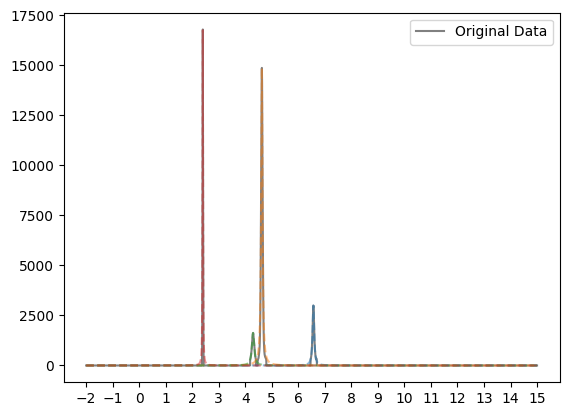

In [34]:
# bring the data back to the cpu
data_train_tensor = data_train_tensor.to("cpu")
data_val_tensor = data_val_tensor.to("cpu")
data_test_tensor = data_test_tensor.to("cpu")

target_train_tensor = target_train_tensor.to("cpu")
target_val_tensor = target_val_tensor.to("cpu")
target_test_tensor = target_test_tensor.to("cpu")

data_train_tensor = data_train_tensor.squeeze(1)
data_val_tensor = data_val_tensor.squeeze(1)
# scale the data back
data_train = data_scaler.inverse_transform(data_train_tensor)
data_val = data_scaler.inverse_transform(data_val_tensor)
target_train = target_scaler.inverse_transform(target_train_tensor)


print(f'data_train: {data_train.shape}')
print(f'data_val: {data_val.shape}')
print(f'target_train: {target_train.shape}')

print(f'len substrates_list: {len(substrates_list)}')


x0_parms_train, gamma_parms_train, height_parms_train = np.split(target_train, 3, axis=1)
x0_parms_val, gamma_parms_val, height_parms_val = np.split(target_val, 3, axis=1)
x0_parms_test, gamma_parms_test, height_parms_test = np.split(target_test, 3, axis=1)




n = 30
x = x_data[n]
# plot the data
#plt.plot(x, data_train[n, :], '-', label='Original Data')
# for x0, gamma, height in zip(x0_parms_train[n], gamma_parms_train[n], height_parms_train[n]):
#     lorentz = lorentzian(x, x0, gamma, height)
#     plt.plot(x, lorentz, '--', label='Original Peaks', alpha=0.5)

# plt.plot(x, data_val[n, :], '-', label='Original Data', color='grey')
# for x0, gamma, height in zip(x0_parms_val[n], gamma_parms_val[n], height_parms_val[n]):
#     lorentz = lorentzian(x, x0, gamma, height)
#     plt.plot(x, lorentz, '--', label='Original Peaks', alpha=0.5)   
    
#fig = plt.figure(figsize=(10, 8))

plt.plot(x, data_test[n, :], '-', label='Original Data', color='grey')
for x0, gamma, height in zip(x0_parms_test[n], gamma_parms_test[n], height_parms_test[n]):
    lorentz = lorentzian(x, x0, gamma, height)
    plt.plot(x, lorentz, '--', alpha=0.5)

plt.xticks(np.arange(-2, 16, 1))
plt.legend()
plt.show()

# Validate on real Data

In [35]:
# # Use a dataframe to collect general evaluation results
# results = pd.DataFrame()

# # We will reuse this function. Hence we copy it to mads_dl.py
# def add_regression_eval(results, algorithm, y_train, y_train_pred, y_test, y_test_pred, num_params):
#     '''
#     Create a table with evaluation results
#     of a regression experiment
#     '''
#     for dataset, actual, predicted in zip(("train", "test"), (y_train, y_test), (y_train_pred, y_test_pred)):
#         mse=mean_squared_error(actual, predicted)
#         results= pd.concat([results, pd.DataFrame([{
#             "algorithm": algorithm, 
#             "dataset": dataset,
#             "MSE": mse,
#             "RMSE": math.sqrt(mse),
#             "MAE": mean_absolute_error(actual, predicted),
#             "MAPE": mean_absolute_percentage_error(actual, predicted)*100, # implemented is relative to 1 not to 100
#             "params": num_params
#         }])], ignore_index=True)   
#     return results


# Test on Data

(1, 3000)


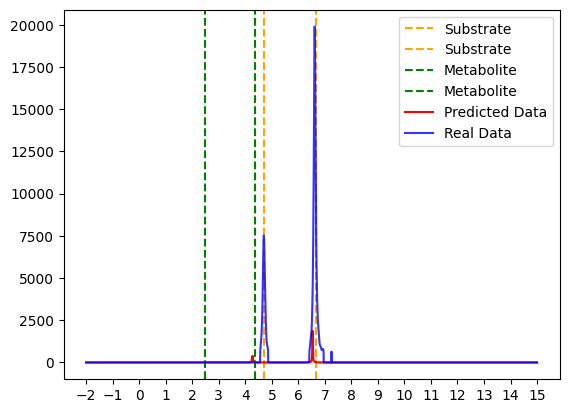

(1, 3000)


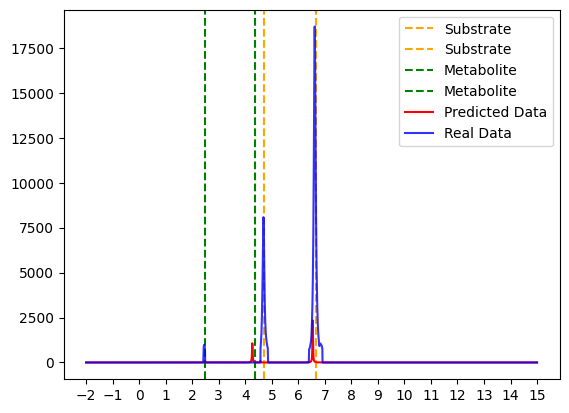

(1, 3000)


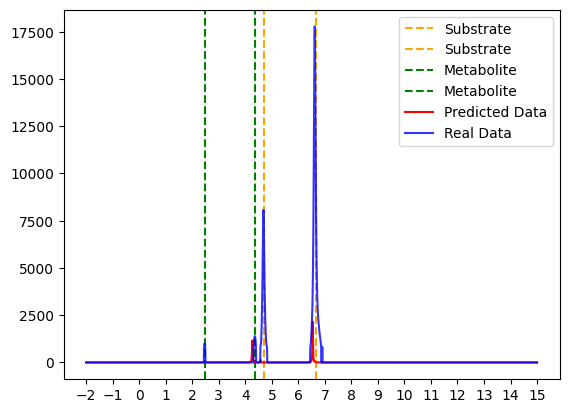

(1, 3000)


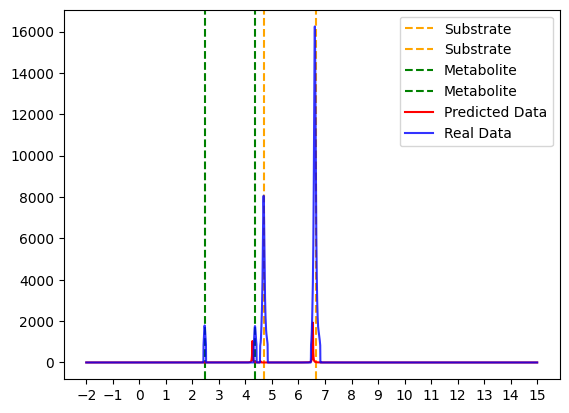

(1, 3000)


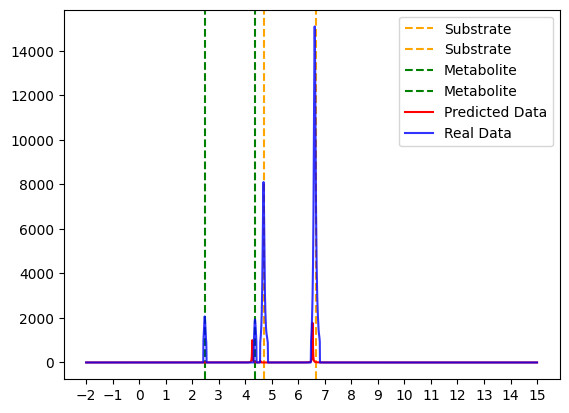

(1, 3000)


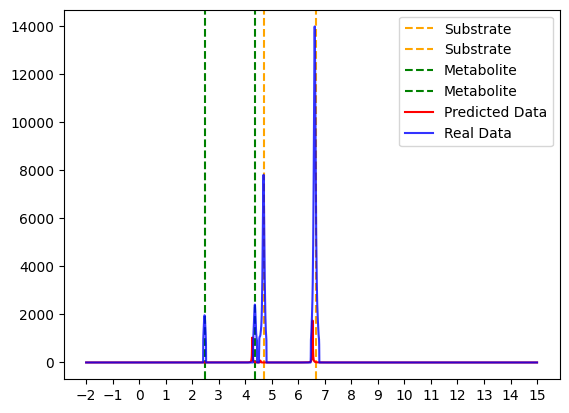

(1, 3000)


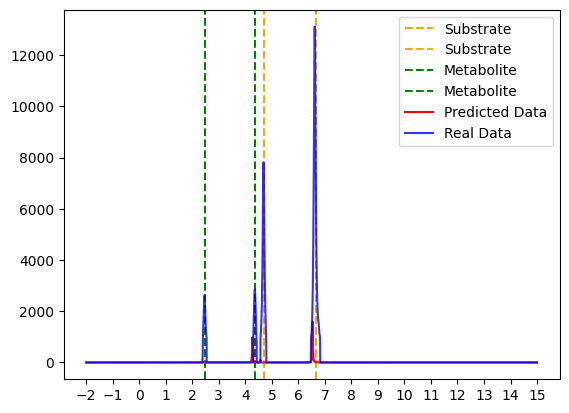

(1, 3000)


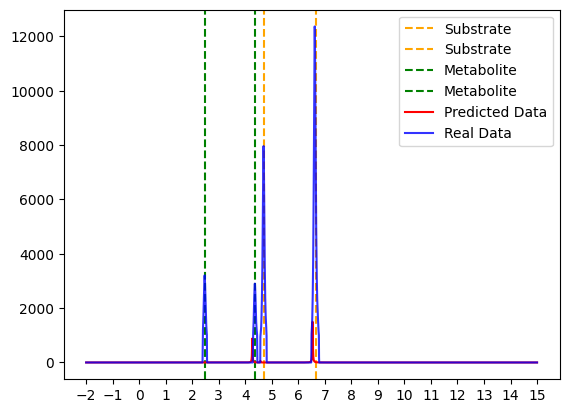

(1, 3000)


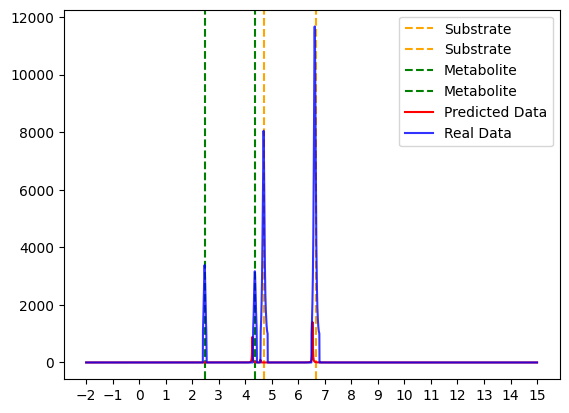

(1, 3000)


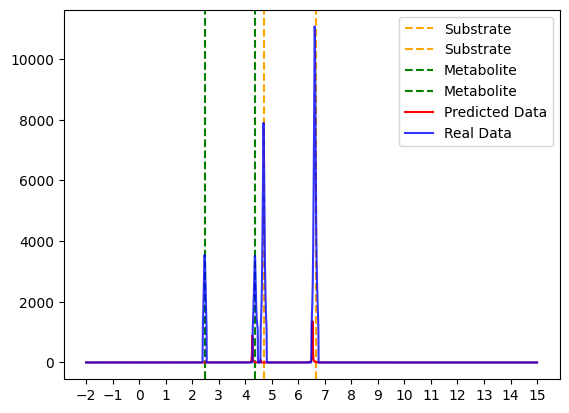

(1, 3000)


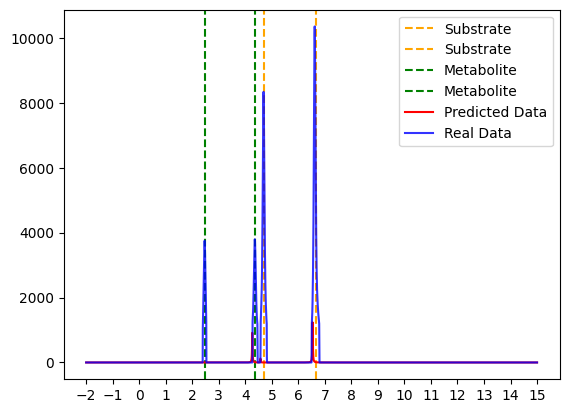

(1, 3000)


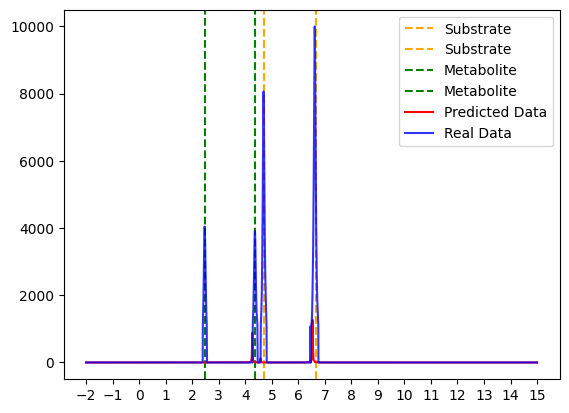

(1, 3000)


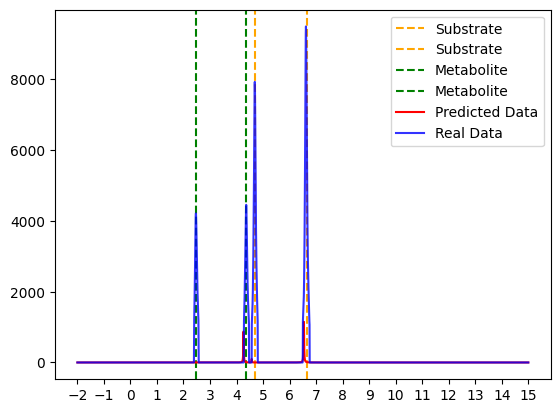

(1, 3000)


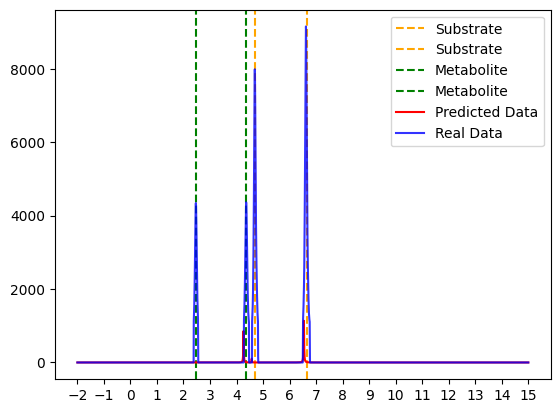

(1, 3000)


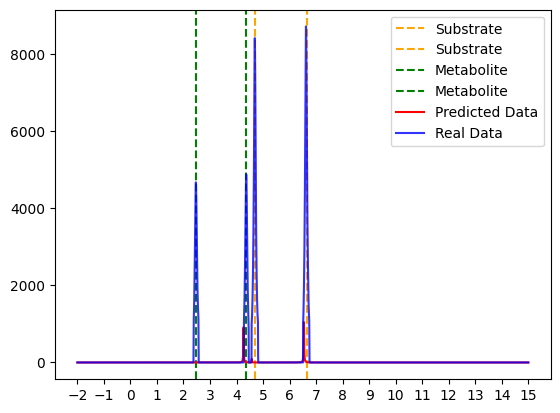

(1, 3000)


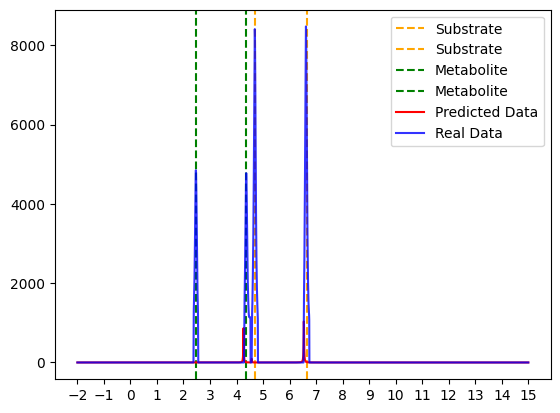

(1, 3000)


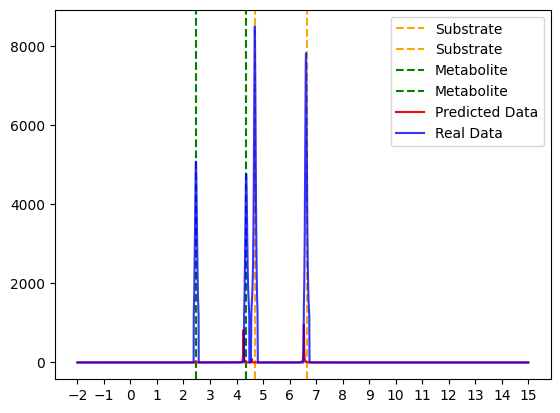

(1, 3000)


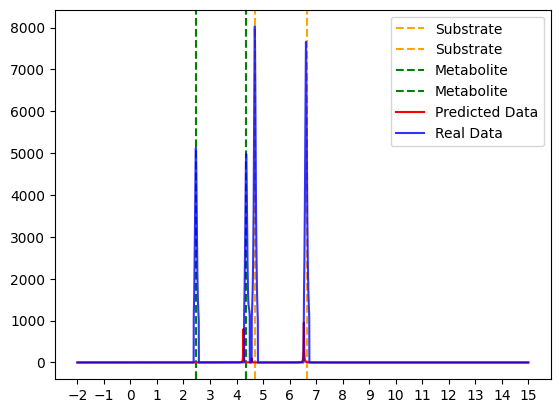

(1, 3000)


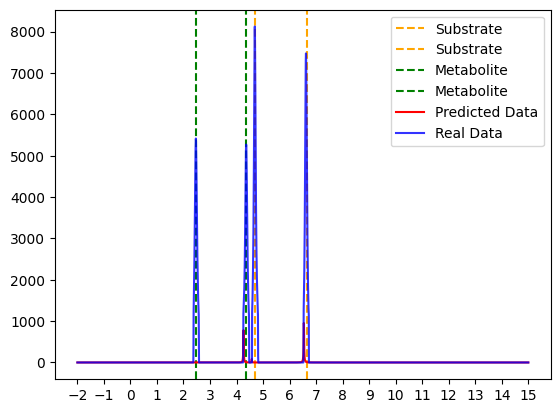

(1, 3000)


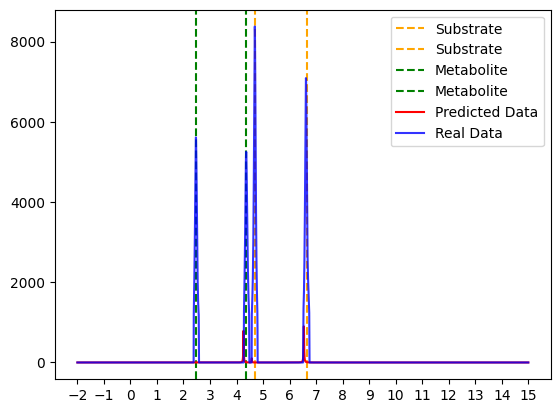

(1, 3000)


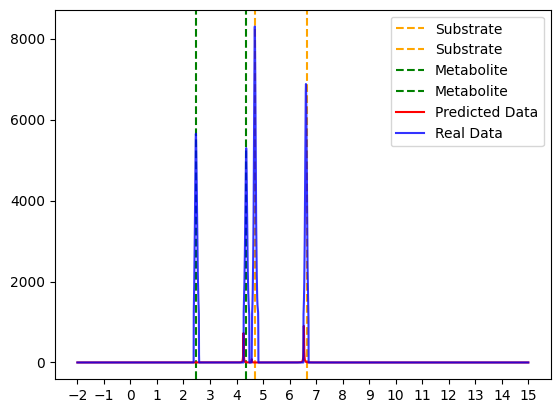

(1, 3000)


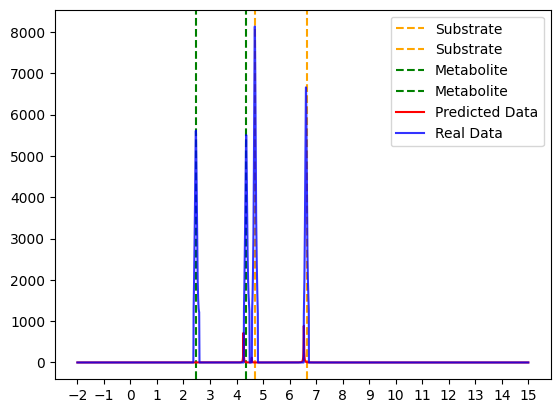

(1, 3000)


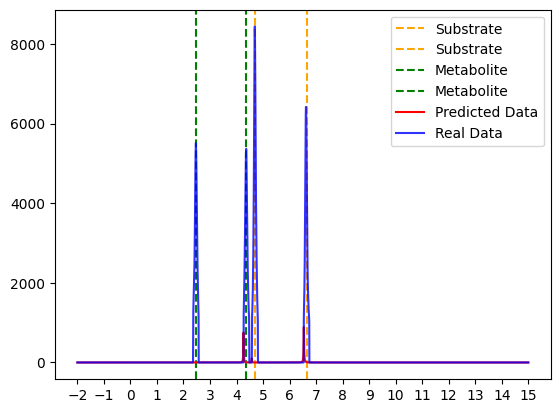

(1, 3000)


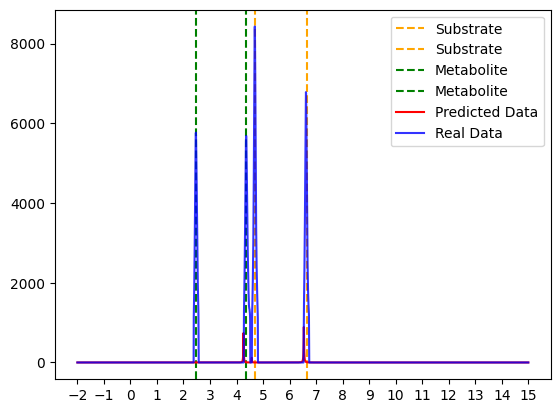

(1, 3000)


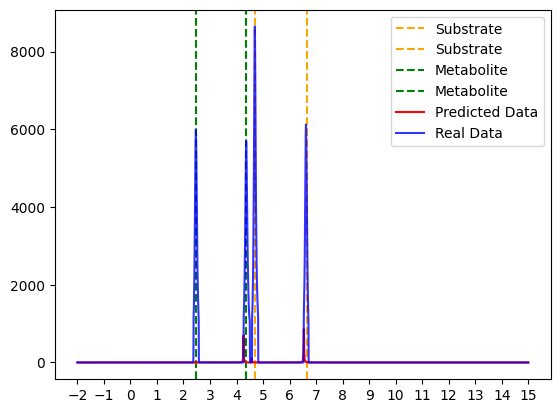

(1, 3000)


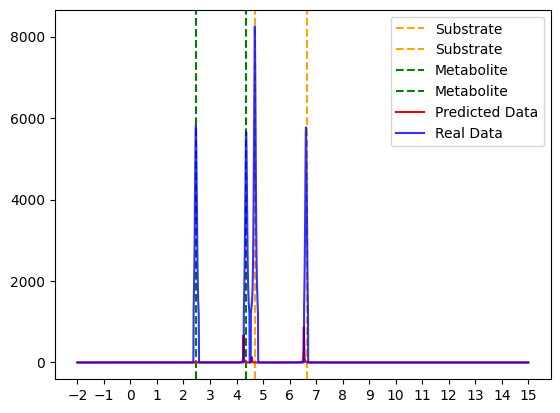

(1, 3000)


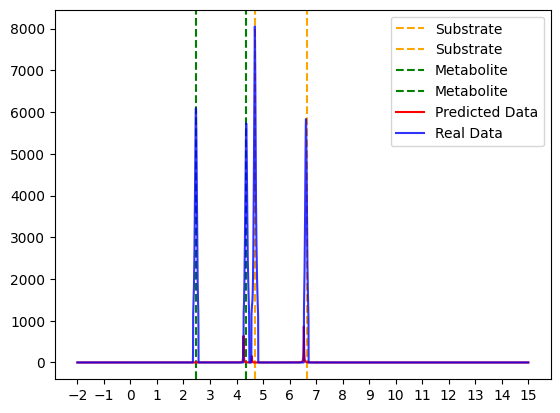

(1, 3000)


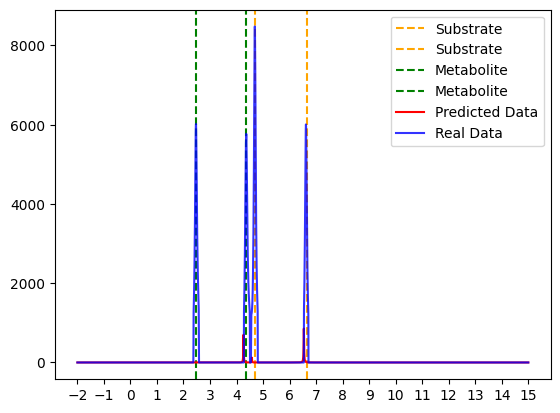

(1, 3000)


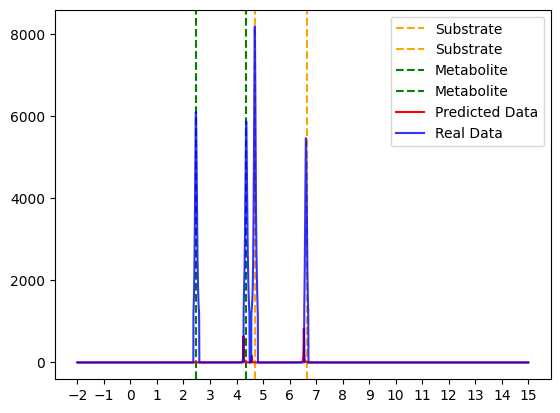

In [36]:
df = pd.read_csv(path_list[0]) 

for i in range(1, 30):
    # fill the data
    df_fill = fill_df(df.iloc[:, [0, i]])

    # interpolate the data
    df_interpolated = interpolate_to_shape(df_fill.iloc[:, 0], df_fill.iloc[:, 1], spectrum_lenth=3000)
    #display(df_interpolated)
    x_real = df_interpolated.loc[:, 'x']
    y_real = df_interpolated.loc[:, 'y']

    # scale the data
    y_real_sc = data_scaler.transform(y_real.values.reshape(1, -1))
    print(y_real_sc.shape)

    # convert to tensor
    y_real_tensor = torch.tensor(y_real_sc, dtype=torch.float32)

    # predict the data
    target_real_pred = model.predict(y_real_tensor)

    # bring the data back to the cpu
    target_real_pred = target_real_pred.cpu().detach().numpy()

    # rescale the data
    target_real_pred_rescaled = target_scaler.inverse_transform(target_real_pred)

    # reshape the data
    target_real_pred = target_real_pred_rescaled.reshape(target_real_pred_rescaled.shape[0], -1)

    x0_parms_real, gamma_parms_real, height_parms_real = np.split(target_real_pred, 3, axis=1)

    # calcualte the mse
    #mse = calculate_mse_of_real_data(df, model, random=False, i=i)
    #print(mse)
    
    # Put the Lorenz functions in a Dataframe
    lorentz_list = []
    lorentz_df = pd.DataFrame({'x': x_real})  # Initialize DataFrame with x_real

    for i, (x0, gamma, height) in enumerate(zip(x0_parms_real[0], gamma_parms_real[0], height_parms_real[0])):
        lorentz = lorentzian(x_real, x0, gamma, height)
        column_name = f'lorentz_{i}'  # Dynamically generate a unique column name
        lorentz_df = pd.concat([lorentz_df, pd.DataFrame({column_name: lorentz})], axis=1)

    # add another column which takes the np.maximum of the columns
    lorentz_df['max'] = lorentz_df.iloc[:, 1:].max(axis=1)
    #display(lorentz_df)
    


    for subs in substrates:
        plt.axvline(x=subs, color='orange', linestyle='--', label='Substrate')

    for metab in metabolites:
        plt.axvline(x=metab, color='green', linestyle='--', label='Metabolite')

    
    plt.plot(x_real, lorentz_df['max'], label='Predicted Data', color='red')
    plt.plot(x_real, y_real, label='Real Data', color='blue', alpha=0.8)

    plt.xticks(np.arange(-2, 16, 1))
    plt.legend()
    plt.show()

In [37]:
substrates, metabolites

([6.653, 4.7], [4.368, 2.474])